<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Hugo/Hugo_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "BOSSDEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 14:39:04,656 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 14:39:04,658 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for BOSSDEEUR
2019-08-28 14:39:49,477 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 14:41:55,564 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 14:43:09,086 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 14:44:21,079 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 14:45:15,545 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 14:46:04,028 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 14:47:03,928 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 14:48:04,836 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 14:51:44,614 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_BOSSDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-BOSSDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-BOSSDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.71197  0.71598  0.70777  0.71517  19.460371
2018-01-02 09:00:00  0.71478  0.72118  0.71437  0.71917  19.574858
2018-01-02 10:00:00  0.71918  0.72178  0.71807  0.72098  10.609527
2018-01-02 11:00:00  0.72097  0.72398  0.72058  0.72257   7.737653
2018-01-02 12:00:00  0.72257  0.72498  0.72138  0.72328  13.414879
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  0.53188  0.53728  0.53107  0.53307  61.718399
2018-12-28 09:00:00  0.53307  0.53688  0.53197  0.53637  46.478001
2018-12-28 10:00:00  0.53637  0.53847  0.53487  0.53598  43.910400
2018-12-28 11:00:00  0.53617  0.53927  0.53408  0.53627  39.104599
2018-12-28 12:00:00  0.53627  0.53878  0.53478  0.53728  51.474667

[2248 rows x 5 columns]

Open         High          Low        Close       Volume
count  2248.000000  2248.000000  2248.000000  2248.000000  2248.000000
mean      0.706732     0.709062     0.704294     0.706723    12.963424
std       0.064492     0.064334     0.064733     0.064567     9.288733
min       0.526770     0.529770     0.524900     0.529280     1.578011
25%       0.663577     0.667530     0.660523     0.663222     7.100648
50%       0.720570     0.722980     0.718370     0.720580    10.530329
75%       0.761205     0.763628     0.759180     0.761373    15.790810
max       0.804580     0.813780     0.802770     0.804580    86.795708

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2018-01-09 13:00:00  0.72958  0.72998  0.72698  0.72797   4.000029    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.730177  0.727923 -0.736337  0.728968  0.730226  0.730329    0.730870    0.730830  0.734524  0.730124  0.728247  0.731025  0.730007  0.730124  0.728707  0.732021                0.735561                 0.730124                0.724687                0.738280                 0.730124                0.721968                0.740998                 0.730124                0.719249                0.743717                 0.730124                0.716531  0.730226  0.728907  0.732054                0.735663                 0.730226                0.724789                0.738382                 0.730226                0.722070                0.741100                 0.730226                0.719351                0.743819                 0.730226                0.716633   
2018-01-09 14:00:00  0.72837  0.72958  0.72777  0.72918   6.750957    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.730127  0.727978 -0.735674  0.728834  0.729994  0.730306    0.731370    0.731575  0.733785  0.730400  0.728351  0.730585  0.729797  0.730400  0.728575  0.731828                0.735373                 0.730400                0.725427                0.737860                 0.730400                0.722940                0.740346                 0.730400                0.720454                0.742833                 0.730400                0.717967  0.729994  0.728947  0.731804                0.734967                 0.729994                0.725021                0.737453                 0.729994                0.722534                0.739940                 0.729994                0.720048                0.742426                 0.729994                0.717561   
2018-01-09 15:00:00 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start       month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  \
count  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000    2198.000000  2198.000000   2198.000000     2198.000000       2198.000000  2198.00000  2198.000000  2198.000000  2198.000000   2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000  2198.000000  2198.000000  2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000             2198.000000             2198.000000              2198.000000   
mean      0.706251     0.708587     0.703800     0.706238    13.046861    15.971793     2.031392   184.203367      30.415833    11.379891      0.032302        0.024113          0.004095     6.55778     2.521383    26.881711     2.031392      1.989081    26.881711     0.706534     0.707307     0.007059     0.706234     0.706549     0.706403     0.706503     0.706304     0.706601     0.706548     0.706235     0.706547     0.706444     0.706548     0.706305     0.707179                0.713666                 0.706548                0.699430                0.717225                 0.706548                0.695871                0.720784                 0.706548                0.692312                0.724343                 0.706548                0.688753     0.706549     0.706305     0.707085                0.713667                 0.706549                0.699431                0.717226                 0.706549                0.695872                0.720785                 0.706549   
std       0.065136     0.064979     0.065376     0.065211     9.346857     8.549256     1.407250   101.462039       0.857091     2.621277      0.176841        0.153434          0.063873     3.34077     1.100440    14.494191     1.407250      1.400263    14.494191     0.064481     0.063127     0.709838     0.065270     0.064649     0.064361     0.064741     0.064868     0.064605     0.064719     0.065251     0.064752     0.064860     0.064719     0.065079     0.063741                0.064393                 0.064719                0.065395                0.064362                 0.064719                0.065860                0.064420                 0.064719                0.066408                0.064567                 0.064719                0.067037     0.064649     0.065073     0.063888                0.064304                 0.064649                0.065343                0.064264                 0.064649                0.065817                0.064314                 0.064649   
min       

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.730031  0.704940  0.727246  0.721722  0.028422    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.737695  0.739189  0.048048  0.726722  0.738537  0.739626    0.738873    0.730157  0.725644  0.736188  0.722002  0.739379  0.735932  0.736188  0.726065  0.751432                0.732340                 0.736188                0.731714                0.712289                 0.736188                0.730368                0.667464                 0.736188                0.736386                0.627122                 0.736188                0.739583  0.738537  0.727460  0.750983                0.739464                 0.738537                0.734316                0.723990                 0.738537                0.736308                0.681800                 0.738537                0.741177                0.639503                 0.738537   
2018-01-09 14:00:00  0.725676  0.703531  0.730089  0.726117  0.060703    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.737511  0.739400  0.048459  0.726238  0.737675  0.739539    0.740722    0.732872  0.723084  0.737208  0.722375  0.737760  0.735160  0.737208  0.725586  0.750701                0.731660                 0.737208                0.734459                0.710821                 0.737208                0.733970                0.665344                 0.737208                0.740702                0.624440                 0.737208                0.744550  0.737675  0.727605  0.750039                0.736907                 0.737675                0.735180                0.720678                 0.737675                0.738013                0.677929                 0.737675                0.743649                0.635177                 0.737675   
2018-01-09 15:00:00  0.728556  0.707052  0.731205  0.731202  0.025260    9          1          9         

139855

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptwfvi1mz
  JVM stdout: /tmp/tmptwfvi1mz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptwfvi1mz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_rkc5rb
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190828_150158  0.513274  0.738276              0.482549  0.519581  0.269965
1  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.500000  0.692915              0.500000  0.499884  0.249884
2  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.500000  0.692795              0.500000  0.499824  0.249824
3  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.500000  0.693632              0.500000  0.500242  0.250242
4  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.500000  0.692800              0.500000  0.499826  0.249826
5  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.500000  0.692917              0.500000  0.499885  0.249885
6  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.495823  0.798063              0.491150  0.542979  0.294826
7  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.475395  0.942685              0.495575  0.576486  0.332336
8  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.472087  0.916842              0.500000  0.567646  0.322222
9  DeepLearning_grid_1_AutoML_20190828_150158_mod...  0.460260  1.942876              0.500000  0.651441  0.424376

variable  relative_importance  scaled_importance  percentage
0          CDLEVENINGDOJISTAR             1.000000           1.000000    0.001817
1                   STDDEV_30             0.932507           0.932507    0.001694
2           CDLDARKCLOUDCOVER             0.930012           0.930012    0.001690
3                STOCHF_fastk             0.920009           0.920009    0.001672
4     BBANDS_lowerband_24_6_5             0.895225           0.895225    0.001627
...                       ...                  ...                ...         ...
1031  BBANDS_upperband_30_7_3             0.262666           0.262666    0.000477
1032  BBANDS_lowerband_14_7_5             0.251077           0.251077    0.000456
1033            MINMAX_max_20             0.247609           0.247609    0.000450
1034                   EMA_24             0.243589           0.243589    0.000443
1035  BBANDS_lowerband_14_4_4             0.219311           0.219311    0.000399

[1036 rows x 4 columns]

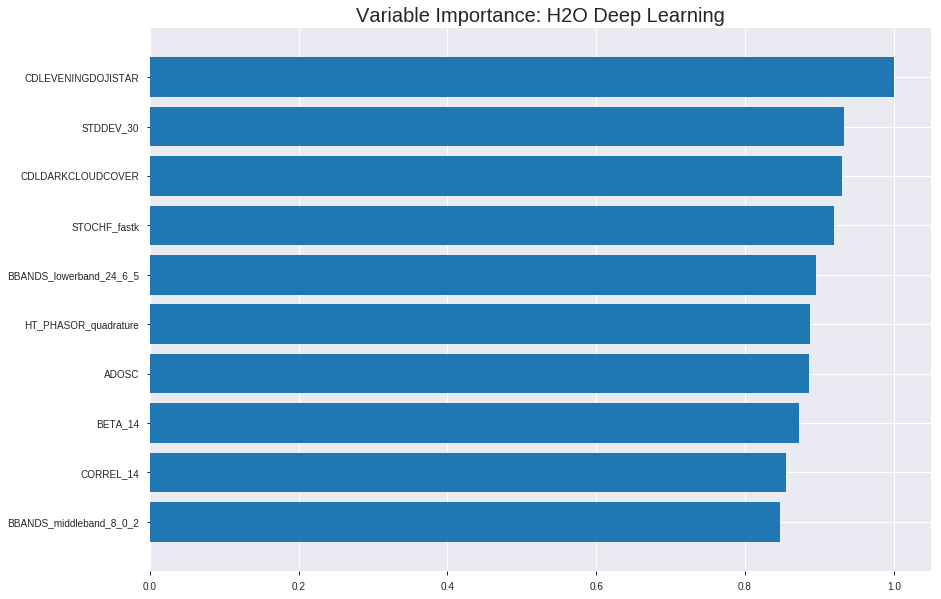

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_150158


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23484032743426897
RMSE: 0.484603268080467
LogLoss: 0.6577735948667993
Mean Per-Class Error: 0.42049808429118773
AUC: 0.6026589564044974
pr_auc: 0.6119131816154642
Gini: 0.2053179128089948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24738524490456468: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      80   674   0.8939   (674.0/754.0)
1      9    774   0.0115   (9.0/783.0)
Total  89   1448  0.4444   (683.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.247385     0.693859  328
max f2                       0.124399     0.846137  362
max f0point5                 0.489693     0.595213  233
max accuracy                 0.504571     0.581653  215
max precision                0.999483     1         0
max recall                   0.0853013    1         375
max specificity              0.999483     1         0
max absolute_mcc             0.22827      0.202789  331
max min_per_class_accuracy   0.565675     0.568327  147
max mean_per_class_accuracy  0.504571     0.579502  215

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 51.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.847658           1.84028   1.84028            0.9375           0.906457  0.9375                      0.906457            0.0191571       0.0191571                  84.0278    84.0278
    2        0.0201692                   0.78071            1.57037   1.70968            0.8              0.816672  0.870968                    0.863013            0.0153257       0.0344828                  57.037     70.9677
    3        0.0305791                   0.71478            1.84028   1.75414            0.9375           0.743533  0.893617                    0.822339            0.0191571       0.0536398                  84.0278    75.4137
    4        0.0403383                   0.704473           1.17778   1.6147             0.6              0.709039  0.822581                    0.794927            0.0114943       0.0651341                  17.7778    61.4695
    5        0.0500976                   0.686533           1.30864   1.55507            0.666667         0.696689  0.792208                    0.77579             0.0127714       0.0779055                  30.8642    55.5075
    6        0.100195                    0.58872            1.24916   1.40212            0.636364         0.645963  0.714286                    0.710877            0.0625798       0.140485                   24.9158    40.2116
    7        0.150293                    0.574477           1.01972   1.27465            0.519481         0.576674  0.649351                    0.666142            0.0510856       0.191571                   1.9721     27.4651
    8        0.20039                     0.573652           0.994228  1.20455            0.506494         0.573991  0.613636                    0.643105            0.0498084       0.241379                   -0.577201  20.4545
    9        0.299935                    0.572482           1.05205   1.15393            0.535948         0.573098  0.587852                    0.61987             0.104725        0.346105                   5.20455    15.3933
    10       0.40013                     0.571151           1.07071   1.13309            0.545455         0.571859  0.577236                    0.607848            0.10728         0.453384                   7.07071    13.3092
    11       0.500325                    0.565598           1.13444   1.13336            0.577922         0.570143  0.577373                    0.600297            0.113665        0.56705                    13.444     13.3362
    12       0.59987                     0.510781           1.10336   1.12838            0.562092         0.536945  0.574837                    0.589784            0.109834        0.676884                   10.3365    12.8384
    13       0.880286                    0.467832           0.897224  1.05475            0.457077         0.474939  0.537324                    0.5532              0.251596        0.92848                    -10.2776   5.4748
    14       0.899805                    0.426878           1.11235   1.056              0.566667         0.448228  0.537961                    0.550923            0.0217114       0.950192                   11.2346    5.59974
    15       1                           0.00269632         0.497114  1                  0.253247         0.209559  0.509434                    0.51672             0.0498084       1                          -50.2886   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25795794815415507
RMSE: 0.5078956075357958
LogLoss: 0.7093499420035922
Mean Per-Class Error: 0.4866666666666667
AUC: 0.47472868217054265
pr_auc: 0.46276806839106127
Gini: -0.0505426356589147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34705009858516656: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    215  0        (0.0/215.0)
Total  1    439  0.5091   (224.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34705      0.657492  398
max f2                       0.34705      0.82756   398
max f0point5                 0.34705      0.545408  398
max accuracy                 0.573136     0.511364  1
max precision                0.573136     0.5       1
max recall                   0.34705      1         398
max specificity              0.573567     0.995556  0
max absolute_mcc             0.563253     0.116297  65
max min_per_class_accuracy   0.465184     0.484444  192
max mean_per_class_accuracy  0.407139     0.513333  309

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 47.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.572234           0.818605  0.818605           0.4              0.572815  0.4                         0.572815            0.00930233      0.00930233                 -18.1395  -18.1395
    2        0.0204545                   0.571969           1.02326   0.909561           0.5              0.572128  0.444444                    0.57251             0.00930233      0.0186047                  2.32558   -9.04393
    3        0.0318182                   0.571496           0.409302  0.730897           0.2              0.571695  0.357143                    0.572219            0.00465116      0.0232558                  -59.0698  -26.9103
    4        0.0409091                   0.571331           1.53488   0.909561           0.75             0.571419  0.444444                    0.572041            0.0139535       0.0372093                  53.4884   -9.04393
    5        0.05                        0.570942           0         0.744186           0                0.571211  0.363636                    0.57189             0               0.0372093                  -100      -25.5814
    6        0.1                         0.56973            1.11628   0.930233           0.545455         0.570315  0.454545                    0.571103            0.055814        0.0930233                  11.6279   -6.97674
    7        0.15                        0.568714           0.651163  0.837209           0.318182         0.569116  0.409091                    0.57044             0.0325581       0.125581                   -34.8837  -16.2791
    8        0.2                         0.565323           0.744186  0.813953           0.363636         0.56792   0.397727                    0.56981             0.0372093       0.162791                   -25.5814  -18.6047
    9        0.3                         0.538699           1.02326   0.883721           0.5              0.552953  0.431818                    0.564191            0.102326        0.265116                   2.32558   -11.6279
    10       0.4                         0.508967           1.25581   0.976744           0.613636         0.524424  0.477273                    0.554249            0.125581        0.390698                   25.5814   -2.32558
    11       0.5                         0.465381           0.930233  0.967442           0.454545         0.48404   0.472727                    0.540207            0.0930233       0.483721                   -6.97674  -3.25581
    12       0.6                         0.442255           1.11628   0.992248           0.545455         0.454219  0.484848                    0.525876            0.111628        0.595349                   11.6279   -0.775194
    13       0.7                         0.427199           0.976744  0.990033           0.477273         0.434924  0.483766                    0.512883            0.0976744       0.693023                   -2.32558  -0.996678
    14       0.8                         0.404829           1.11628   1.00581            0.545455         0.414341  0.491477                    0.500565            0.111628        0.804651                   11.6279   0.581395
    15       0.9                         0.381684           0.790698  0.981912           0.386364         0.394714  0.479798                    0.488804            0.0790698       0.883721                   -20.9302  -1.80879
    16       1                           0.262197           1.16279   1                  0.568182         0.360484  0.488636                    


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:01:59  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:02:00  2.401 sec   1803 obs/sec      1         1             1537       0.5996           1.20488             -0.438595      0.541219        0.537606           1.59491          0.478204                         0.702745           2.67911               -0.976422        0.46463           0.466016             0.818605           0.497727
    2019-08-28 15:02:03  4.871 sec   5004 obs/sec      10        10            15370      0.484603         0.657774            0.0603042      0.602659        0.611913           1.84028          0.444372                         0.507896           0.70935               -0.032365        0.474729          0.462768             0.818605           0.509091

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ----------------------
CDLEVENINGDOJISTAR       1.0                    1.0                  0.0018171043451633902
STDDEV_30                0.9325065016746521     0.9325065016746521   0.0016944616160861226
CDLDARKCLOUDCOVER        0.930011510848999      0.930011510848999    0.0016899279574156855
STOCHF_fastk             0.9200093746185303     0.9200093746185303   0.0016717530322103847
BBANDS_lowerband_24_6_5  0.8952252268791199     0.8952252268791199   0.0016267176496619306
---                      ---                    ---                  ---
BBANDS_upperband_30_7_3  0.262665718793869      0.262665718793869    0.0004772910189458046
BBANDS_lowerband_14_7_5  0.25107696652412415    0.25107696652412415  0.00045623304684142907
MINMAX_max_20            0.24760867655277252    0.24760867655277252  0.0004499308020641994
EMA_24                   0.24358898401260376    0.24358898401260376  0.0004426266012832379
BBANDS_lowerband_14_4_4  0.21931129693984985    0.21931129693984985  0.0003985115106128197


See the whole table with table.as_data_frame()


('accuracy', 0.5409090909090909)

('F1', 0.660436137071651)

('auc', 0.5132743362831859)

('logloss', 0.7382758557107054)

('mean_per_class_error', 0.463692002315772)

('rmse', 0.5195813590953743)

('mse', 0.2699647887193963)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


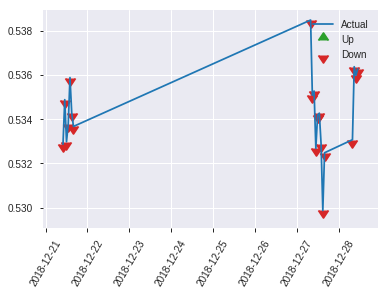


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2699647887193963
RMSE: 0.5195813590953743
LogLoss: 0.7382758557107054
Mean Per-Class Error: 0.463692002315772
AUC: 0.5132743362831859
pr_auc: 0.4944953253517896
Gini: 0.026548672566371723
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21078339073487734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    108  0.9558   (108.0/113.0)
1      1    106  0.0093   (1.0/107.0)
Total  6    214  0.4955   (109.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.210783     0.660436  213
max f2                       0.193729     0.825617  219
max f0point5                 0.210783     0.550363  213
max accuracy                 0.460157     0.540909  17
max precision                0.460157     0.666667  17
max recall                   0.193729     1         219
max specificity              0.481883     0.99115   0
max absolute_mcc             0.460157     0.107685  17
max min_per_class_accuracy   0.380731     0.504673  107
max mean_per_class_accuracy  0.332999     0.536308  145

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 35.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.476099           0.685358  0.685358           0.333333         0.478669  0.333333                    0.478669            0.00934579      0.00934579                 -31.4642  -31.4642
    2        0.0227273                   0.467308           1.02804   0.82243            0.5              0.471553  0.4                         0.475823            0.00934579      0.0186916                  2.80374   -17.757
    3        0.0318182                   0.466099           1.02804   0.881175           0.5              0.466509  0.428571                    0.473162            0.00934579      0.0280374                  2.80374   -11.8825
    4        0.0409091                   0.465917           2.05607   1.14226            1                0.465959  0.555556                    0.471561            0.0186916       0.046729                   105.607   14.2264
    5        0.05                        0.462519           1.02804   1.1215             0.5              0.464372  0.545455                    0.470254            0.00934579      0.0560748                  2.80374   12.1495
    6        0.1                         0.456984           1.1215    1.1215             0.545455         0.460684  0.545455                    0.465469            0.0560748       0.11215                    12.1495   12.1495
    7        0.15                        0.435021           0.747664  0.996885           0.363636         0.447943  0.484848                    0.459627            0.0373832       0.149533                   -25.2336  -0.311526
    8        0.2                         0.427079           0.934579  0.981308           0.454545         0.432137  0.477273                    0.452755            0.046729        0.196262                   -6.54206  -1.86916
    9        0.3                         0.411654           0.934579  0.965732           0.454545         0.420185  0.469697                    0.441898            0.0934579       0.28972                    -6.54206  -3.42679
    10       0.4                         0.397899           1.40187   1.07477            0.681818         0.406399  0.522727                    0.433023            0.140187        0.429907                   40.1869   7.47664
    11       0.5                         0.37416            0.747664  1.00935            0.363636         0.389619  0.490909                    0.424342            0.0747664       0.504673                   -25.2336  0.934579
    12       0.6                         0.347728           1.02804   1.01246            0.5              0.360629  0.492424                    0.413724            0.102804        0.607477                   2.80374   1.24611
    13       0.7                         0.326857           1.02804   1.01469            0.5              0.336241  0.493506                    0.402655            0.102804        0.71028                    2.80374   1.46862
    14       0.8                         0.258518           0.934579  1.00467            0.454545         0.2932    0.488636                    0.388973            0.0934579       0.803738                   -6.54206  0.46729
    15       0.9                         0.236098           0.934579  0.996885           0.454545         0.247695  0.484848                    0.373275            0.0934579       0.897196                   -6.54206  -0.311526
    16       1                           0.193729           1.02804   1                  0.5              0.218506  0.486364                    0.357798

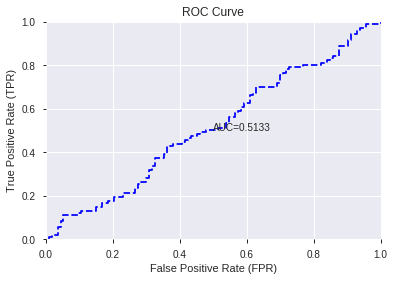

This function is available for GLM models only


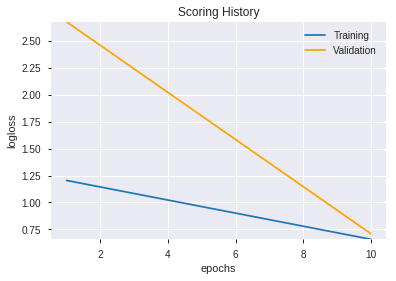

--2019-08-28 15:26:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  25.1MB/s    in 27s     

2019-08-28 15:26:56 (13.0 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_150158',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_150158',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_a92b',


In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_152707_model_7  0.542718  0.690120              0.500000  0.498522  0.248524
1               DeepLearning_1_AutoML_20190828_152707  0.527004  1.524967              0.482549  0.660923  0.436819
2  DeepLearning_grid_1_AutoML_20190828_152707_model_9  0.511868  0.692644              0.478372  0.499749  0.249749
3  DeepLearning_grid_1_AutoML_20190828_152707_model_8  0.510504  0.693557              0.500000  0.500204  0.250204
4  DeepLearning_grid_1_AutoML_20190828_152707_model_6  0.505665  0.698891              0.495575  0.502854  0.252862
5  DeepLearning_grid_1_AutoML_20190828_152707_model_5  0.504673  0.693711              0.500000  0.500282  0.250282
6  DeepLearning_grid_1_AutoML_20190828_152707_model_1  0.489951  1.049840              0.500000  0.591522  0.349898
7  DeepLearning_grid_1_AutoML_20190828_152707_model_2  0.473493  1.692346              0.486726  0.677896  0.459543
8  DeepLearning_grid_1_AutoML_20190828_152707_model_3  0.465636  0.946389              0.495575  0.578483  0.334643
9  DeepLearning_grid_1_AutoML_20190828_152707_model_4  0.462327  0.747973              0.491150  0.525214  0.275850

variable  relative_importance  scaled_importance  percentage
0                        OBV             1.000000           1.000000    0.023822
1                HT_DCPERIOD             0.955655           0.955655    0.022765
2               STOCHF_fastk             0.936457           0.936457    0.022308
3       HT_PHASOR_quadrature             0.935879           0.935879    0.022294
4                      VAR_8             0.930528           0.930528    0.022167
5                    NATR_14             0.903840           0.903840    0.021531
6             STOCHRSI_fastk             0.901758           0.901758    0.021481
7                 AROONOSC_8             0.894163           0.894163    0.021300
8                 aroonup_14             0.886842           0.886842    0.021126
9                    BETA_14             0.872179           0.872179    0.020777
10                   ADXR_12             0.871194           0.871194    0.020753
11                    MOM_24             0.871164           0.871164    0.020753
12                   TRIX_14             0.870196           0.870196    0.020730
13                 CORREL_12             0.867419           0.867419    0.020663
14                       PPO             0.862909           0.862909    0.020556
15                   BETA_24             0.859712           0.859712    0.020480
16                 CORREL_14             0.857374           0.857374    0.020424
17                 dayofweek             0.856567           0.856567    0.020405
18                     ADOSC             0.855549           0.855549    0.020381
19                 STDDEV_30             0.854161           0.854161    0.020348
20                  WILLR_12             0.842850           0.842850    0.020078
21          CDLDRAGONFLYDOJI             0.837290           0.837290    0.019946
22   BBANDS_lowerband_24_5_4             0.825667           0.825667    0.019669
23                  MAVP_8_0             0.824171           0.824171    0.019633
24    BBANDS_upperband_8_5_2             0.822206           0.822206    0.019586
25                   KAMA_12             0.816369           0.816369    0.019447
26   BBANDS_lowerband_24_6_5             0.813082           0.813082    0.019369
27   BBANDS_upperband_14_3_4             0.812546           0.812546    0.019356
28                 PLUS_DI_8             0.812378           0.812378    0.019352
29   BBANDS_lowerband_30_5_4             0.811140           0.811140    0.019323
30           CDLUNIQUE3RIVER             0.810456           0.810456    0.019306
31   BBANDS_lowerband_24_7_3             0.810219           0.810219    0.019301
32   BBANDS_lowerband_14_3_3             0.809789           0.809789    0.019291
33  BBANDS_middleband_14_5_2             0.808617           0.808617    0.019263
34   BBANDS_lowerband_30_2_2             0.807747           0.807747    0.019242
35   BBANDS_lowerband_30_2_5             0.807673           0.807673    0.019240
36  BBANDS_middleband_14_6_3             0.806104           0.806104    0.019203
37   BBANDS_lowerband_20_1_2             0.805327           0.805327    0.019184
38   BBANDS_upperband_24_2_3             0.801354           0.801354    0.019090
39   BBANDS_middleband_8_0_2             0.800761           0.800761    0.019075
40                  WILLR_20             0.800093           0.800093    0.019060
41   BBANDS_upperband_30_5_3             0.795822           0.795822    0.018958
42   BBANDS_upperband_24_0_5             0.792448           0.792448    0.018877
43   BBANDS_upperband_14_5_2             0.790415           0.790415    0.018829
44         CDLDARKCLOUDCOVER             0.789801           0.789801    0.018814
45        CDLEVENINGDOJISTAR             0.786251           0.786251    0.018730
46               MIDPOINT_12             0.782414           0.782414    0.018638
47   BBANDS_lowerband_24_1_4             0.782389           0.782389    0.018638
48                   MA_14_2             0.768752  

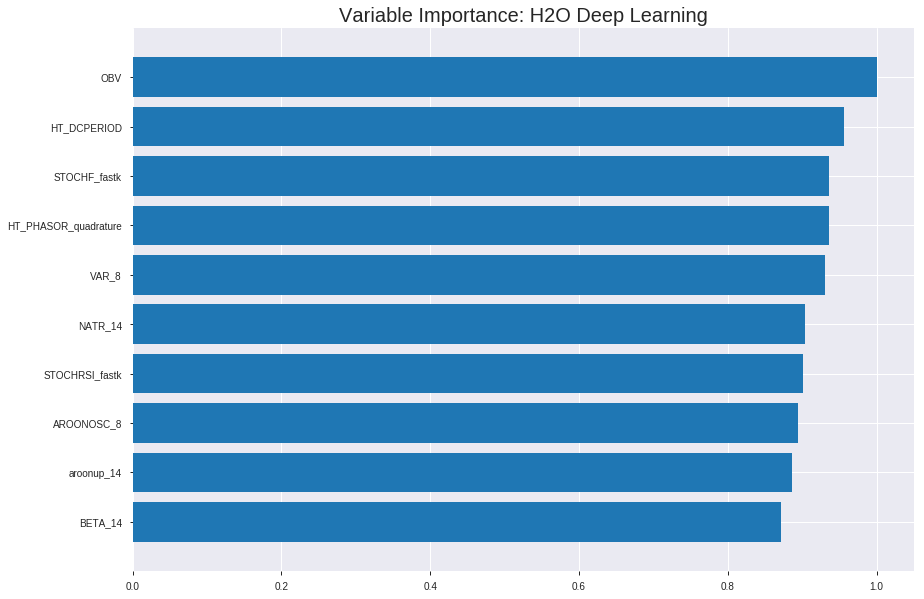

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_152707_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2437022151818807
RMSE: 0.49366204551482457
LogLoss: 0.6976689577144143
Mean Per-Class Error: 0.3841487375970134
AUC: 0.676604300266607
pr_auc: 0.6722396725687618
Gini: 0.353208600533214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10476086132798354: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      169  585   0.7759   (585.0/754.0)
1      37   746   0.0473   (37.0/783.0)
Total  206  1331  0.4047   (622.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.104761     0.705771  343
max f2                       0.0539598    0.846323  369
max f0point5                 0.327963     0.62565   236
max accuracy                 0.327963     0.618738  236
max precision                0.952781     1         0
max recall                   0.00169111   1         399
max specificity              0.952781     1         0
max absolute_mcc             0.222965     0.265499  287
max min_per_class_accuracy   0.440406     0.608753  174
max mean_per_class_accuracy  0.327963     0.615851  236

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 38.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.828821           1.71759   1.71759            0.875            0.87648   0.875                       0.87648             0.0178799       0.0178799                  71.7593    71.7593
    2        0.0201692                   0.788205           1.70123   1.70968            0.866667         0.813021  0.870968                    0.845774            0.0166028       0.0344828                  70.1235    70.9677
    3        0.0305791                   0.748427           1.47222   1.62884            0.75             0.765527  0.829787                    0.818456            0.0153257       0.0498084                  47.2222    62.8842
    4        0.0403383                   0.717034           1.43951   1.58303            0.733333         0.731017  0.806452                    0.797301            0.0140485       0.063857                   43.9506    58.3035
    5        0.0500976                   0.685525           1.57037   1.58057            0.8              0.69947   0.805195                    0.778243            0.0153257       0.0791826                  57.037     58.0568
    6        0.100195                    0.600784           1.4531    1.51684            0.74026          0.633538  0.772727                    0.705891            0.0727969       0.15198                    45.3102    51.6835
    7        0.150293                    0.539775           1.37662   1.4701             0.701299         0.56768   0.748918                    0.659821            0.0689655       0.220945                   37.6623    47.0098
    8        0.20039                     0.510195           1.30014   1.42761            0.662338         0.522859  0.727273                    0.62558             0.0651341       0.286079                   30.0144    42.7609
    9        0.299935                    0.473828           1.206     1.35406            0.614379         0.490164  0.689805                    0.580637            0.120051        0.40613                    20.6003    35.4061
    10       0.441119                    0.470244           1.04933   1.25653            0.534562         0.470491  0.640118                    0.545384            0.148148        0.554278                   4.93258    25.6528
    11       0.500325                    0.441372           0.905983  1.21505            0.461538         0.455384  0.618986                    0.534734            0.0536398       0.607918                   -9.40171   21.5046
    12       0.59987                     0.380715           1.00073   1.17948            0.509804         0.413703  0.600868                    0.514649            0.0996169       0.707535                   0.0726216  17.9481
    13       0.700065                    0.286514           1.01972   1.15662            0.519481         0.331563  0.589219                    0.488446            0.102171        0.809706                   1.9721     15.6616
    14       0.79961                     0.17609            0.872428  1.12124            0.444444         0.23481   0.571196                    0.45687             0.0868455       0.896552                   -12.7572   12.1237
    15       0.899805                    0.0723719          0.662819  1.07019            0.337662         0.1218    0.545192                    0.419559            0.0664112       0.962963                   -33.7181   7.01909
    16       1                           0.00148217         0.369649  1                  0.188312         0.035122  0.509434                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25325088060058387
RMSE: 0.503240380534575
LogLoss: 0.7003055621394395
Mean Per-Class Error: 0.48904392764857885
AUC: 0.5047235142118863
pr_auc: 0.48836293430663485
Gini: 0.009447028423772652
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4538352159413788: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    215  0        (0.0/215.0)
Total  1    439  0.5091   (224.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.453835     0.657492   111
max f2                       0.453835     0.82756    111
max f0point5                 0.453835     0.545408   111
max accuracy                 0.58096      0.520455   35
max precision                0.58096      0.555556   35
max recall                   0.453835     1          111
max specificity              0.779007     0.995556   0
max absolute_mcc             0.739258     0.0619061  4
max min_per_class_accuracy   0.470294     0.251163   108
max mean_per_class_accuracy  0.58096      0.510956   35

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 49.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113636                   0.735569           0.409302  0.409302           0.2              0.750275  0.2                         0.750275            0.00465116      0.00465116                 -59.0698   -59.0698
    2        0.0204545                   0.677228           1.53488   0.909561           0.75             0.691437  0.444444                    0.724125            0.0139535       0.0186047                  53.4884    -9.04393
    3        0.0318182                   0.664747           0.818605  0.877076           0.4              0.669215  0.428571                    0.704514            0.00930233      0.027907                   -18.1395   -12.2924
    4        0.0409091                   0.649732           0.511628  0.795866           0.25             0.659676  0.388889                    0.69455             0.00465116      0.0325581                  -48.8372   -20.4134
    5        0.05                        0.620047           1.53488   0.930233           0.75             0.63619   0.454545                    0.683939            0.0139535       0.0465116                  53.4884    -6.97674
    6        0.1                         0.568638           1.2093    1.06977            0.590909         0.592469  0.522727                    0.638204            0.0604651       0.106977                   20.9302    6.97674
    7        0.15                        0.520481           0.837209  0.992248           0.409091         0.547723  0.484848                    0.608044            0.0418605       0.148837                   -16.2791   -0.775194
    8        0.2                         0.484541           1.11628   1.02326            0.545455         0.501026  0.5                         0.581289            0.055814        0.204651                   11.6279    2.32558
    9        0.993182                    0.470244           0.996868  1.00218            0.487106         0.470643  0.489703                    0.492925            0.790698        0.995349                   -0.313187  0.21819
    10       1                           0.431115           0.682171  1                  0.333333         0.450733  0.488636                    0.492637            0.00465116      1                          -31.7829   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:31:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:31:41  5.229 sec         235 obs/sec       0.661679  1             1017       0.582293         0.995963            -0.356746      0.525888        0.525591           0.981481         0.482759                         0.67355            1.74137               -0.815614        0.47909           0.455991             0.818605           0.509091
    2019-08-28 15:31:51  14.471 sec        494 obs/sec       4.09304   6             6291       0.497022         0.687875            0.0115258      0.584576        0.581342           1.47222          0.471047                         0.514635           0.723915              -0.0599446       0.464289          0.474974             1.63721            0.509091
    2019-08-28 15:32:00  24.031 sec        586 obs/sec       8.18022   12            12573      0.523824         0.751575            -0.0979551     0.602184        0.608092           1.22685          0.469096                         0.574328           0.885925              -0.320094        0.443173          0.469651             0.818605           0.511364
    2019-08-28 15:32:09  33.066 sec        635 obs/sec       12.2511   18            18830      0.631371         1.29127             -0.595085      0.654528        0.643506           1.59491          0.415745                         0.684452           1.63082               -0.874865        0.464145          0.469881             0.818605           0.509091
    2019-08-28 15:32:18  41.945 sec        667 obs/sec       16.3572   24            25141      0.493662         0.697669            0.024844       0.676604        0.67224            1.71759          0.404684                         0.50324            0.700306              -0.013527        0.504724          0.488363             0.409302           0.509091
    2019-08-28 15:32:27  50.623 sec        689 obs/sec       20.4131   30            31375      0.503519         0.71753             -0.014487      0.698526        0.695456           1.96296          0.380612                         0.519536           0.736883              -0.0802298       0.496083          0.500832             1.63721            0.504545
    2019-08-28 15:32:35  59.230 sec        706 obs/sec       24.4619   36            37598      0.462701         0.620597            0.143327       0.722277        0.717703           1.84028          0.355888                         0.536227           0.814199              -0.150751        0.514295          0.488145             0.818605           0.506818
    2019-08-28 15:32:45  1 min  8.728 sec  724 obs/sec       29.1705   43            44835      0.499602         0.704201            0.0012341      0.760587        0.758896           1.96296          0.327912                         0.528375           0.76039               -0.117298        0.489065          0.48756              1.22791            0.504545
    2019-08-28 15:32:53

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
OBV                       1.0                    1.0                  0.023821663663692386
HT_DCPERIOD               0.9556549787521362     0.9556549787521362   0.022765291482366484
STOCHF_fastk              0.9364567399024963     0.9364567399024963   0.022307957493555127
HT_PHASOR_quadrature      0.935879111289978      0.935879111289978    0.02229419741902519
VAR_8                     0.9305276274681091     0.9305276274681091   0.02216671617131894
---                       ---                    ---                  ---
CDLEVENINGDOJISTAR        0.7862509489059448     0.7862509489059448   0.018729805660096403
MIDPOINT_12               0.7824137806892395     0.7824137806892395   0.01863839792941704
BBANDS_lowerband_24_1_4   0.7823893427848816     0.7823893427848816   0.01863781577787878
MA_14_2                   0.7687522172927856     0.7687522172927856   0.018312956761066503
BBANDS_middleband_14_0_2  0.760918378829956      0.760918378829956    0.018126341696009282


See the whole table with table.as_data_frame()


('accuracy', 0.5681818181818182)

('F1', 0.654434250764526)

('auc', 0.5427177239268878)

('logloss', 0.6901201946174623)

('mean_per_class_error', 0.4392109833760649)

('rmse', 0.4985218576928731)

('mse', 0.24852404259755323)

deeplearning prediction progress: |███████████████████████████████████████| 100%


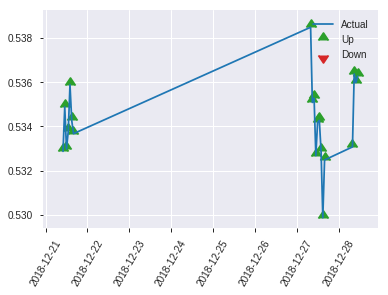


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24852404259755323
RMSE: 0.4985218576928731
LogLoss: 0.6901201946174623
Mean Per-Class Error: 0.4392109833760649
AUC: 0.5427177239268878
pr_auc: 0.5420995132730579
Gini: 0.08543544785377555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47024381880763627: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    107  0        (0.0/107.0)
Total  0    220  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470244     0.654434  76
max f2                       0.470244     0.825617  76
max f0point5                 0.470244     0.542047  76
max accuracy                 0.502174     0.568182  49
max precision                0.72773      1         0
max recall                   0.470244     1         76
max specificity              0.72773      1         0
max absolute_mcc             0.636608     0.166328  8
max min_per_class_accuracy   0.471621     0.383178  73
max mean_per_class_accuracy  0.502174     0.560789  49

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.659406           1.37072   1.37072            0.666667         0.685606  0.666667                    0.685606            0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.652599           2.05607   1.64486            1                0.653871  0.8                         0.672912            0.0186916       0.0373832                  105.607   64.486
    3        0.0318182                   0.647153           2.05607   1.76235            1                0.64908   0.857143                    0.666103            0.0186916       0.0560748                  105.607   76.235
    4        0.0409091                   0.636204           2.05607   1.82762            1                0.641749  0.888889                    0.660691            0.0186916       0.0747664                  105.607   82.7622
    5        0.05                        0.627629           0         1.49533            0                0.633749  0.727273                    0.655793            0               0.0747664                  -100      49.5327
    6        0.1                         0.587949           0.747664  1.1215             0.363636         0.607362  0.545455                    0.631578            0.0373832       0.11215                    -25.2336  12.1495
    7        0.15                        0.544055           0.934579  1.05919            0.454545         0.574392  0.515152                    0.612516            0.046729        0.158879                   -6.54206  5.919
    8        0.2                         0.519218           1.49533   1.16822            0.727273         0.534867  0.568182                    0.593104            0.0747664       0.233645                   49.5327   16.8224
    9        0.3                         0.478676           1.1215    1.15265            0.545455         0.494913  0.560606                    0.560373            0.11215         0.345794                   12.1495   15.2648
    10       1                           0.470244           0.934579  1                  0.454545         0.470498  0.486364                    0.497461            0.654206        1                          -6.54206  0

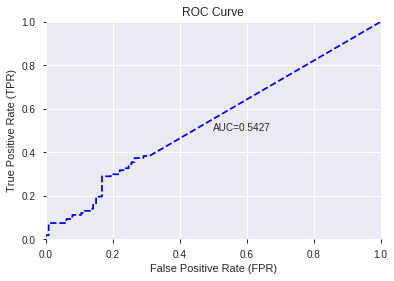

This function is available for GLM models only


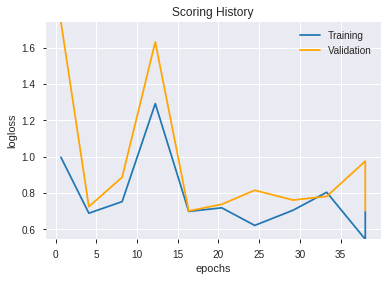

--2019-08-28 15:35:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_152707_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_152707_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['OBV',
 'HT_DCPERIOD',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'VAR_8',
 'NATR_14',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'aroonup_14',
 'BETA_14',
 'ADXR_12',
 'MOM_24',
 'TRIX_14',
 'CORREL_12',
 'PPO',
 'BETA_24',
 'CORREL_14',
 'dayofweek',
 'ADOSC',
 'STDDEV_30',
 'WILLR_12',
 'CDLDRAGONFLYDOJI',
 'BBANDS_lowerband_24_5_4',
 'MAVP_8_0',
 'BBANDS_upperband_8_5_2',
 'KAMA_12',
 'BBANDS_lowerband_24_6_5',
 'BBANDS_upperband_14_3_4',
 'PLUS_DI_8',
 'BBANDS_lowerband_30_5_4',
 'CDLUNIQUE3RIVER',
 'BBANDS_lowerband_24_7_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_middleband_14_5_2',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_middleband_14_6_3',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_24_2_3',
 'BBANDS_middleband_8_0_2',
 'WILLR_20',
 'BBANDS_upperband_30_5_3',
 'BBANDS_upperband_24_0_5',
 'BBANDS_upperband_14_5_2',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'MIDPOINT_12',
 'BBANDS_lowerband_24_1_4',
 'MA_14_2',
 'BBANDS_middleband_14_0_2']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_153511_model_1  0.490778  0.718639              0.473948  0.512334  0.262486

variable  relative_importance  scaled_importance  percentage
0                      VAR_8             0.006253           1.000000    0.046147
1                 aroonup_14             0.005444           0.870604    0.040175
2    BBANDS_upperband_14_3_4             0.004904           0.784336    0.036194
3               STOCHF_fastk             0.004805           0.768497    0.035464
4    BBANDS_upperband_14_5_2             0.004277           0.683999    0.031564
5            CDLUNIQUE3RIVER             0.003933           0.628974    0.029025
6     BBANDS_upperband_8_5_2             0.003876           0.619914    0.028607
7          CDLDARKCLOUDCOVER             0.003744           0.598775    0.027631
8         CDLEVENINGDOJISTAR             0.003586           0.573545    0.026467
9                        OBV             0.003493           0.558662    0.025780
10                  WILLR_12             0.003421           0.547076    0.025246
11   BBANDS_lowerband_30_5_4             0.003412           0.545646    0.025180
12   BBANDS_lowerband_30_2_2             0.003411           0.545576    0.025177
13   BBANDS_lowerband_30_2_5             0.003366           0.538354    0.024843
14  BBANDS_middleband_14_0_2             0.003340           0.534124    0.024648
15   BBANDS_upperband_24_2_3             0.003320           0.531019    0.024505
16  BBANDS_middleband_14_5_2             0.003320           0.530945    0.024501
17   BBANDS_middleband_8_0_2             0.003261           0.521489    0.024065
18                   MA_14_2             0.003247           0.519244    0.023961
19                   NATR_14             0.003188           0.509916    0.023531
20               MIDPOINT_12             0.003186           0.509456    0.023510
21                   KAMA_12             0.003154           0.504404    0.023277
22  BBANDS_middleband_14_6_3             0.003103           0.496269    0.022901
23                  MAVP_8_0             0.003021           0.483120    0.022294
24   BBANDS_upperband_24_0_5             0.002957           0.472905    0.021823
25   BBANDS_lowerband_24_7_3             0.002871           0.459101    0.021186
26            STOCHRSI_fastk             0.002821           0.451201    0.020821
27                AROONOSC_8             0.002778           0.444320    0.020504
28   BBANDS_lowerband_24_1_4             0.002706           0.432712    0.019968
29   BBANDS_lowerband_24_5_4             0.002631           0.420749    0.019416
30      HT_PHASOR_quadrature             0.002572           0.411388    0.018984
31   BBANDS_lowerband_20_1_2             0.002547           0.407397    0.018800
32   BBANDS_upperband_30_5_3             0.002396           0.383198    0.017683
33                  WILLR_20             0.002305           0.368688    0.017014
34   BBANDS_lowerband_24_6_5             0.002200           0.351797    0.016234
35                     ADOSC             0.001910           0.305424    0.014094
36                 CORREL_12             0.001905           0.304714    0.014062
37                 PLUS_DI_8             0.001627           0.260267    0.012010
38   BBANDS_lowerband_14_3_3             0.001534           0.245271    0.011318
39                 CORREL_14             0.001466           0.234381    0.010816
40                       PPO             0.001434           0.229344    0.010583
41                 STDDEV_30             0.001427           0.228265    0.010534
42                 dayofweek             0.001092           0.174620    0.008058
43                   ADXR_12             0.000991           0.158443    0.007312
44                   BETA_24             0.000986           0.157767    0.007280
45                    MOM_24             0.000801           0.128169    0.005915
46                   BETA_14             0.000545           0.087082    0.004019
47                   TRIX_14             0.000427           0.068300    0.003152
48               HT_DCPERIOD             0.000276  

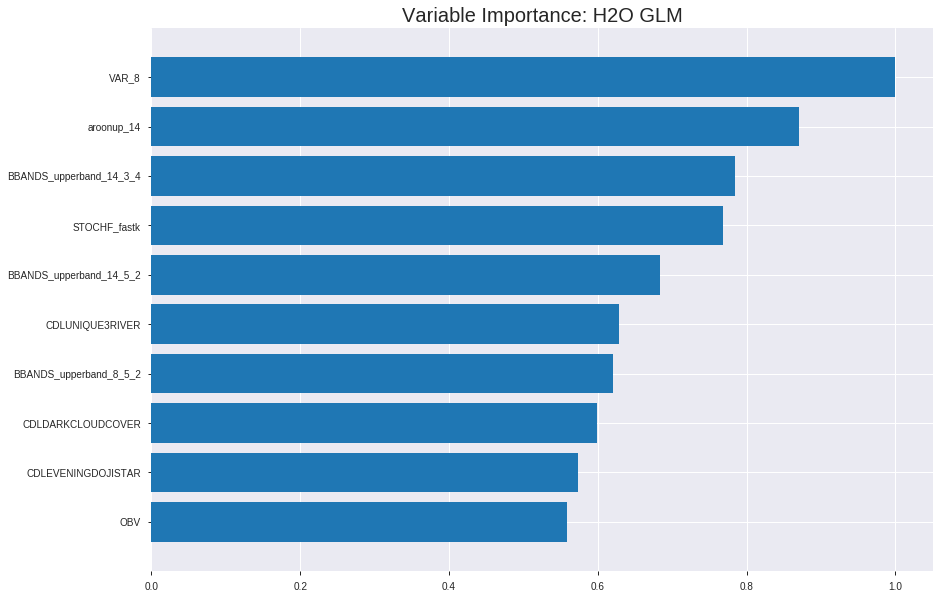

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153511_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2488993903391601
RMSE: 0.49889817632374656
LogLoss: 0.6909433052895994
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.187230760045
Residual deviance: 2123.9597204602283
AIC: 2225.9597204602283
AUC: 0.5446228035407583
pr_auc: 0.5486690351870913
Gini: 0.08924560708151663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4759892366443911: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    753   0.9987   (753.0/754.0)
1      0    783   0        (0.0/783.0)
Total  1    1536  0.4899   (753.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.475989     0.675291   398
max f2                       0.475989     0.838689   398
max f0point5                 0.491341     0.572978   326
max accuracy                 0.495119     0.543266   295
max precision                0.556434     1          0
max recall                   0.475989     1          398
max specificity              0.556434     1          0
max absolute_mcc             0.495119     0.0878938  295
max min_per_class_accuracy   0.507664     0.526525   215
max mean_per_class_accuracy  0.514649     0.540402   177

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.546156           1.22685   1.22685            0.625            0.548201  0.625                       0.548201            0.0127714       0.0127714                  22.6852    22.6852
    2        0.0201692                   0.544068           1.30864   1.26643            0.666667         0.544784  0.645161                    0.546548            0.0127714       0.0255428                  30.8642    26.6428
    3        0.0305791                   0.541836           0.858796  1.12766            0.4375           0.542899  0.574468                    0.545306            0.00893997      0.0344828                  -14.1204   12.766
    4        0.0403383                   0.539382           1.17778   1.13978            0.6              0.540817  0.580645                    0.54422             0.0114943       0.045977                   17.7778    13.9785
    5        0.0500976                   0.53766            1.17778   1.14719            0.6              0.538438  0.584416                    0.543093            0.0114943       0.0574713                  17.7778    14.7186
    6        0.100195                    0.532818           1.12169   1.13444            0.571429         0.535014  0.577922                    0.539054            0.0561941       0.113665                   12.1693    13.444
    7        0.150293                    0.530193           1.12169   1.13019            0.571429         0.5315    0.575758                    0.536536            0.0561941       0.16986                    12.1693    13.0191
    8        0.20039                     0.527307           0.994228  1.0962             0.506494         0.528775  0.558442                    0.534596            0.0498084       0.219668                   -0.577201  9.62001
    9        0.299935                    0.520269           1.01356   1.06877            0.51634          0.523575  0.544469                    0.530938            0.100894        0.320562                   1.3556     6.87716
    10       0.40013                     0.515225           1.15993   1.0916             0.590909         0.517693  0.556098                    0.527622            0.11622         0.436782                   15.9933    9.15989
    11       0.500325                    0.507681           0.892256  1.05168            0.454545         0.511739  0.535761                    0.524441            0.0893997       0.526181                   -10.7744   5.16785
    12       0.59987                     0.501659           1.02639   1.04748            0.522876         0.504548  0.533623                    0.52114             0.102171        0.628352                   2.63859    4.74813
    13       0.700065                    0.49646            1.05796   1.04898            0.538961         0.498693  0.534387                    0.517927            0.106003        0.734355                   5.79606    4.89811
    14       0.79961                     0.492432           0.885258  1.0286             0.45098          0.494481  0.524003                    0.515008            0.0881226       0.822478                   -11.4742   2.8599
    15       0.899805                    0.488051           0.84127   1.00774            0.428571         0.490434  0.513377                    0.512272            0.0842912       0.906769                   -15.873    0.773948
    16       1                           0.47573            0.930495  1                  0.474026         0.483948  0.509434                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25589862161260757
RMSE: 0.505864232391071
LogLoss: 0.7050696766532749
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 610.5035894343387
Residual deviance: 620.461315454882
AIC: 722.461315454882
AUC: 0.5110077519379845
pr_auc: 0.49485782588608596
Gini: 0.022015503875969067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5326008166193235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    215  0        (0.0/215.0)
Total  1    439  0.5091   (224.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.532601     0.657492   398
max f2                       0.532601     0.82756    398
max f0point5                 0.540734     0.547345   363
max accuracy                 0.561437     0.531818   241
max precision                0.588605     0.6875     14
max recall                   0.532601     1          398
max specificity              0.619475     0.995556   0
max absolute_mcc             0.588081     0.0886608  20
max min_per_class_accuracy   0.570407     0.511111   188
max mean_per_class_accuracy  0.561341     0.53478    243

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 56.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.591357           0.818605  0.818605           0.4              0.601233  0.4                         0.601233            0.00930233      0.00930233                 -18.1395  -18.1395
    2        0.0204545                   0.589604           1.53488   1.13695            0.75             0.590497  0.555556                    0.596461            0.0139535       0.0232558                  53.4884   13.6951
    3        0.0318182                   0.588837           1.63721   1.31561            0.8              0.589298  0.642857                    0.593903            0.0186047       0.0418605                  63.7209   31.5615
    4        0.0409091                   0.588318           1.53488   1.36434            0.75             0.58852   0.666667                    0.592707            0.0139535       0.055814                   53.4884   36.4341
    5        0.05                        0.588012           1.53488   1.39535            0.75             0.588151  0.681818                    0.591878            0.0139535       0.0697674                  53.4884   39.5349
    6        0.1                         0.584909           0.837209  1.11628            0.409091         0.586408  0.545455                    0.589143            0.0418605       0.111628                   -16.2791  11.6279
    7        0.15                        0.582253           0.372093  0.868217           0.181818         0.583781  0.424242                    0.587356            0.0186047       0.130233                   -62.7907  -13.1783
    8        0.2                         0.579869           0.930233  0.883721           0.454545         0.581169  0.431818                    0.585809            0.0465116       0.176744                   -6.97674  -11.6279
    9        0.3                         0.576467           1.11628   0.96124            0.545455         0.578172  0.469697                    0.583264            0.111628        0.288372                   11.6279   -3.87597
    10       0.4                         0.573809           1.11628   1                  0.545455         0.575358  0.488636                    0.581287            0.111628        0.4                        11.6279   0
    11       0.5                         0.570389           1.11628   1.02326            0.545455         0.572019  0.5                         0.579433            0.111628        0.511628                   11.6279   2.32558
    12       0.6                         0.562209           1.16279   1.04651            0.568182         0.566588  0.511364                    0.577293            0.116279        0.627907                   16.2791   4.65116
    13       0.7                         0.558808           0.930233  1.0299             0.454545         0.560568  0.503247                    0.574903            0.0930233       0.72093                    -6.97674  2.99003
    14       0.8                         0.550793           0.883721  1.01163            0.431818         0.554609  0.494318                    0.572367            0.0883721       0.809302                   -11.6279  1.16279
    15       0.9                         0.541639           0.976744  1.00775            0.477273         0.546567  0.492424                    0.5695              0.0976744       0.906977                   -2.32558  0.775194
    16       1                           0.532497           0.930233  1                  0.454545         0.537196  0.488636                    0.566269          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:35:12  0.000 sec   2            3.1       51            1.38189           1.41014
    2019-08-28 15:35:12  0.026 sec   4            2         51            1.3809            1.41774
    2019-08-28 15:35:12  0.053 sec   6            1.2       51            1.37971           1.42568
    2019-08-28 15:35:12  0.079 sec   8            0.75      51            1.37824           1.43391
    2019-08-28 15:35:12  0.102 sec   10           0.47      51            1.37652           1.44206

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5363636363636364)

('F1', 0.6624605678233438)

('auc', 0.49077826482507647)

('logloss', 0.7186391166256003)

('mean_per_class_error', 0.4616657017616409)

('rmse', 0.5123336444053052)

('mse', 0.2624857631896217)

glm prediction progress: |████████████████████████████████████████████████| 100%


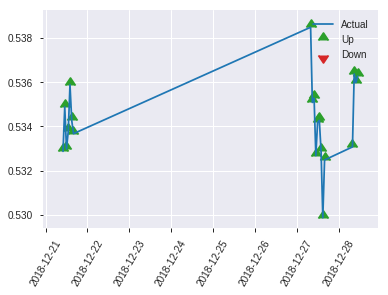


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2624857631896217
RMSE: 0.5123336444053052
LogLoss: 0.7186391166256003
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.28953504515266
Residual deviance: 316.2012113152641
AIC: 418.2012113152641
AUC: 0.49077826482507647
pr_auc: 0.49999754469598956
Gini: -0.018443470349847058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5749225133806043: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    105  0.9292   (105.0/113.0)
1      2    105  0.0187   (2.0/107.0)
Total  10   210  0.4864   (107.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.574923     0.662461  209
max f2                       0.569735     0.825617  219
max f0point5                 0.576698     0.559247  198
max accuracy                 0.627608     0.536364  8
max precision                0.631633     1         0
max recall                   0.569735     1         219
max specificity              0.631633     1         0
max absolute_mcc             0.628244     0.139846  3
max min_per_class_accuracy   0.590033     0.477876  110
max mean_per_class_accuracy  0.576698     0.538334  198

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 59.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.628602           2.05607   2.05607            1                0.630381  1                           0.630381            0.0280374       0.0280374                  105.607   105.607
    2        0.0227273                   0.628204           1.02804   1.64486            0.5              0.62823   0.8                         0.62952             0.00934579      0.0373832                  2.80374   64.486
    3        0.0318182                   0.627851           1.02804   1.46862            0.5              0.628061  0.714286                    0.629104            0.00934579      0.046729                   2.80374   46.8625
    4        0.0409091                   0.627211           2.05607   1.59917            1                0.627697  0.777778                    0.628791            0.0186916       0.0654206                  105.607   59.9169
    5        0.05                        0.626853           1.02804   1.49533            0.5              0.627072  0.727273                    0.628478            0.00934579      0.0747664                  2.80374   49.5327
    6        0.1                         0.621787           0.560748  1.02804            0.272727         0.624427  0.5                         0.626453            0.0280374       0.102804                   -43.9252  2.80374
    7        0.15                        0.619546           1.1215    1.05919            0.545455         0.620795  0.515152                    0.624567            0.0560748       0.158879                   12.1495   5.919
    8        0.2                         0.614597           0.373832  0.88785            0.181818         0.617465  0.431818                    0.622791            0.0186916       0.17757                    -62.6168  -11.215
    9        0.3                         0.605059           1.02804   0.934579           0.5              0.6097    0.454545                    0.618427            0.102804        0.280374                   2.80374   -6.54206
    10       0.4                         0.596649           0.934579  0.934579           0.454545         0.600385  0.454545                    0.613917            0.0934579       0.373832                   -6.54206  -6.54206
    11       0.5                         0.590235           1.02804   0.953271           0.5              0.593331  0.463636                    0.6098              0.102804        0.476636                   2.80374   -4.6729
    12       0.6                         0.586845           1.30841   1.01246            0.636364         0.588688  0.492424                    0.606281            0.130841        0.607477                   30.8411   1.24611
    13       0.7                         0.583182           1.02804   1.01469            0.5              0.584712  0.493506                    0.6032              0.102804        0.71028                    2.80374   1.46862
    14       0.8                         0.58038            0.841121  0.992991           0.409091         0.58195   0.482955                    0.600543            0.0841121       0.794393                   -15.8879  -0.700935
    15       0.9                         0.57671            1.40187   1.03842            0.681818         0.578402  0.505051                    0.598083            0.140187        0.934579                   40.1869   3.84216
    16       1                           0.569735           0.654206  1                  0.318182         0.574684  0.486364                    0.595743        

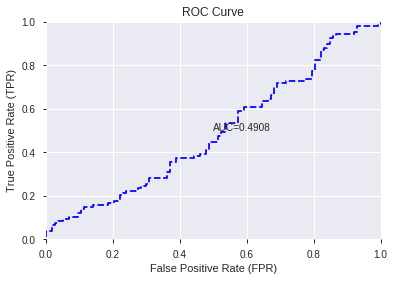

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


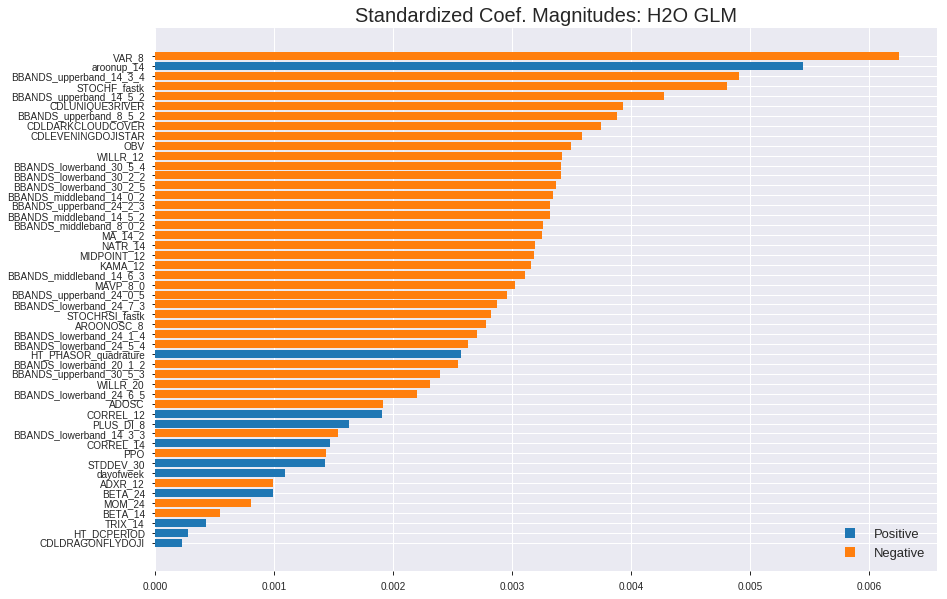

'log_likelihood'
--2019-08-28 15:35:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.204
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.204|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153511_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153511_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['VAR_8',
 'aroonup_14',
 'BBANDS_upperband_14_3_4',
 'STOCHF_fastk',
 'BBANDS_upperband_14_5_2',
 'CDLUNIQUE3RIVER',
 'BBANDS_upperband_8_5_2',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'OBV',
 'WILLR_12',
 'BBANDS_lowerband_30_5_4',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_middleband_14_0_2',
 'BBANDS_upperband_24_2_3',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_8_0_2',
 'MA_14_2',
 'NATR_14',
 'MIDPOINT_12',
 'KAMA_12',
 'BBANDS_middleband_14_6_3',
 'MAVP_8_0',
 'BBANDS_upperband_24_0_5',
 'BBANDS_lowerband_24_7_3',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_24_5_4',
 'HT_PHASOR_quadrature',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_30_5_3',
 'WILLR_20',
 'BBANDS_lowerband_24_6_5',
 'ADOSC',
 'CORREL_12',
 'PLUS_DI_8',
 'BBANDS_lowerband_14_3_3',
 'CORREL_14',
 'PPO',
 'STDDEV_30',
 'dayofweek',
 'ADXR_12',
 'BETA_24',
 'MOM_24',
 'BETA_14',
 'TRIX_14',
 'HT_DCPERIOD',
 'CDLDRAGONFLYDOJI']

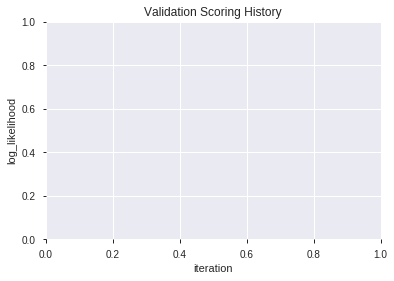

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_153528_model_5  0.565627  0.726428              0.486974  0.514482  0.264692
1  XGBoost_grid_1_AutoML_20190828_153528_model_3  0.480936  0.726850              0.500000  0.515975  0.266230
2  XGBoost_grid_1_AutoML_20190828_153528_model_4  0.476139  0.719288              0.500000  0.512481  0.262637
3  XGBoost_grid_1_AutoML_20190828_153528_model_1  0.474940  0.735829              0.486726  0.519990  0.270389
4               XGBoost_1_AutoML_20190828_153528  0.471425  0.715198              0.500000  0.510580  0.260692
5               XGBoost_3_AutoML_20190828_153528  0.467703  0.726115              0.500000  0.515676  0.265921
6  XGBoost_grid_1_AutoML_20190828_153528_model_6  0.454015  0.746665              0.487222  0.524815  0.275431
7  XGBoost_grid_1_AutoML_20190828_153528_model_2  0.444297  0.712214              0.491150  0.509271  0.259357
8               XGBoost_2_AutoML_20190828_153528  0.440576  0.727975              0.500000  0.516578  0.266853
9  XGBoost_grid_1_AutoML_20190828_153528_model_7  0.424531  0.739257              0.495575  0.521538  0.272002

variable  relative_importance  scaled_importance  percentage
0                  PLUS_DI_8           895.745728           1.000000    0.041680
1                        OBV           774.224365           0.864335    0.036026
2                      VAR_8           764.841492           0.853860    0.035589
3       HT_PHASOR_quadrature           758.565308           0.846853    0.035297
4                    ADXR_12           753.256287           0.840926    0.035050
5               STOCHF_fastk           748.569397           0.835694    0.034832
6                HT_DCPERIOD           745.588928           0.832367    0.034693
7                   WILLR_20           737.470642           0.823304    0.034315
8                    TRIX_14           706.875488           0.789147    0.032892
9                      ADOSC           699.953186           0.781420    0.032570
10                  WILLR_12           653.802734           0.729898    0.030422
11                   BETA_24           643.713501           0.718634    0.029953
12                  MAVP_8_0           641.269714           0.715906    0.029839
13                   BETA_14           630.812073           0.704231    0.029352
14                    MOM_24           627.065308           0.700048    0.029178
15   BBANDS_upperband_14_3_4           603.086609           0.673279    0.028062
16                   NATR_14           574.582397           0.641457    0.026736
17                       PPO           550.192017           0.614228    0.025601
18    BBANDS_upperband_8_5_2           545.301575           0.608768    0.025374
19                 CORREL_14           528.846741           0.590398    0.024608
20                AROONOSC_8           486.393524           0.543004    0.022632
21                 STDDEV_30           484.320007           0.540689    0.022536
22   BBANDS_middleband_8_0_2           476.144928           0.531563    0.022156
23   BBANDS_upperband_24_0_5           464.533539           0.518600    0.021615
24   BBANDS_upperband_14_5_2           437.705811           0.488650    0.020367
25   BBANDS_lowerband_24_5_4           412.682129           0.460713    0.019203
26            STOCHRSI_fastk           373.960938           0.417486    0.017401
27                aroonup_14           370.243439           0.413335    0.017228
28   BBANDS_lowerband_24_1_4           361.993744           0.404126    0.016844
29   BBANDS_lowerband_14_3_3           337.886963           0.377213    0.015722
30                 CORREL_12           323.354065           0.360989    0.015046
31   BBANDS_upperband_30_5_3           307.256744           0.343018    0.014297
32   BBANDS_upperband_24_2_3           297.495789           0.332121    0.013843
33   BBANDS_lowerband_24_6_5           293.332489           0.327473    0.013649
34   BBANDS_lowerband_30_2_5           278.561188           0.310982    0.012962
35   BBANDS_lowerband_30_5_4           267.416870           0.298541    0.012443
36                   KAMA_12           256.082367           0.285887    0.011916
37  BBANDS_middleband_14_0_2           255.201843           0.284904    0.011875
38                 dayofweek           228.030472           0.254571    0.010611
39               MIDPOINT_12           204.286560           0.228063    0.009506
40   BBANDS_lowerband_20_1_2           201.858551           0.225353    0.009393
41                   MA_14_2           178.263641           0.199011    0.008295
42   BBANDS_lowerband_24_7_3           174.872284           0.195225    0.008137
43   BBANDS_lowerband_30_2_2           155.657379           0.173774    0.007243
44  BBANDS_middleband_14_5_2           134.557083           0.150218    0.006261
45  BBANDS_middleband_14_6_3           121.115623           0.135212    0.005636
46          CDLDRAGONFLYDOJI            13.716861           0.015313    0.000638
47         CDLDARKCLOUDCOVER            10.298822           0.011497    0.000479

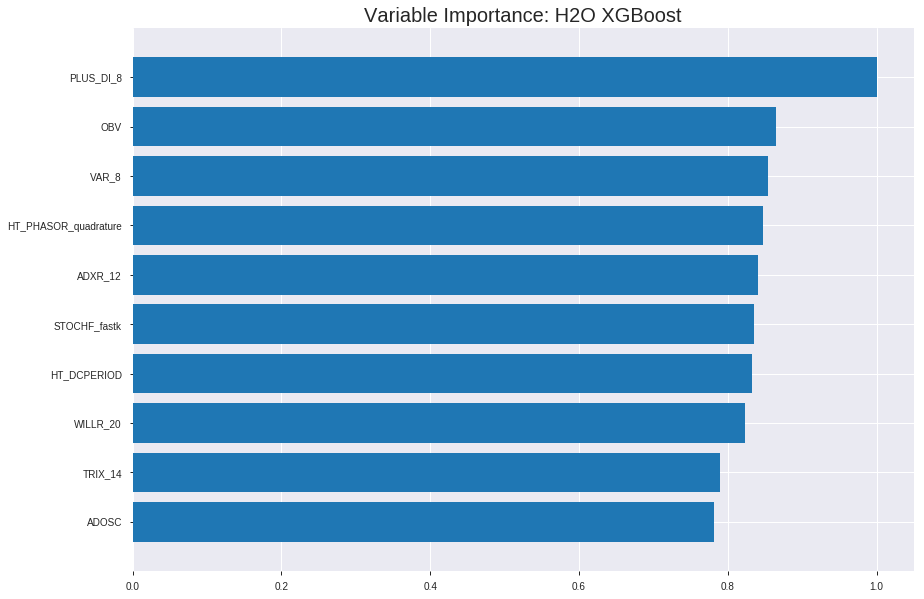

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_153528_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04721999857352238
RMSE: 0.21730163039775469
LogLoss: 0.23373975674231676
Mean Per-Class Error: 0.0006631299734747298
AUC: 0.9999906839978183
pr_auc: 0.9974367307447656
Gini: 0.9999813679956366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5346661806106567: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      753  1    0.0013   (1.0/754.0)
1      0    783  0        (0.0/783.0)
Total  753  784  0.0007   (1.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534666     0.999362  198
max f2                       0.534666     0.999745  198
max f0point5                 0.534666     0.998979  198
max accuracy                 0.534666     0.999349  198
max precision                0.917612     1         0
max recall                   0.534666     1         198
max specificity              0.917612     1         0
max absolute_mcc             0.534666     0.998699  198
max min_per_class_accuracy   0.555904     0.998674  197
max mean_per_class_accuracy  0.534666     0.999337  198

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.906837           1.96296   1.96296            1                0.912096  1                           0.912096            0.0204342       0.0204342                  96.2963   96.2963
    2        0.0201692                   0.89747            1.96296   1.96296            1                0.901857  1                           0.907142            0.0191571       0.0395913                  96.2963   96.2963
    3        0.0305791                   0.888905           1.96296   1.96296            1                0.894399  1                           0.902804            0.0204342       0.0600255                  96.2963   96.2963
    4        0.0403383                   0.882918           1.96296   1.96296            1                0.885892  1                           0.898712            0.0191571       0.0791826                  96.2963   96.2963
    5        0.0500976                   0.878701           1.96296   1.96296            1                0.880437  1                           0.895152            0.0191571       0.0983397                  96.2963   96.2963
    6        0.100195                    0.859386           1.96296   1.96296            1                0.868671  1                           0.881912            0.0983397       0.196679                   96.2963   96.2963
    7        0.150293                    0.842954           1.96296   1.96296            1                0.85075   1                           0.871525            0.0983397       0.295019                   96.2963   96.2963
    8        0.20039                     0.828523           1.96296   1.96296            1                0.835263  1                           0.862459            0.0983397       0.393359                   96.2963   96.2963
    9        0.299935                    0.796908           1.96296   1.96296            1                0.813022  1                           0.846052            0.195402        0.588761                   96.2963   96.2963
    10       0.40013                     0.746226           1.96296   1.96296            1                0.77414   1                           0.828045            0.196679        0.785441                   96.2963   96.2963
    11       0.500325                    0.614321           1.96296   1.96296            1                0.704118  1                           0.803227            0.196679        0.98212                    96.2963   96.2963
    12       0.59987                     0.270687           0.179618  1.66703            0.0915033        0.356828  0.849241                    0.72915             0.0178799       1                          -82.0382  66.7028
    13       0.700065                    0.216737           0         1.42844            0                0.239225  0.727695                    0.659031            0               1                          -100      42.8439
    14       0.79961                     0.179443           0         1.25061            0                0.198091  0.637103                    0.601648            0               1                          -100      25.061
    15       0.899805                    0.148567           0         1.11135            0                0.164921  0.566161                    0.553017            0               1                          -100      11.1352
    16       1                           0.0744252          0         1                  0                0.122681  0.509434                    0.5099            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2673002312160575
RMSE: 0.5170108617969815
LogLoss: 0.7312048618448885
Mean Per-Class Error: 0.46516795865633076
AUC: 0.539328165374677
pr_auc: 0.5350613623937566
Gini: 0.07865633074935396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43155741691589355: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   211  0.9378   (211.0/225.0)
1      5    210  0.0233   (5.0/215.0)
Total  19   421  0.4909   (216.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431557     0.660377  380
max f2                       0.335795     0.82756   398
max f0point5                 0.442477     0.55318   373
max accuracy                 0.730072     0.543182  51
max precision                0.776189     0.736842  18
max recall                   0.335795     1         398
max specificity              0.843717     0.995556  0
max absolute_mcc             0.763898     0.113601  24
max min_per_class_accuracy   0.617044     0.525581  199
max mean_per_class_accuracy  0.728697     0.534832  53

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 61.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.813677           1.22791   1.22791            0.6              0.828215  0.6                         0.828215            0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.795737           1.53488   1.36434            0.75             0.806667  0.666667                    0.818638            0.0139535       0.027907                   53.4884   36.4341
    3        0.0318182                   0.782834           1.63721   1.46179            0.8              0.787994  0.714286                    0.807694            0.0186047       0.0465116                  63.7209   46.1794
    4        0.0409091                   0.776952           1.53488   1.47804            0.75             0.779946  0.722222                    0.801527            0.0139535       0.0604651                  53.4884   47.8036
    5        0.05                        0.765424           1.02326   1.39535            0.5              0.772138  0.681818                    0.796184            0.00930233      0.0697674                  2.32558   39.5349
    6        0.1                         0.740432           1.2093    1.30233            0.590909         0.752477  0.636364                    0.77433             0.0604651       0.130233                   20.9302   30.2326
    7        0.15                        0.718028           1.02326   1.2093             0.5              0.729857  0.590909                    0.759506            0.0511628       0.181395                   2.32558   20.9302
    8        0.2                         0.702928           0.930233  1.13953            0.454545         0.712025  0.556818                    0.747636            0.0465116       0.227907                   -6.97674  13.9535
    9        0.3                         0.665719           0.976744  1.08527            0.477273         0.685608  0.530303                    0.72696             0.0976744       0.325581                   -2.32558  8.52713
    10       0.4                         0.641627           0.930233  1.04651            0.454545         0.654491  0.511364                    0.708843            0.0930233       0.418605                   -6.97674  4.65116
    11       0.5                         0.616236           1.06977   1.05116            0.522727         0.62922   0.513636                    0.692918            0.106977        0.525581                   6.97674   5.11628
    12       0.6                         0.59277            0.930233  1.03101            0.454545         0.605005  0.503788                    0.678266            0.0930233       0.618605                   -6.97674  3.10078
    13       0.7                         0.564823           0.976744  1.02326            0.477273         0.578438  0.5                         0.664005            0.0976744       0.716279                   -2.32558  2.32558
    14       0.8                         0.534141           0.930233  1.01163            0.454545         0.549393  0.494318                    0.649678            0.0930233       0.809302                   -6.97674  1.16279
    15       0.9                         0.484634           0.976744  1.00775            0.477273         0.512577  0.492424                    0.634445            0.0976744       0.906977                   -2.32558  0.775194
    16       1                           0.258971           0.930233  1                  0.454545         0.429406  0.488636                    0.613941        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:35:37  4.103 sec   0                  0.5              0.693147            0.5             0                  1                0.490566                         0.5                0.693147              0.5               0                    1                  0.511364
    2019-08-28 15:35:38  4.444 sec   5                  0.455452         0.60744             0.949           0.945279           1.96296          0.104099                         0.500657           0.694447              0.519824          0.497964             2.04651            0.511364
    2019-08-28 15:35:38  4.756 sec   10                 0.416732         0.537851            0.987396        0.983672           1.96296          0.0481457                        0.503139           0.699504              0.512796          0.513623             1.63721            0.506818
    2019-08-28 15:35:38  5.055 sec   15                 0.377687         0.471508            0.995896        0.994713           1.96296          0.0279766                        0.510489           0.715122              0.518522          0.503917             0.818605           0.506818
    2019-08-28 15:35:39  5.399 sec   20                 0.345073         0.418877            0.998321        0.997126           1.96296          0.0182173                        0.508242           0.710532              0.531876          0.517609             1.22791            0.509091
    2019-08-28 15:35:39  5.735 sec   25                 0.317928         0.376864            0.999212        0.99798            1.96296          0.0123617                        0.512785           0.720569              0.530336          0.518921             1.22791            0.506818
    2019-08-28 15:35:39  6.073 sec   30                 0.296057         0.343682            0.999471        0.998213           1.96296          0.0110605                        0.513222           0.721582              0.526863          0.526492             1.22791            0.511364
    2019-08-28 15:35:40  6.434 sec   35                 0.273476         0.31114             0.999812        0.997264           1.96296          0.00650618                       0.511931           0.718975              0.531638          0.528333             1.63721            0.493182
    2019-08-28 15:35:40  6.811 sec   40                 0.252253         0.281077            0.999947        0.998672           1.96296          0.00260247                       0.514363           0.724632              0.537199          0.533814             1.22791            0.509091
    2019-08-28 15:35:40  7.192 sec   45                 0.233387         0.255191            0.99998         0.997426           1.96296          0.00130124                       0.517122           0.731095              0.534915          0.531831             1.22791            0.506818
    2019-08-28 15:35:41  7.584 sec   50                 0.217302         0.23374             0.999991        0.997437           1.96296          0.000650618                      0.517011           0.731205              0.539328          0.535061             1.22791            0.490909

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
PLUS_DI_8                 895.7457275390625      1.0                   0.04168006437474381
OBV                       774.224365234375       0.8643349797061822    0.03602553759549656
VAR_8                     764.8414916992188      0.8538600499948964    0.03558894185080925
HT_PHASOR_quadrature      758.5653076171875      0.8468533918674005    0.035296903889003396
ADXR_12                   753.2562866210938      0.8409264632392511    0.03504986912223762
---                       ---                    ---                   ---
BBANDS_lowerband_30_2_2   155.65737915039062     0.17377406820352662   0.007242914349384111
BBANDS_middleband_14_5_2  134.5570831298828      0.15021794577749178   0.0062610936502476315
BBANDS_middleband_14_6_3  121.1156234741211      0.1352120582331657    0.005635647291399954
CDLDRAGONFLYDOJI          13.7168607711792       0.015313342112012499  0.0006382610850211562
CDLDARKCLOUDCOVER         10.298822402954102     0.011497484259566263  0.0004792158840863255


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6583850931677019)

('auc', 0.5656273261103301)

('logloss', 0.7264281590467437)

('mean_per_class_error', 0.41750062029608803)

('rmse', 0.5144818505002121)

('mse', 0.2646915744941226)

xgboost prediction progress: |████████████████████████████████████████████| 100%


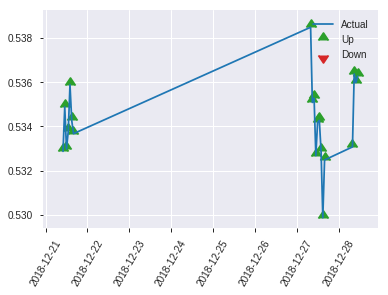


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2646915744941226
RMSE: 0.5144818505002121
LogLoss: 0.7264281590467437
Mean Per-Class Error: 0.41750062029608803
AUC: 0.5656273261103301
pr_auc: 0.5140627766898421
Gini: 0.13125465222066013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44942352175712585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    109  0.9646   (109.0/113.0)
1      1    106  0.0093   (1.0/107.0)
Total  5    215  0.5      (110.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449424     0.658385  214
max f2                       0.415498     0.825617  219
max f0point5                 0.570516     0.579915  149
max accuracy                 0.611743     0.581818  110
max precision                0.705936     0.612903  30
max recall                   0.415498     1         219
max specificity              0.807076     0.99115   0
max absolute_mcc             0.570516     0.176615  149
max min_per_class_accuracy   0.615882     0.575221  109
max mean_per_class_accuracy  0.609963     0.582499  114

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 61.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.791853           0.685358  0.685358           0.333333         0.800051  0.333333                    0.800051            0.00934579      0.00934579                 -31.4642  -31.4642
    2        0.0227273                   0.77957            1.02804   0.82243            0.5              0.78644   0.4                         0.794607            0.00934579      0.0186916                  2.80374   -17.757
    3        0.0318182                   0.764345           1.02804   0.881175           0.5              0.771452  0.428571                    0.787991            0.00934579      0.0280374                  2.80374   -11.8825
    4        0.0409091                   0.761253           0         0.685358           0                0.761619  0.333333                    0.782131            0               0.0280374                  -100      -31.4642
    5        0.05                        0.754313           1.02804   0.747664           0.5              0.758027  0.363636                    0.777748            0.00934579      0.0373832                  2.80374   -25.2336
    6        0.1                         0.716002           1.30841   1.02804            0.636364         0.737111  0.5                         0.75743             0.0654206       0.102804                   30.8411   2.80374
    7        0.15                        0.702276           1.49533   1.1838             0.727273         0.71018   0.575758                    0.74168             0.0747664       0.17757                    49.5327   18.3801
    8        0.2                         0.68914            0.934579  1.1215             0.454545         0.695663  0.545455                    0.730175            0.046729        0.224299                   -6.54206  12.1495
    9        0.3                         0.66184            1.02804   1.09034            0.5              0.674507  0.530303                    0.711619            0.102804        0.327103                   2.80374   9.03427
    10       0.4                         0.639825           0.934579  1.0514             0.454545         0.653728  0.511364                    0.697146            0.0934579       0.420561                   -6.54206  5.14019
    11       0.5                         0.613813           1.58879   1.15888            0.772727         0.629226  0.563636                    0.683562            0.158879        0.579439                   58.8785   15.8879
    12       0.6                         0.592539           0.934579  1.1215             0.454545         0.603355  0.545455                    0.670194            0.0934579       0.672897                   -6.54206  12.1495
    13       0.7                         0.566167           1.02804   1.10814            0.5              0.577551  0.538961                    0.65696             0.102804        0.775701                   2.80374   10.8144
    14       0.8                         0.528704           0.654206  1.0514             0.318182         0.553031  0.511364                    0.643969            0.0654206       0.841121                   -34.5794  5.14019
    15       0.9                         0.49738            0.654206  1.00727            0.318182         0.516756  0.489899                    0.629834            0.0654206       0.906542                   -34.5794  0.726895
    16       1                           0.415498           0.934579  1                  0.454545         0.465279  0.486364                    0.613378    

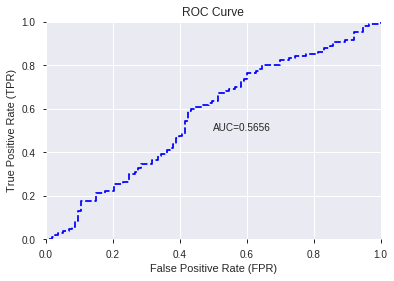

This function is available for GLM models only


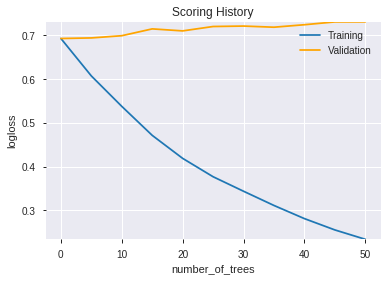

--2019-08-28 15:35:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_153528_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_153528_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['PLUS_DI_8',
 'OBV',
 'VAR_8',
 'HT_PHASOR_quadrature',
 'ADXR_12',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'WILLR_20',
 'TRIX_14',
 'ADOSC',
 'WILLR_12',
 'BETA_24',
 'MAVP_8_0',
 'BETA_14',
 'MOM_24',
 'BBANDS_upperband_14_3_4',
 'NATR_14',
 'PPO',
 'BBANDS_upperband_8_5_2',
 'CORREL_14',
 'AROONOSC_8',
 'STDDEV_30',
 'BBANDS_middleband_8_0_2',
 'BBANDS_upperband_24_0_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_24_5_4',
 'STOCHRSI_fastk',
 'aroonup_14',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_14_3_3',
 'CORREL_12',
 'BBANDS_upperband_30_5_3',
 'BBANDS_upperband_24_2_3',
 'BBANDS_lowerband_24_6_5',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_lowerband_30_5_4',
 'KAMA_12',
 'BBANDS_middleband_14_0_2',
 'dayofweek',
 'MIDPOINT_12',
 'BBANDS_lowerband_20_1_2',
 'MA_14_2',
 'BBANDS_lowerband_24_7_3',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_14_6_3',
 'CDLDRAGONFLYDOJI',
 'CDLDARKCLOUDCOVER']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_153556_model_1  0.493259  0.753084              0.478124  0.527564  0.278324

variable  relative_importance  scaled_importance    percentage
0                       TRANGE         6.435242e-03           1.000000  7.920561e-03
1          CDLXSIDEGAP3METHODS         6.403807e-03           0.995115  7.881871e-03
2               CDLMORNINGSTAR         5.875969e-03           0.913092  7.232202e-03
3                          DIV         5.837704e-03           0.907146  7.185105e-03
4                          SUB         5.629827e-03           0.874843  6.929248e-03
...                        ...                  ...                ...           ...
1031  BBANDS_middleband_14_4_3         1.833535e-06           0.000285  2.256733e-06
1032                     MIN_8         8.009712e-07           0.000124  9.858435e-07
1033              MINMAX_min_8         7.660284e-07           0.000119  9.428355e-07
1034  BBANDS_middleband_14_2_5         5.701918e-07           0.000089  7.017978e-07
1035  BBANDS_middleband_14_4_4         3.499878e-07           0.000054  4.307685e-07

[1036 rows x 4 columns]

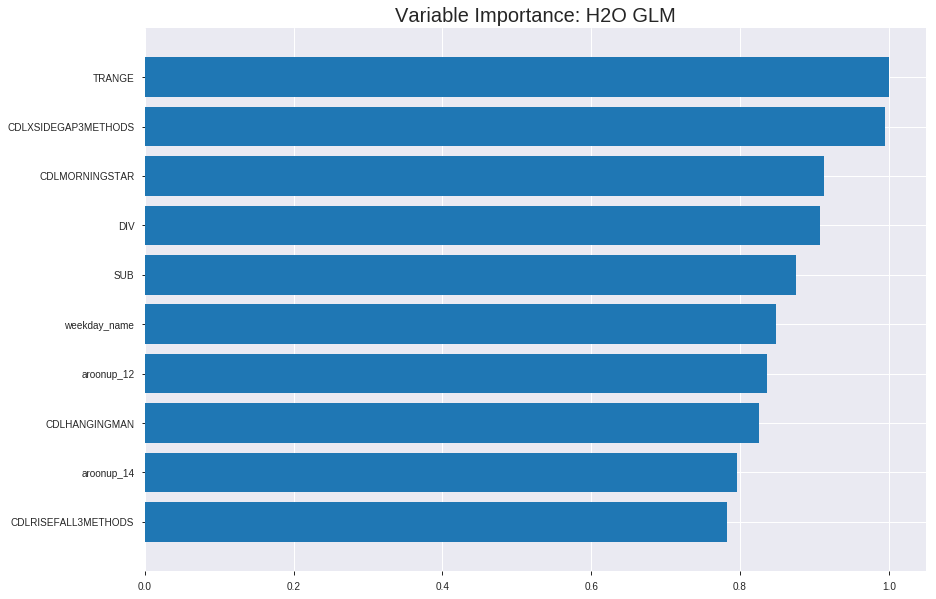

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153556_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24617059162683635
RMSE: 0.4961558138597555
LogLoss: 0.6854603130612522
Null degrees of freedom: 1536
Residual degrees of freedom: 500
Null deviance: 2130.187230760045
Residual deviance: 2107.1050023502894
AIC: 4181.105002350289
AUC: 0.584532556886897
pr_auc: 0.5788993647182676
Gini: 0.16906511377379396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4484157820133131: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   730   0.9682   (730.0/754.0)
1      4    779   0.0051   (4.0/783.0)
Total  28   1509  0.4776   (734.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448416     0.679756  377
max f2                       0.448416     0.839259  377
max f0point5                 0.489724     0.58673   264
max accuracy                 0.498524     0.56864   233
max precision                0.614319     1         0
max recall                   0.3953       1         399
max specificity              0.614319     1         0
max absolute_mcc             0.489724     0.138624  264
max min_per_class_accuracy   0.507861     0.543767  202
max mean_per_class_accuracy  0.498524     0.56678   233

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.585766           1.34954   1.34954            0.6875           0.594301  0.6875                      0.594301            0.0140485       0.0140485                  34.9537   34.9537
    2        0.0201692                   0.575091           1.17778   1.26643            0.6              0.579845  0.645161                    0.587306            0.0114943       0.0255428                  17.7778   26.6428
    3        0.0305791                   0.571245           1.47222   1.33649            0.75             0.57332   0.680851                    0.582545            0.0153257       0.0408685                  47.2222   33.6485
    4        0.0403383                   0.565247           0.785185  1.20311            0.4              0.568204  0.612903                    0.579075            0.00766284      0.0485313                  -21.4815  20.3106
    5        0.0500976                   0.562051           1.17778   1.19817            0.6              0.563755  0.61039                     0.576091            0.0114943       0.0600255                  17.7778   19.8172
    6        0.100195                    0.551967           1.27465   1.23641            0.649351         0.556241  0.62987                     0.566166            0.063857        0.123883                   27.4651   23.6412
    7        0.150293                    0.544352           1.27465   1.24916            0.649351         0.548073  0.636364                    0.560135            0.063857        0.187739                   27.4651   24.9158
    8        0.20039                     0.538552           1.0962    1.21092            0.558442         0.541254  0.616883                    0.555415            0.054917        0.242656                   9.62001   21.0919
    9        0.299935                    0.527147           1.10336   1.17522            0.562092         0.533159  0.598698                    0.548028            0.109834        0.35249                    10.3365   17.5223
    10       0.40013                     0.518465           0.981481  1.12671            0.5              0.522965  0.573984                    0.541752            0.0983397       0.45083                    -1.85185  12.6709
    11       0.500325                    0.507864           0.917749  1.08486            0.467532         0.512806  0.552666                    0.535955            0.091954        0.542784                   -8.22511  8.48625
    12       0.59987                     0.498279           1.23166   1.10922            0.627451         0.502883  0.565076                    0.530467            0.122605        0.66539                    23.1663   10.9223
    13       0.700065                    0.48943            0.968735  1.08912            0.493506         0.493552  0.554833                    0.525184            0.0970626       0.762452                   -3.1265   8.91161
    14       0.79961                     0.481558           0.872428  1.06214            0.444444         0.485159  0.54109                     0.520201            0.0868455       0.849298                   -12.7572  6.21403
    15       0.899805                    0.469798           0.752044  1.02761            0.383117         0.476457  0.5235                      0.51533             0.0753512       0.924649                   -24.7956  2.76104
    16       1                           0.3953             0.752044  1                  0.383117         0.456484  0.509434                    0.509434         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2623371901742229
RMSE: 0.5121886275330827
LogLoss: 0.7185215359282108
Null degrees of freedom: 439
Residual degrees of freedom: -597
Null deviance: 610.5035894343387
Residual deviance: 632.2989516168254
AIC: 2706.2989516168254
AUC: 0.5137674418604651
pr_auc: 0.49526339448979784
Gini: 0.02753488372093016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5351233780987066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    220  0.9778   (220.0/225.0)
1      1    214  0.0047   (1.0/215.0)
Total  6    434  0.5023   (221.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535123     0.659476  393
max f2                       0.526209     0.826923  399
max f0point5                 0.578668     0.557315  307
max accuracy                 0.578668     0.536364  307
max precision                0.65689      0.666667  5
max recall                   0.526209     1         399
max specificity              0.696353     0.995556  0
max absolute_mcc             0.578668     0.102075  307
max min_per_class_accuracy   0.600805     0.511111  203
max mean_per_class_accuracy  0.578668     0.542636  307

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 59.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.658034           1.22791   1.22791            0.6              0.669806  0.6                         0.669806            0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.65308            1.02326   1.13695            0.5              0.656379  0.555556                    0.663839            0.00930233      0.0232558                  2.32558   13.6951
    3        0.0318182                   0.650977           0.818605  1.02326            0.4              0.651619  0.5                         0.659475            0.00930233      0.0325581                  -18.1395  2.32558
    4        0.0409091                   0.647979           1.02326   1.02326            0.5              0.649214  0.5                         0.657194            0.00930233      0.0418605                  2.32558   2.32558
    5        0.05                        0.645681           1.53488   1.11628            0.75             0.646814  0.545455                    0.655307            0.0139535       0.055814                   53.4884   11.6279
    6        0.1                         0.637383           1.11628   1.11628            0.545455         0.641312  0.545455                    0.64831             0.055814        0.111628                   11.6279   11.6279
    7        0.15                        0.633296           0.837209  1.02326            0.409091         0.635693  0.5                         0.644104            0.0418605       0.153488                   -16.2791  2.32558
    8        0.2                         0.626289           0.837209  0.976744           0.409091         0.630006  0.477273                    0.640579            0.0418605       0.195349                   -16.2791  -2.32558
    9        0.3                         0.617211           0.883721  0.945736           0.431818         0.621563  0.462121                    0.634241            0.0883721       0.283721                   -11.6279  -5.42636
    10       0.4                         0.609079           1.11628   0.988372           0.545455         0.613159  0.482955                    0.62897             0.111628        0.395349                   11.6279   -1.16279
    11       0.5                         0.600639           1.16279   1.02326            0.568182         0.604415  0.5                         0.624059            0.116279        0.511628                   16.2791   2.32558
    12       0.6                         0.592689           0.837209  0.992248           0.409091         0.597263  0.484848                    0.619593            0.0837209       0.595349                   -16.2791  -0.775194
    13       0.7                         0.585696           1.34884   1.04319            0.659091         0.58929   0.50974                     0.615264            0.134884        0.730233                   34.8837   4.31894
    14       0.8                         0.575326           1.02326   1.0407             0.5              0.580871  0.508523                    0.610965            0.102326        0.832558                   2.32558   4.06977
    15       0.9                         0.557802           0.744186  1.00775            0.363636         0.56575   0.492424                    0.605941            0.0744186       0.906977                   -25.5814  0.775194
    16       1                           0.526209           0.930233  1                  0.454545         0.545742  0.488636                    0.599921   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:36:00  0.000 sec   2            3.4       1037          1.37092           1.43704
    2019-08-28 15:36:02  1.957 sec   4            2.4       1037          1.36769           1.43964
    2019-08-28 15:36:04  4.026 sec   6            1.8       1037          1.36385           1.44295
    2019-08-28 15:36:06  5.958 sec   8            1.3       1037          1.35934           1.44732
    2019-08-28 15:36:08  7.931 sec   10           0.94      1037          1.35419           1.45262

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5363636363636364)

('F1', 0.6625000000000001)

('auc', 0.49325944917707387)

('logloss', 0.7530843848453065)

('mean_per_class_error', 0.4552973285915144)

('rmse', 0.5275638373600648)

('mse', 0.278323602490077)

glm prediction progress: |████████████████████████████████████████████████| 100%


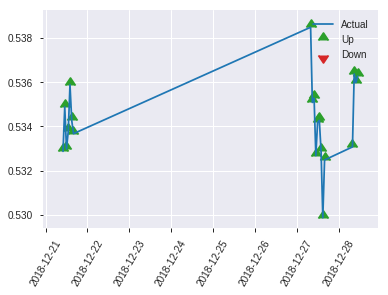


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.278323602490077
RMSE: 0.5275638373600648
LogLoss: 0.7530843848453065
Null degrees of freedom: 219
Residual degrees of freedom: -817
Null deviance: 305.28953504515266
Residual deviance: 331.35712933193486
AIC: 2405.3571293319346
AUC: 0.49325944917707387
pr_auc: 0.476472724096309
Gini: -0.013481101645852256
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6143109458496434: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    107  0.9469   (107.0/113.0)
1      1    106  0.0093   (1.0/107.0)
Total  7    213  0.4909   (108.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.614311     0.6625    212
max f2                       0.601486     0.828173  217
max f0point5                 0.625429     0.558282  176
max accuracy                 0.625429     0.536364  176
max precision                0.72374      1         0
max recall                   0.601486     1         217
max specificity              0.72374      1         0
max absolute_mcc             0.614311     0.124591  212
max min_per_class_accuracy   0.645915     0.485981  108
max mean_per_class_accuracy  0.625429     0.544703  176

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 65.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.71429            1.37072   1.37072            0.666667         0.717842  0.666667                    0.717842            0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.713445           2.05607   1.64486            1                0.713915  0.8                         0.716271            0.0186916       0.0373832                  105.607   64.486
    3        0.0318182                   0.711843           0         1.1749             0                0.712774  0.571429                    0.715272            0               0.0373832                  -100      17.49
    4        0.0409091                   0.70867            1.02804   1.14226            0.5              0.711296  0.555556                    0.714388            0.00934579      0.046729                   2.80374   14.2264
    5        0.05                        0.707355           0         0.934579           0                0.707719  0.454545                    0.713176            0               0.046729                   -100      -6.54206
    6        0.1                         0.697388           1.30841   1.1215             0.636364         0.704324  0.545455                    0.70875             0.0654206       0.11215                    30.8411   12.1495
    7        0.15                        0.687266           0.934579  1.05919            0.454545         0.69337   0.515152                    0.703623            0.046729        0.158879                   -6.54206  5.919
    8        0.2                         0.676473           0.373832  0.88785            0.181818         0.681698  0.431818                    0.698142            0.0186916       0.17757                    -62.6168  -11.215
    9        0.3                         0.663388           0.934579  0.903427           0.454545         0.670962  0.439394                    0.689082            0.0934579       0.271028                   -6.54206  -9.65732
    10       0.4                         0.653807           1.02804   0.934579           0.5              0.658468  0.454545                    0.681428            0.102804        0.373832                   2.80374   -6.54206
    11       0.5                         0.645479           1.1215    0.971963           0.545455         0.648948  0.472727                    0.674932            0.11215         0.485981                   12.1495   -2.80374
    12       0.6                         0.640201           0.934579  0.965732           0.454545         0.642585  0.469697                    0.669541            0.0934579       0.579439                   -6.54206  -3.42679
    13       0.7                         0.633437           1.21495   1.00134            0.590909         0.637259  0.487013                    0.664929            0.121495        0.700935                   21.4953   0.133511
    14       0.8                         0.625604           1.40187   1.0514             0.681818         0.629446  0.511364                    0.660494            0.140187        0.841121                   40.1869   5.14019
    15       0.9                         0.619695           0.747664  1.01765            0.363636         0.622757  0.494949                    0.656301            0.0747664       0.915888                   -25.2336  1.76532
    16       1                           0.593605           0.841121  1                  0.409091         0.613176  0.486364                    0.651988        

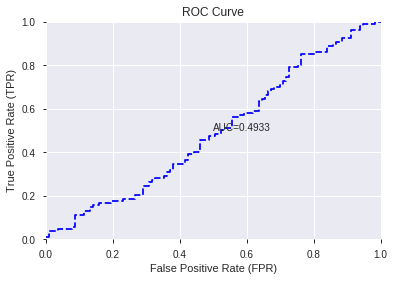

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


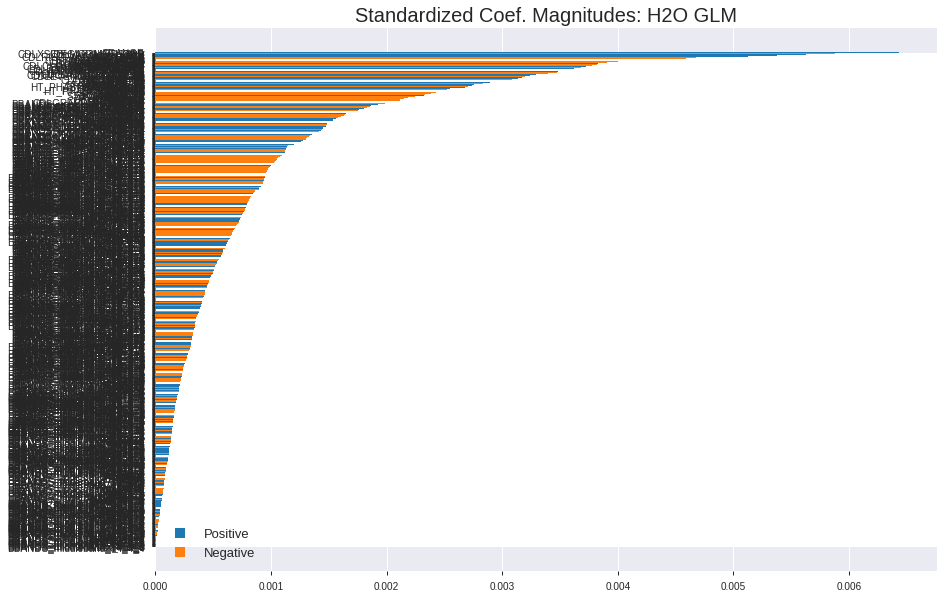

'log_likelihood'
--2019-08-28 15:36:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.212|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153556_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153556_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

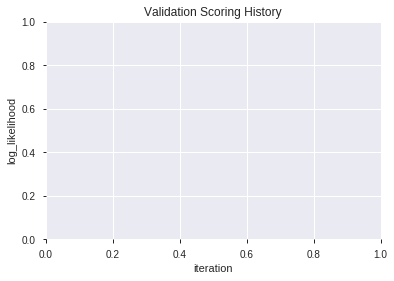

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_153643_model_1  0.547225  0.705045              0.495575  0.505748  0.255781
1               XGBoost_3_AutoML_20190828_153643  0.540650  0.701513              0.491150  0.503959  0.253975
2  XGBoost_grid_1_AutoML_20190828_153643_model_5  0.538003  0.746018              0.500000  0.523153  0.273689
3  XGBoost_grid_1_AutoML_20190828_153643_model_2  0.520263  0.710796              0.500000  0.508514  0.258587
4               XGBoost_2_AutoML_20190828_153643  0.505086  0.711219              0.477876  0.508734  0.258810
5  XGBoost_grid_1_AutoML_20190828_153643_model_3  0.501778  0.719270              0.477876  0.512385  0.262539
6  XGBoost_grid_1_AutoML_20190828_153643_model_6  0.493177  0.729986              0.500000  0.517137  0.267431
7  XGBoost_grid_1_AutoML_20190828_153643_model_4  0.470184  0.719438              0.491150  0.512525  0.262682
8  XGBoost_grid_1_AutoML_20190828_153643_model_7  0.464974  0.752954              0.486974  0.526767  0.277484
9               XGBoost_1_AutoML_20190828_153643  0.449425  0.738474              0.486726  0.520588  0.271012

variable  relative_importance  scaled_importance  percentage
0                  CORREL_20           119.549561           1.000000    0.023589
1                     Volume           119.535927           0.999886    0.023586
2                    WILLR_8            99.125092           0.829155    0.019559
3                      CCI_8            82.014015           0.686025    0.016183
4                HT_DCPERIOD            69.607468           0.582248    0.013735
..                       ...                  ...                ...         ...
265  BBANDS_lowerband_20_6_5             2.978200           0.024912    0.000588
266                  BETA_24             2.314699           0.019362    0.000457
267   BBANDS_upperband_8_3_3             2.213428           0.018515    0.000437
268                  NATR_24             2.141666           0.017914    0.000423
269               PLUS_DI_30             1.964338           0.016431    0.000388

[270 rows x 4 columns]

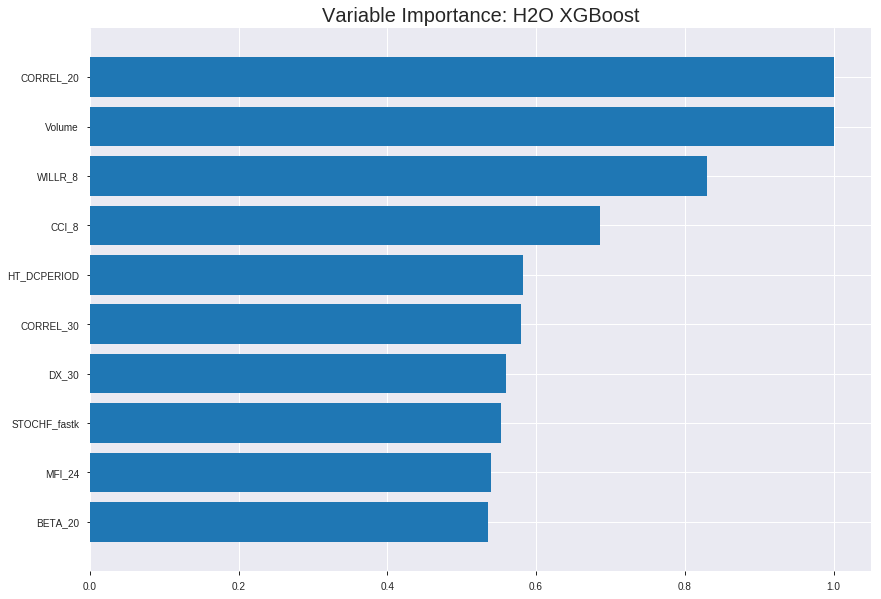

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_153643_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17206347556994273
RMSE: 0.41480534660240664
LogLoss: 0.5324740509117941
Mean Per-Class Error: 0.11550741723155511
AUC: 0.9570312103011271
pr_auc: 0.9581983227914207
Gini: 0.9140624206022543
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5109289407730102: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      653  101  0.134    (101.0/754.0)
1      76   707  0.0971   (76.0/783.0)
Total  729  808  0.1152   (177.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510929     0.888749  190
max f2                       0.448849     0.925216  247
max f0point5                 0.551091     0.907436  153
max accuracy                 0.510929     0.884841  190
max precision                0.769757     1         0
max recall                   0.398554     1         291
max specificity              0.769757     1         0
max absolute_mcc             0.510929     0.769866  190
max min_per_class_accuracy   0.516278     0.88378   185
max mean_per_class_accuracy  0.510929     0.884493  190

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.727076           1.96296    1.96296            1                0.742677  1                           0.742677            0.0204342       0.0204342                  96.2963   96.2963
    2        0.0201692                   0.710963           1.96296    1.96296            1                0.71819   1                           0.730829            0.0191571       0.0395913                  96.2963   96.2963
    3        0.0305791                   0.698131           1.96296    1.96296            1                0.702346  1                           0.721132            0.0204342       0.0600255                  96.2963   96.2963
    4        0.0403383                   0.689129           1.96296    1.96296            1                0.693292  1                           0.714397            0.0191571       0.0791826                  96.2963   96.2963
    5        0.0500976                   0.680595           1.96296    1.96296            1                0.684953  1                           0.708661            0.0191571       0.0983397                  96.2963   96.2963
    6        0.100195                    0.658765           1.96296    1.96296            1                0.670049  1                           0.689355            0.0983397       0.196679                   96.2963   96.2963
    7        0.150293                    0.63827            1.93747    1.95447            0.987013         0.647332  0.995671                    0.675347            0.0970626       0.293742                   93.747    95.4465
    8        0.20039                     0.621739           1.96296    1.95659            1                0.629178  0.996753                    0.663805            0.0983397       0.392082                   96.2963   95.659
    9        0.299935                    0.589445           1.84749    1.92038            0.941176         0.605722  0.978308                    0.644528            0.183908        0.57599                    84.7495   92.0382
    10       0.40013                     0.552669           1.74627    1.87678            0.88961          0.57226   0.956098                    0.626432            0.174968        0.750958                   74.6272   87.6784
    11       0.500325                    0.518557           1.23641    1.74854            0.62987          0.536702  0.890767                    0.608462            0.123883        0.87484                    23.6412   74.8543
    12       0.59987                     0.478722           0.75696    1.584              0.385621         0.499874  0.806941                    0.590443            0.0753512       0.950192                   -24.304   58.3996
    13       0.700065                    0.438095           0.407888   1.41567            0.207792         0.460677  0.72119                     0.57187             0.0408685       0.99106                    -59.2112  41.5668
    14       0.79961                     0.393862           0.0898088  1.25061            0.0457516        0.414969  0.637103                    0.552337            0.00893997      1                          -91.0191  25.061
    15       0.899805                    0.345986           0          1.11135            0                0.369866  0.566161                    0.532019            0               1                          -100      11.1352
    16       1                           0.209306           0          1                  0                0.299748  0.509434                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2588196272556538
RMSE: 0.5087431839893816
LogLoss: 0.7110682534648742
Mean Per-Class Error: 0.42248062015503873
AUC: 0.5226149870801033
pr_auc: 0.5455771022719276
Gini: 0.04522997416020669
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38806813955307007: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    215  0        (0.0/215.0)
Total  2    438  0.5068   (223.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388068     0.658499  397
max f2                       0.388068     0.828197  397
max f0point5                 0.418072     0.546995  392
max accuracy                 0.6302       0.584091  87
max precision                0.746896     1         0
max recall                   0.388068     1         397
max specificity              0.746896     1         0
max absolute_mcc             0.6302       0.190576  87
max min_per_class_accuracy   0.574654     0.506667  196
max mean_per_class_accuracy  0.6302       0.577519  87

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 56.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.727138           2.04651   2.04651            1                0.737741  1                           0.737741            0.0232558       0.0232558                  104.651   104.651
    2        0.0204545                   0.705616           0.511628  1.36434            0.25             0.720669  0.666667                    0.730153            0.00465116      0.027907                   -48.8372  36.4341
    3        0.0318182                   0.700713           1.22791   1.31561            0.6              0.702138  0.642857                    0.720148            0.0139535       0.0418605                  22.7907   31.5615
    4        0.0409091                   0.688194           1.02326   1.25065            0.5              0.695686  0.611111                    0.714712            0.00930233      0.0511628                  2.32558   25.0646
    5        0.05                        0.685615           1.53488   1.30233            0.75             0.687361  0.636364                    0.709739            0.0139535       0.0651163                  53.4884   30.2326
    6        0.1                         0.657549           1.39535   1.34884            0.681818         0.666878  0.659091                    0.688309            0.0697674       0.134884                   39.5349   34.8837
    7        0.15                        0.643336           1.39535   1.36434            0.681818         0.650585  0.666667                    0.675734            0.0697674       0.204651                   39.5349   36.4341
    8        0.2                         0.631262           1.39535   1.37209            0.681818         0.636672  0.670455                    0.665969            0.0697674       0.274419                   39.5349   37.2093
    9        0.3                         0.611704           0.790698  1.17829            0.386364         0.621991  0.575758                    0.651309            0.0790698       0.353488                   -20.9302  17.8295
    10       0.4                         0.592501           0.651163  1.04651            0.318182         0.603702  0.511364                    0.639407            0.0651163       0.418605                   -34.8837  4.65116
    11       0.5                         0.573905           0.883721  1.01395            0.431818         0.583264  0.495455                    0.628179            0.0883721       0.506977                   -11.6279  1.39535
    12       0.6                         0.544337           0.837209  0.984496           0.409091         0.558587  0.481061                    0.61658             0.0837209       0.590698                   -16.2791  -1.55039
    13       0.7                         0.524008           0.837209  0.963455           0.409091         0.534779  0.470779                    0.604894            0.0837209       0.674419                   -16.2791  -3.65449
    14       0.8                         0.497244           0.976744  0.965116           0.477273         0.511679  0.471591                    0.593242            0.0976744       0.772093                   -2.32558  -3.48837
    15       0.9                         0.468019           1.06977   0.976744           0.522727         0.481945  0.477273                    0.580876            0.106977        0.87907                    6.97674   -2.32558
    16       1                           0.363694           1.2093    1                  0.590909         0.435478  0.488636                    0.566336     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:36:59  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.490566                         0.5                0.693147              0.5               0                    1                  0.511364
    2019-08-28 15:37:00  1.076 sec   5                  0.484364         0.662285            0.82099         0.817105           1.96296          0.268055                         0.501327           0.695812              0.50676           0.486853             0.767442           0.511364
    2019-08-28 15:37:01  1.289 sec   10                 0.47241          0.639167            0.86796         0.87096            1.96296          0.24203                          0.50126            0.695661              0.51416           0.54014              2.04651            0.509091
    2019-08-28 15:37:01  1.494 sec   15                 0.46235          0.620002            0.897178        0.899191           1.96296          0.193884                         0.500807           0.694727              0.529881          0.547949             2.04651            0.509091
    2019-08-28 15:37:01  1.702 sec   20                 0.453534         0.603356            0.911843        0.913935           1.96296          0.176318                         0.50357            0.700309              0.522625          0.548195             2.04651            0.509091
    2019-08-28 15:37:01  1.912 sec   25                 0.444933         0.587304            0.922662        0.924433           1.96296          0.163956                         0.505199           0.70364               0.516424          0.543556             2.04651            0.509091
    2019-08-28 15:37:01  2.113 sec   30                 0.438234         0.574883            0.930206        0.932208           1.96296          0.164606                         0.505979           0.705296              0.523152          0.537987             1.63721            0.511364
    2019-08-28 15:37:02  2.313 sec   35                 0.431709         0.56297             0.939317        0.941163           1.96296          0.144437                         0.506373           0.706059              0.517695          0.542575             1.63721            0.509091
    2019-08-28 15:37:02  2.520 sec   40                 0.424396         0.549703            0.948058        0.949652           1.96296          0.124919                         0.508105           0.709678              0.521819          0.548064             1.63721            0.509091
    2019-08-28 15:37:02  2.722 sec   45                 0.419634         0.541096            0.951408        0.952879           1.96296          0.122316                         0.507792           0.709006              0.52555           0.552247             1.63721            0.509091
    2019-08-28 15:37:02  2.915 sec   50                 0.414805         0.532474            0.957031        0.958198           1.96296          0.115159                         0.508743           0.711068              0.522615          0.545577             2.04651            0.506818

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
CORREL_20                119.549560546875       1.0                   0.023588844876847877
Volume                   119.53592681884766     0.9998859575228468    0.02358615474654494
WILLR_8                  99.12509155273438      0.8291547965487313    0.01955880387468238
CCI_8                    82.0140151977539       0.6860252335732884    0.01618254281636363
HT_DCPERIOD              69.60746765136719      0.5822477919027926    0.01373455284308218
---                      ---                    ---                   ---
BBANDS_lowerband_20_6_5  2.9781999588012695     0.024911843633532445  0.0005876416150676872
BETA_24                  2.314699172973633      0.0193618375708378    0.00045672338298921795
BBANDS_upperband_8_3_3   2.213428497314453      0.01851473553887783   0.0004367412245624515
NATR_24                  2.1416664123535156     0.017914464951243173  0.0004225815347866033
PLUS_DI_30               1.9643383026123047     0.016431162888650635  0.0003875921525265995


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5681818181818182)

('F1', 0.656441717791411)

('auc', 0.5472252088330163)

('logloss', 0.7050452404524773)

('mean_per_class_error', 0.4342486146720701)

('rmse', 0.5057484311583872)

('mse', 0.25578147561916986)

xgboost prediction progress: |████████████████████████████████████████████| 100%


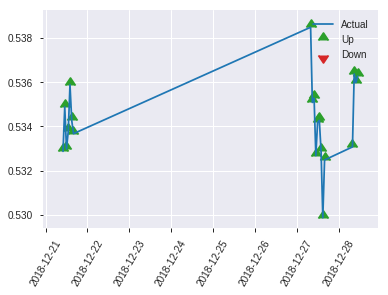


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25578147561916986
RMSE: 0.5057484311583872
LogLoss: 0.7050452404524773
Mean Per-Class Error: 0.4342486146720701
AUC: 0.5472252088330163
pr_auc: 0.5339204772417254
Gini: 0.09445041766603257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.364484578371048: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    107  0        (0.0/107.0)
Total  1    219  0.5091   (112.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364485     0.656442  217
max f2                       0.364485     0.826893  217
max f0point5                 0.557975     0.557461  117
max accuracy                 0.581927     0.568182  88
max precision                0.73602      1         0
max recall                   0.364485     1         217
max specificity              0.73602      1         0
max absolute_mcc             0.621406     0.137837  43
max min_per_class_accuracy   0.569503     0.560748  107
max mean_per_class_accuracy  0.581927     0.565751  88

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 55.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.709626           1.37072   1.37072            0.666667         0.727     0.666667                    0.727               0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.690275           1.02804   1.23364            0.5              0.702169  0.6                         0.717068            0.00934579      0.0280374                  2.80374   23.3645
    3        0.0318182                   0.677508           1.02804   1.1749             0.5              0.68202   0.571429                    0.707054            0.00934579      0.0373832                  2.80374   17.49
    4        0.0409091                   0.670532           2.05607   1.37072            1                0.673976  0.666667                    0.699704            0.0186916       0.0560748                  105.607   37.0717
    5        0.05                        0.66304            1.02804   1.30841            0.5              0.667766  0.636364                    0.693897            0.00934579      0.0654206                  2.80374   30.8411
    6        0.1                         0.640624           1.30841   1.30841            0.636364         0.65149   0.636364                    0.672693            0.0654206       0.130841                   30.8411   30.8411
    7        0.15                        0.628326           0.934579  1.1838             0.454545         0.634567  0.575758                    0.659985            0.046729        0.17757                    -6.54206  18.3801
    8        0.2                         0.621474           1.49533   1.26168            0.727273         0.625333  0.613636                    0.651322            0.0747664       0.252336                   49.5327   26.1682
    9        0.3                         0.597128           0.841121  1.1215             0.409091         0.608988  0.545455                    0.63721             0.0841121       0.336449                   -15.8879  12.1495
    10       0.4                         0.584357           1.21495   1.14486            0.590909         0.590243  0.556818                    0.625468            0.121495        0.457944                   21.4953   14.486
    11       0.5                         0.567748           1.02804   1.1215             0.5              0.576272  0.545455                    0.615629            0.102804        0.560748                   2.80374   12.1495
    12       0.6                         0.548442           0.841121  1.07477            0.409091         0.556552  0.522727                    0.605783            0.0841121       0.64486                    -15.8879  7.47664
    13       0.7                         0.527339           0.560748  1.00134            0.272727         0.538872  0.487013                    0.596224            0.0560748       0.700935                   -43.9252  0.133511
    14       0.8                         0.496242           0.747664  0.969626           0.363636         0.512861  0.471591                    0.585804            0.0747664       0.775701                   -25.2336  -3.03738
    15       0.9                         0.463923           1.1215    0.986501           0.545455         0.480091  0.479798                    0.574058            0.11215         0.88785                    12.1495   -1.34995
    16       1                           0.362703           1.1215    1                  0.545455         0.431232  0.486364                    0.559775         

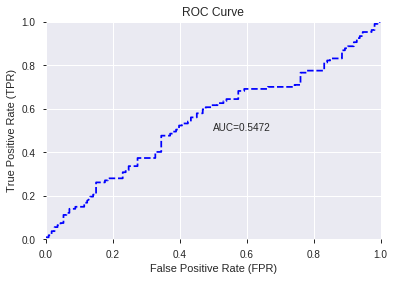

This function is available for GLM models only


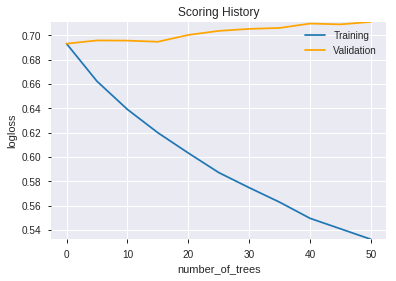

--2019-08-28 15:37:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_153643_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_153643_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_153746  0.584154  1.135979              0.500000  0.622755  0.387824
1  DeepLearning_grid_1_AutoML_20190828_153746_model_5  0.513192  0.693172              0.500000  0.500012  0.250012
2  DeepLearning_grid_1_AutoML_20190828_153746_model_8  0.500000  0.692779              0.500000  0.499816  0.249816
3  DeepLearning_grid_1_AutoML_20190828_153746_model_9  0.498305  0.694567              0.473948  0.500709  0.250709
4  DeepLearning_grid_1_AutoML_20190828_153746_model_2  0.493259  3.054465              0.500000  0.694155  0.481851
5  DeepLearning_grid_1_AutoML_20190828_153746_model_3  0.478538  1.447771              0.500000  0.617654  0.381497
6  DeepLearning_grid_1_AutoML_20190828_153746_model_7  0.476139  0.731895              0.495575  0.518383  0.268721
7  DeepLearning_grid_1_AutoML_20190828_153746_model_4  0.472666  0.760880              0.500000  0.529213  0.280066
8  DeepLearning_grid_1_AutoML_20190828_153746_model_6  0.458275  0.708204              0.495575  0.507395  0.257450
9  DeepLearning_grid_1_AutoML_20190828_153746_model_1  0.451824  4.250357              0.495575  0.711939  0.506858

variable  relative_importance  scaled_importance  percentage
0                    NATR_14             1.000000           1.000000    0.030921
1    BBANDS_lowerband_24_5_4             0.888674           0.888674    0.027478
2   BBANDS_middleband_14_5_2             0.842141           0.842141    0.026040
3                   MAVP_8_0             0.838497           0.838497    0.025927
4            CDLUNIQUE3RIVER             0.789887           0.789887    0.024424
5           CDLDRAGONFLYDOJI             0.789811           0.789811    0.024422
6   BBANDS_middleband_14_0_2             0.776084           0.776084    0.023997
7                    MA_14_2             0.771722           0.771722    0.023862
8                 AROONOSC_8             0.771153           0.771153    0.023845
9                MIDPOINT_12             0.762389           0.762389    0.023574
10   BBANDS_lowerband_30_2_2             0.758019           0.758019    0.023439
11   BBANDS_lowerband_30_5_4             0.750499           0.750499    0.023206
12                 STDDEV_30             0.727501           0.727501    0.022495
13                   BETA_24             0.726812           0.726812    0.022474
14   BBANDS_upperband_30_5_3             0.712828           0.712828    0.022041
15                 dayofweek             0.709968           0.709968    0.021953
16  BBANDS_middleband_14_6_3             0.707605           0.707605    0.021880
17                   BETA_14             0.703591           0.703591    0.021756
18                 CORREL_12             0.695426           0.695426    0.021503
19                  WILLR_20             0.691309           0.691309    0.021376
20                 CORREL_14             0.684515           0.684515    0.021166
21                     VAR_8             0.677370           0.677370    0.020945
22   BBANDS_upperband_24_2_3             0.675108           0.675108    0.020875
23    BBANDS_upperband_8_5_2             0.655814           0.655814    0.020278
24                     ADOSC             0.654960           0.654960    0.020252
25            STOCHRSI_fastk             0.652883           0.652883    0.020188
26                  WILLR_12             0.644784           0.644784    0.019937
27   BBANDS_lowerband_24_7_3             0.635672           0.635672    0.019655
28              STOCHF_fastk             0.626075           0.626075    0.019359
29                aroonup_14             0.616586           0.616586    0.019065
30   BBANDS_middleband_8_0_2             0.606088           0.606088    0.018741
31   BBANDS_upperband_14_3_4             0.603883           0.603883    0.018673
32         CDLDARKCLOUDCOVER             0.593724           0.593724    0.018358
33   BBANDS_lowerband_24_6_5             0.589095           0.589095    0.018215
34   BBANDS_upperband_24_0_5             0.579060           0.579060    0.017905
35                    MOM_24             0.568709           0.568709    0.017585
36        CDLEVENINGDOJISTAR             0.566149           0.566149    0.017506
37   BBANDS_lowerband_30_2_5             0.558811           0.558811    0.017279
38               HT_DCPERIOD             0.546528           0.546528    0.016899
39                   KAMA_12             0.544135           0.544135    0.016825
40                       PPO             0.543521           0.543521    0.016806
41   BBANDS_upperband_14_5_2             0.540917           0.540917    0.016726
42   BBANDS_lowerband_14_3_3             0.521625           0.521625    0.016129
43   BBANDS_lowerband_20_1_2             0.488428           0.488428    0.015103
44                   TRIX_14             0.459575           0.459575    0.014210
45   BBANDS_lowerband_24_1_4             0.444651           0.444651    0.013749
46      HT_PHASOR_quadrature             0.444196           0.444196    0.013735
47                       OBV             0.414828           0.414828    0.012827
48                   ADXR_12             0.402466  

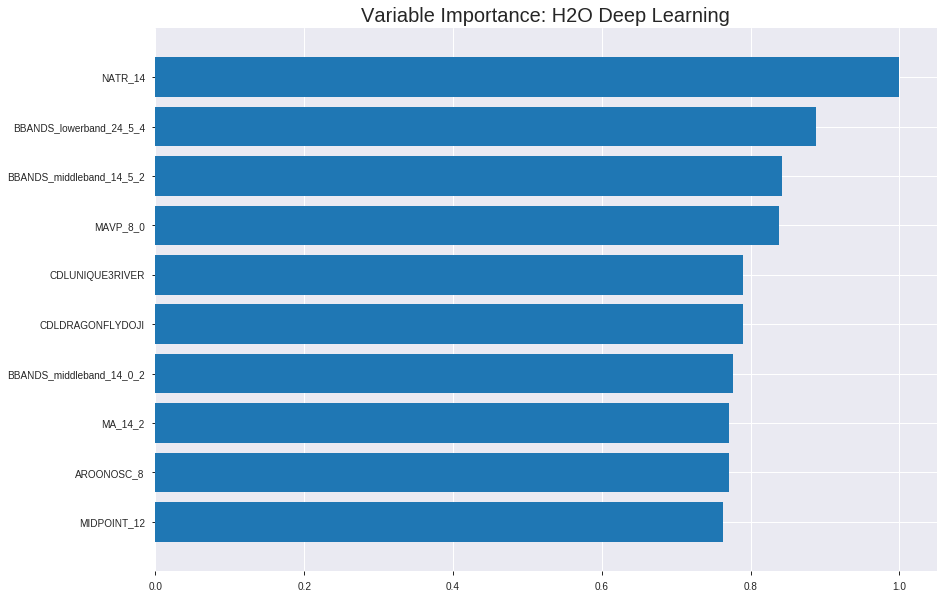

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_153746


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2577165516807303
RMSE: 0.5076579081238963
LogLoss: 0.7229454464353029
Mean Per-Class Error: 0.399351606248158
AUC: 0.6143352947752472
pr_auc: 0.5966113749681707
Gini: 0.22867058955049435
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2856828385631174: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      66   688   0.9125   (688.0/754.0)
1      23   760   0.0294   (23.0/783.0)
Total  89   1448  0.4626   (711.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285683     0.681309  356
max f2                       0.140403     0.839408  394
max f0point5                 0.646504     0.605809  168
max accuracy                 0.646504     0.59987   168
max precision                0.992837     1         0
max recall                   0.140403     1         394
max specificity              0.992837     1         0
max absolute_mcc             0.646504     0.201888  168
max min_per_class_accuracy   0.627321     0.594164  182
max mean_per_class_accuracy  0.646504     0.600648  168

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 60.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.924496           1.22685   1.22685            0.625            0.936216  0.625                       0.936216            0.0127714       0.0127714                  22.6852   22.6852
    2        0.0201692                   0.915725           1.43951   1.32975            0.733333         0.92123   0.677419                    0.928965            0.0140485       0.0268199                  43.9506   32.9749
    3        0.0305791                   0.907319           1.10417   1.25296            0.5625           0.911858  0.638298                    0.923141            0.0114943       0.0383142                  10.4167   25.2955
    4        0.0403383                   0.901633           1.17778   1.23477            0.6              0.90443   0.629032                    0.918614            0.0114943       0.0498084                  17.7778   23.4767
    5        0.0500976                   0.891434           1.04691   1.19817            0.533333         0.896295  0.61039                     0.914266            0.0102171       0.0600255                  4.69136   19.8172
    6        0.100195                    0.84335            1.30014   1.24916            0.662338         0.865767  0.636364                    0.890016            0.0651341       0.12516                    30.0144   24.9158
    7        0.150293                    0.801837           1.17268   1.22367            0.597403         0.821801  0.623377                    0.867278            0.0587484       0.183908                   17.2679   22.3665
    8        0.20039                     0.772763           1.30014   1.24278            0.662338         0.785861  0.633117                    0.846924            0.0651341       0.249042                   30.0144   24.2785
    9        0.299935                    0.720264           1.14185   1.20929            0.581699         0.746927  0.616052                    0.813736            0.113665        0.362708                   14.1854   20.9287
    10       0.40013                     0.674025           1.2874    1.22885            0.655844         0.696687  0.626016                    0.784426            0.128991        0.491699                   28.7398   22.8847
    11       0.500325                    0.627538           1.00697   1.18441            0.512987         0.64999   0.603381                    0.757504            0.100894        0.592593                   0.697451  18.4415
    12       0.59987                     0.582905           0.936577  1.14329            0.477124         0.607188  0.58243                     0.73256             0.0932312       0.685824                   -6.34229  14.3288
    13       0.700065                    0.520853           0.84127   1.10006            0.428571         0.550743  0.560409                    0.706538            0.0842912       0.770115                   -15.873   10.0062
    14       0.79961                     0.449178           0.795449  1.06214            0.405229         0.482735  0.54109                     0.678676            0.0791826       0.849298                   -20.4551  6.21403
    15       0.899805                    0.345012           0.80303   1.03329            0.409091         0.401979  0.526392                    0.647865            0.0804598       0.929757                   -19.697   3.32878
    16       1                           0.001634           0.701058  1                  0.357143         0.258661  0.509434                    0.608869         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3924698724271696
RMSE: 0.6264741594249276
LogLoss: 1.1632768914753582
Mean Per-Class Error: 0.4708527131782946
AUC: 0.515235142118863
pr_auc: 0.49950477450233643
Gini: 0.03047028423772602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3867688048684432: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    222  0.9867   (222.0/225.0)
1      0    215  0        (0.0/215.0)
Total  3    437  0.5045   (222.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.386769     0.659509   396
max f2                       0.386769     0.828836   396
max f0point5                 0.774289     0.554612   347
max accuracy                 0.926016     0.529545   87
max precision                0.959332     0.636364   10
max recall                   0.386769     1          396
max specificity              0.987041     0.995556   0
max absolute_mcc             0.774289     0.0902654  347
max min_per_class_accuracy   0.883079     0.493333   194
max mean_per_class_accuracy  0.774289     0.529147   347

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 86.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.9677             0.818605  0.818605           0.4              0.975761  0.4                         0.975761            0.00930233      0.00930233                 -18.1395  -18.1395
    2        0.0204545                   0.959685           1.53488   1.13695            0.75             0.963219  0.555556                    0.970187            0.0139535       0.0232558                  53.4884   13.6951
    3        0.0318182                   0.954484           1.22791   1.16944            0.6              0.957694  0.571429                    0.965725            0.0139535       0.0372093                  22.7907   16.9435
    4        0.0409091                   0.952318           0.511628  1.02326            0.25             0.953499  0.5                         0.963008            0.00465116      0.0418605                  -48.8372  2.32558
    5        0.05                        0.949759           1.02326   1.02326            0.5              0.950927  0.5                         0.960812            0.00930233      0.0511628                  2.32558   2.32558
    6        0.1                         0.943113           1.11628   1.06977            0.545455         0.945911  0.522727                    0.953361            0.055814        0.106977                   11.6279   6.97674
    7        0.15                        0.93918            0.930233  1.02326            0.454545         0.941201  0.5                         0.949308            0.0465116       0.153488                   -6.97674  2.32558
    8        0.2                         0.929027           1.11628   1.04651            0.545455         0.934125  0.511364                    0.945512            0.055814        0.209302                   11.6279   4.65116
    9        0.3                         0.918233           1.11628   1.06977            0.545455         0.923552  0.522727                    0.938192            0.111628        0.32093                    11.6279   6.97674
    10       0.4                         0.903633           0.883721  1.02326            0.431818         0.910815  0.5                         0.931348            0.0883721       0.409302                   -11.6279  2.32558
    11       0.5                         0.88321            0.837209  0.986047           0.409091         0.893953  0.481818                    0.923869            0.0837209       0.493023                   -16.2791  -1.39535
    12       0.6                         0.86499            0.976744  0.984496           0.477273         0.873901  0.481061                    0.915541            0.0976744       0.590698                   -2.32558  -1.55039
    13       0.7                         0.841042           1.25581   1.02326            0.613636         0.853789  0.5                         0.906719            0.125581        0.716279                   25.5814   2.32558
    14       0.8                         0.81201            0.930233  1.01163            0.454545         0.82649   0.494318                    0.89669             0.0930233       0.809302                   -6.97674  1.16279
    15       0.9                         0.763907           1.11628   1.02326            0.545455         0.791132  0.5                         0.884962            0.111628        0.92093                    11.6279   2.32558
    16       1                           0.305651           0.790698  1                  0.386364         0.642412  0.488636                    0.860707      


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:37:46  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:37:46  0.081 sec   69863 obs/sec     1         1             1537       0.551234         0.868914            -0.21587       0.522812        0.529435           0.981481         0.482759                         0.689332           2.10968               -0.901696        0.49568           0.487942             1.63721            0.509091
    2019-08-28 15:37:46  0.438 sec   44550 obs/sec     10        10            15370      0.507658         0.722945            -0.0312333     0.614335        0.596611           1.22685          0.462589                         0.626474           1.16328               -0.570691        0.515235          0.499505             0.818605           0.504545

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
NATR_14                   1.0                    1.0                  0.030920765108143417
BBANDS_lowerband_24_5_4   0.8886738419532776     0.8886738419532776   0.027478475124788664
BBANDS_middleband_14_5_2  0.8421412110328674     0.8421412110328674   0.02603965057423473
MAVP_8_0                  0.8384971022605896     0.8384971022605896   0.0259269719428586
CDLUNIQUE3RIVER           0.7898868918418884     0.7898868918418884   0.024423907044644515
---                       ---                    ---                  ---
BBANDS_lowerband_24_1_4   0.4446509778499603     0.4446509778499603   0.013748948441204905
HT_PHASOR_quadrature      0.4441955089569092     0.4441955089569092   0.013734864994548804
OBV                       0.4148283898830414     0.4148283898830414   0.01282681120376286
ADXR_12                   0.40246644616127014    0.40246644616127014  0.012444570445661883
PLUS_DI_8                 0.38665249943733215    0.38665249943733215  0.011955591113578303


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6)

('F1', 0.654434250764526)

('auc', 0.5841535026052437)

('logloss', 1.1359785096303536)

('mean_per_class_error', 0.3988090315110413)

('rmse', 0.6227549580443306)

('mse', 0.38782373776879586)

deeplearning prediction progress: |███████████████████████████████████████| 100%


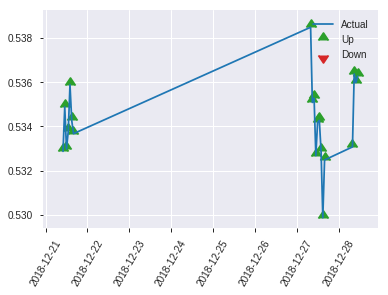


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.38782373776879586
RMSE: 0.6227549580443306
LogLoss: 1.1359785096303536
Mean Per-Class Error: 0.3988090315110413
AUC: 0.5841535026052437
pr_auc: 0.5728667507600607
Gini: 0.16830700521048736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3833133598090767: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    107  0        (0.0/107.0)
Total  0    220  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383313     0.654434  219
max f2                       0.383313     0.825617  219
max f0point5                 0.888944     0.591767  118
max accuracy                 0.890155     0.6       114
max precision                0.981407     1         0
max recall                   0.383313     1         219
max specificity              0.981407     1         0
max absolute_mcc             0.888944     0.202987  118
max min_per_class_accuracy   0.895706     0.588785  108
max mean_per_class_accuracy  0.888944     0.601191  118

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 85.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.963887           1.37072   1.37072            0.666667         0.969817  0.666667                    0.969817            0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.959885           2.05607   1.64486            1                0.962515  0.8                         0.966896            0.0186916       0.0373832                  105.607   64.486
    3        0.0318182                   0.95646            2.05607   1.76235            1                0.957296  0.857143                    0.964153            0.0186916       0.0560748                  105.607   76.235
    4        0.0409091                   0.953136           2.05607   1.82762            1                0.955778  0.888889                    0.962292            0.0186916       0.0747664                  105.607   82.7622
    5        0.05                        0.951638           0         1.49533            0                0.952308  0.727273                    0.960477            0               0.0747664                  -100      49.5327
    6        0.1                         0.946822           1.30841   1.40187            0.636364         0.949978  0.681818                    0.955228            0.0654206       0.140187                   30.8411   40.1869
    7        0.15                        0.941227           1.30841   1.37072            0.636364         0.944349  0.666667                    0.951601            0.0654206       0.205607                   30.8411   37.0717
    8        0.2                         0.933056           0.934579  1.26168            0.454545         0.937273  0.613636                    0.948019            0.046729        0.252336                   -6.54206  26.1682
    9        0.3                         0.921273           0.934579  1.15265            0.454545         0.927012  0.560606                    0.941017            0.0934579       0.345794                   -6.54206  15.2648
    10       0.4                         0.910452           1.40187   1.21495            0.681818         0.917495  0.590909                    0.935136            0.140187        0.485981                   40.1869   21.4953
    11       0.5                         0.894762           1.02804   1.17757            0.5              0.902801  0.572727                    0.928669            0.102804        0.588785                   2.80374   17.757
    12       0.6                         0.866339           0.934579  1.13707            0.454545         0.884741  0.55303                     0.921348            0.0934579       0.682243                   -6.54206  13.7072
    13       0.7                         0.839405           0.46729   1.04139            0.227273         0.85359   0.506494                    0.911668            0.046729        0.728972                   -53.271   4.13885
    14       0.8                         0.780406           0.747664  1.00467            0.363636         0.812282  0.488636                    0.899245            0.0747664       0.803738                   -25.2336  0.46729
    15       0.9                         0.698568           1.1215    1.01765            0.545455         0.739824  0.494949                    0.881531            0.11215         0.915888                   12.1495   1.76532
    16       1                           0.383313           0.841121  1                  0.409091         0.612389  0.486364                    0.854617            

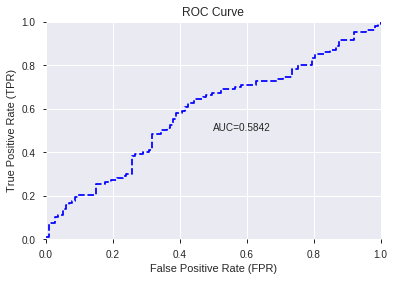

This function is available for GLM models only


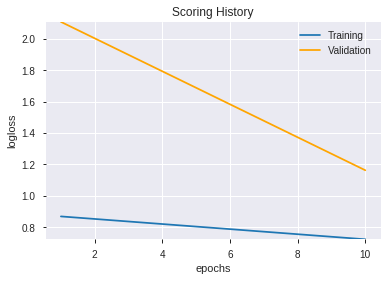

--2019-08-28 15:47:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.236
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.236|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_153746',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_153746',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_a92b'

['NATR_14',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_middleband_14_5_2',
 'MAVP_8_0',
 'CDLUNIQUE3RIVER',
 'CDLDRAGONFLYDOJI',
 'BBANDS_middleband_14_0_2',
 'MA_14_2',
 'AROONOSC_8',
 'MIDPOINT_12',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_lowerband_30_5_4',
 'STDDEV_30',
 'BETA_24',
 'BBANDS_upperband_30_5_3',
 'dayofweek',
 'BBANDS_middleband_14_6_3',
 'BETA_14',
 'CORREL_12',
 'WILLR_20',
 'CORREL_14',
 'VAR_8',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_8_5_2',
 'ADOSC',
 'STOCHRSI_fastk',
 'WILLR_12',
 'BBANDS_lowerband_24_7_3',
 'STOCHF_fastk',
 'aroonup_14',
 'BBANDS_middleband_8_0_2',
 'BBANDS_upperband_14_3_4',
 'CDLDARKCLOUDCOVER',
 'BBANDS_lowerband_24_6_5',
 'BBANDS_upperband_24_0_5',
 'MOM_24',
 'CDLEVENINGDOJISTAR',
 'BBANDS_lowerband_30_2_5',
 'HT_DCPERIOD',
 'KAMA_12',
 'PPO',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_lowerband_20_1_2',
 'TRIX_14',
 'BBANDS_lowerband_24_1_4',
 'HT_PHASOR_quadrature',
 'OBV',
 'ADXR_12',
 'PLUS_DI_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_154758_model_1  0.490778  0.718639              0.473948  0.512334  0.262486

variable  relative_importance  scaled_importance  percentage
0                      VAR_8             0.006253           1.000000    0.046147
1                 aroonup_14             0.005444           0.870604    0.040175
2    BBANDS_upperband_14_3_4             0.004904           0.784336    0.036194
3               STOCHF_fastk             0.004805           0.768497    0.035464
4    BBANDS_upperband_14_5_2             0.004277           0.683999    0.031564
5            CDLUNIQUE3RIVER             0.003933           0.628974    0.029025
6     BBANDS_upperband_8_5_2             0.003876           0.619914    0.028607
7          CDLDARKCLOUDCOVER             0.003744           0.598775    0.027631
8         CDLEVENINGDOJISTAR             0.003586           0.573545    0.026467
9                        OBV             0.003493           0.558662    0.025780
10                  WILLR_12             0.003421           0.547076    0.025246
11   BBANDS_lowerband_30_5_4             0.003412           0.545646    0.025180
12   BBANDS_lowerband_30_2_2             0.003411           0.545576    0.025177
13   BBANDS_lowerband_30_2_5             0.003366           0.538354    0.024843
14  BBANDS_middleband_14_0_2             0.003340           0.534124    0.024648
15   BBANDS_upperband_24_2_3             0.003320           0.531019    0.024505
16  BBANDS_middleband_14_5_2             0.003320           0.530945    0.024501
17   BBANDS_middleband_8_0_2             0.003261           0.521489    0.024065
18                   MA_14_2             0.003247           0.519244    0.023961
19                   NATR_14             0.003188           0.509916    0.023531
20               MIDPOINT_12             0.003186           0.509456    0.023510
21                   KAMA_12             0.003154           0.504404    0.023277
22  BBANDS_middleband_14_6_3             0.003103           0.496269    0.022901
23                  MAVP_8_0             0.003021           0.483120    0.022294
24   BBANDS_upperband_24_0_5             0.002957           0.472905    0.021823
25   BBANDS_lowerband_24_7_3             0.002871           0.459101    0.021186
26            STOCHRSI_fastk             0.002821           0.451201    0.020821
27                AROONOSC_8             0.002778           0.444320    0.020504
28   BBANDS_lowerband_24_1_4             0.002706           0.432712    0.019968
29   BBANDS_lowerband_24_5_4             0.002631           0.420749    0.019416
30      HT_PHASOR_quadrature             0.002572           0.411388    0.018984
31   BBANDS_lowerband_20_1_2             0.002547           0.407397    0.018800
32   BBANDS_upperband_30_5_3             0.002396           0.383198    0.017683
33                  WILLR_20             0.002305           0.368688    0.017014
34   BBANDS_lowerband_24_6_5             0.002200           0.351797    0.016234
35                     ADOSC             0.001910           0.305424    0.014094
36                 CORREL_12             0.001905           0.304714    0.014062
37                 PLUS_DI_8             0.001627           0.260267    0.012010
38   BBANDS_lowerband_14_3_3             0.001534           0.245271    0.011318
39                 CORREL_14             0.001466           0.234381    0.010816
40                       PPO             0.001434           0.229344    0.010583
41                 STDDEV_30             0.001427           0.228265    0.010534
42                 dayofweek             0.001092           0.174620    0.008058
43                   ADXR_12             0.000991           0.158443    0.007312
44                   BETA_24             0.000986           0.157767    0.007280
45                    MOM_24             0.000801           0.128169    0.005915
46                   BETA_14             0.000545           0.087082    0.004019
47                   TRIX_14             0.000427           0.068300    0.003152
48               HT_DCPERIOD             0.000276  

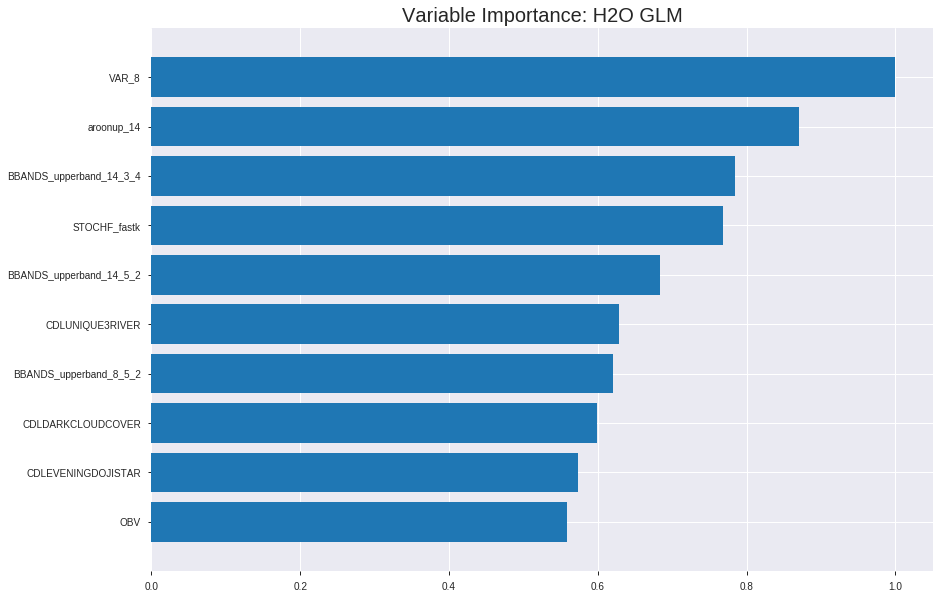

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_154758_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2488993903391601
RMSE: 0.49889817632374656
LogLoss: 0.6909433052895994
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2130.187230760045
Residual deviance: 2123.9597204602283
AIC: 2225.9597204602283
AUC: 0.5446228035407583
pr_auc: 0.5486690351870913
Gini: 0.08924560708151663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4759892366443911: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    753   0.9987   (753.0/754.0)
1      0    783   0        (0.0/783.0)
Total  1    1536  0.4899   (753.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.475989     0.675291   398
max f2                       0.475989     0.838689   398
max f0point5                 0.491341     0.572978   326
max accuracy                 0.495119     0.543266   295
max precision                0.556434     1          0
max recall                   0.475989     1          398
max specificity              0.556434     1          0
max absolute_mcc             0.495119     0.0878938  295
max min_per_class_accuracy   0.507664     0.526525   215
max mean_per_class_accuracy  0.514649     0.540402   177

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.546156           1.22685   1.22685            0.625            0.548201  0.625                       0.548201            0.0127714       0.0127714                  22.6852    22.6852
    2        0.0201692                   0.544068           1.30864   1.26643            0.666667         0.544784  0.645161                    0.546548            0.0127714       0.0255428                  30.8642    26.6428
    3        0.0305791                   0.541836           0.858796  1.12766            0.4375           0.542899  0.574468                    0.545306            0.00893997      0.0344828                  -14.1204   12.766
    4        0.0403383                   0.539382           1.17778   1.13978            0.6              0.540817  0.580645                    0.54422             0.0114943       0.045977                   17.7778    13.9785
    5        0.0500976                   0.53766            1.17778   1.14719            0.6              0.538438  0.584416                    0.543093            0.0114943       0.0574713                  17.7778    14.7186
    6        0.100195                    0.532818           1.12169   1.13444            0.571429         0.535014  0.577922                    0.539054            0.0561941       0.113665                   12.1693    13.444
    7        0.150293                    0.530193           1.12169   1.13019            0.571429         0.5315    0.575758                    0.536536            0.0561941       0.16986                    12.1693    13.0191
    8        0.20039                     0.527307           0.994228  1.0962             0.506494         0.528775  0.558442                    0.534596            0.0498084       0.219668                   -0.577201  9.62001
    9        0.299935                    0.520269           1.01356   1.06877            0.51634          0.523575  0.544469                    0.530938            0.100894        0.320562                   1.3556     6.87716
    10       0.40013                     0.515225           1.15993   1.0916             0.590909         0.517693  0.556098                    0.527622            0.11622         0.436782                   15.9933    9.15989
    11       0.500325                    0.507681           0.892256  1.05168            0.454545         0.511739  0.535761                    0.524441            0.0893997       0.526181                   -10.7744   5.16785
    12       0.59987                     0.501659           1.02639   1.04748            0.522876         0.504548  0.533623                    0.52114             0.102171        0.628352                   2.63859    4.74813
    13       0.700065                    0.49646            1.05796   1.04898            0.538961         0.498693  0.534387                    0.517927            0.106003        0.734355                   5.79606    4.89811
    14       0.79961                     0.492432           0.885258  1.0286             0.45098          0.494481  0.524003                    0.515008            0.0881226       0.822478                   -11.4742   2.8599
    15       0.899805                    0.488051           0.84127   1.00774            0.428571         0.490434  0.513377                    0.512272            0.0842912       0.906769                   -15.873    0.773948
    16       1                           0.47573            0.930495  1                  0.474026         0.483948  0.509434                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25589862161260757
RMSE: 0.505864232391071
LogLoss: 0.7050696766532749
Null degrees of freedom: 439
Residual degrees of freedom: 389
Null deviance: 610.5035894343387
Residual deviance: 620.461315454882
AIC: 722.461315454882
AUC: 0.5110077519379845
pr_auc: 0.49485782588608596
Gini: 0.022015503875969067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5326008166193235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    215  0        (0.0/215.0)
Total  1    439  0.5091   (224.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.532601     0.657492   398
max f2                       0.532601     0.82756    398
max f0point5                 0.540734     0.547345   363
max accuracy                 0.561437     0.531818   241
max precision                0.588605     0.6875     14
max recall                   0.532601     1          398
max specificity              0.619475     0.995556   0
max absolute_mcc             0.588081     0.0886608  20
max min_per_class_accuracy   0.570407     0.511111   188
max mean_per_class_accuracy  0.561341     0.53478    243

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 56.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.591357           0.818605  0.818605           0.4              0.601233  0.4                         0.601233            0.00930233      0.00930233                 -18.1395  -18.1395
    2        0.0204545                   0.589604           1.53488   1.13695            0.75             0.590497  0.555556                    0.596461            0.0139535       0.0232558                  53.4884   13.6951
    3        0.0318182                   0.588837           1.63721   1.31561            0.8              0.589298  0.642857                    0.593903            0.0186047       0.0418605                  63.7209   31.5615
    4        0.0409091                   0.588318           1.53488   1.36434            0.75             0.58852   0.666667                    0.592707            0.0139535       0.055814                   53.4884   36.4341
    5        0.05                        0.588012           1.53488   1.39535            0.75             0.588151  0.681818                    0.591878            0.0139535       0.0697674                  53.4884   39.5349
    6        0.1                         0.584909           0.837209  1.11628            0.409091         0.586408  0.545455                    0.589143            0.0418605       0.111628                   -16.2791  11.6279
    7        0.15                        0.582253           0.372093  0.868217           0.181818         0.583781  0.424242                    0.587356            0.0186047       0.130233                   -62.7907  -13.1783
    8        0.2                         0.579869           0.930233  0.883721           0.454545         0.581169  0.431818                    0.585809            0.0465116       0.176744                   -6.97674  -11.6279
    9        0.3                         0.576467           1.11628   0.96124            0.545455         0.578172  0.469697                    0.583264            0.111628        0.288372                   11.6279   -3.87597
    10       0.4                         0.573809           1.11628   1                  0.545455         0.575358  0.488636                    0.581287            0.111628        0.4                        11.6279   0
    11       0.5                         0.570389           1.11628   1.02326            0.545455         0.572019  0.5                         0.579433            0.111628        0.511628                   11.6279   2.32558
    12       0.6                         0.562209           1.16279   1.04651            0.568182         0.566588  0.511364                    0.577293            0.116279        0.627907                   16.2791   4.65116
    13       0.7                         0.558808           0.930233  1.0299             0.454545         0.560568  0.503247                    0.574903            0.0930233       0.72093                    -6.97674  2.99003
    14       0.8                         0.550793           0.883721  1.01163            0.431818         0.554609  0.494318                    0.572367            0.0883721       0.809302                   -11.6279  1.16279
    15       0.9                         0.541639           0.976744  1.00775            0.477273         0.546567  0.492424                    0.5695              0.0976744       0.906977                   -2.32558  0.775194
    16       1                           0.532497           0.930233  1                  0.454545         0.537196  0.488636                    0.566269          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:47:58  0.000 sec   2            3.1       51            1.38189           1.41014
    2019-08-28 15:47:58  0.015 sec   4            2         51            1.3809            1.41774
    2019-08-28 15:47:58  0.027 sec   6            1.2       51            1.37971           1.42568
    2019-08-28 15:47:58  0.046 sec   8            0.75      51            1.37824           1.43391
    2019-08-28 15:47:58  0.062 sec   10           0.47      51            1.37652           1.44206

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5363636363636364)

('F1', 0.6624605678233438)

('auc', 0.49077826482507647)

('logloss', 0.7186391166256003)

('mean_per_class_error', 0.4616657017616409)

('rmse', 0.5123336444053052)

('mse', 0.2624857631896217)

glm prediction progress: |████████████████████████████████████████████████| 100%


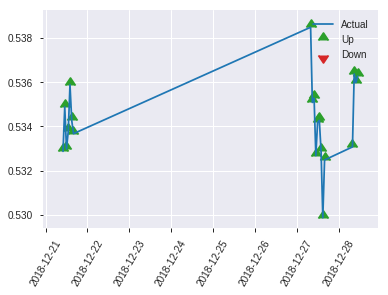


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2624857631896217
RMSE: 0.5123336444053052
LogLoss: 0.7186391166256003
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.28953504515266
Residual deviance: 316.2012113152641
AIC: 418.2012113152641
AUC: 0.49077826482507647
pr_auc: 0.49999754469598956
Gini: -0.018443470349847058
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5749225133806043: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    105  0.9292   (105.0/113.0)
1      2    105  0.0187   (2.0/107.0)
Total  10   210  0.4864   (107.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.574923     0.662461  209
max f2                       0.569735     0.825617  219
max f0point5                 0.576698     0.559247  198
max accuracy                 0.627608     0.536364  8
max precision                0.631633     1         0
max recall                   0.569735     1         219
max specificity              0.631633     1         0
max absolute_mcc             0.628244     0.139846  3
max min_per_class_accuracy   0.590033     0.477876  110
max mean_per_class_accuracy  0.576698     0.538334  198

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 59.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.628602           2.05607   2.05607            1                0.630381  1                           0.630381            0.0280374       0.0280374                  105.607   105.607
    2        0.0227273                   0.628204           1.02804   1.64486            0.5              0.62823   0.8                         0.62952             0.00934579      0.0373832                  2.80374   64.486
    3        0.0318182                   0.627851           1.02804   1.46862            0.5              0.628061  0.714286                    0.629104            0.00934579      0.046729                   2.80374   46.8625
    4        0.0409091                   0.627211           2.05607   1.59917            1                0.627697  0.777778                    0.628791            0.0186916       0.0654206                  105.607   59.9169
    5        0.05                        0.626853           1.02804   1.49533            0.5              0.627072  0.727273                    0.628478            0.00934579      0.0747664                  2.80374   49.5327
    6        0.1                         0.621787           0.560748  1.02804            0.272727         0.624427  0.5                         0.626453            0.0280374       0.102804                   -43.9252  2.80374
    7        0.15                        0.619546           1.1215    1.05919            0.545455         0.620795  0.515152                    0.624567            0.0560748       0.158879                   12.1495   5.919
    8        0.2                         0.614597           0.373832  0.88785            0.181818         0.617465  0.431818                    0.622791            0.0186916       0.17757                    -62.6168  -11.215
    9        0.3                         0.605059           1.02804   0.934579           0.5              0.6097    0.454545                    0.618427            0.102804        0.280374                   2.80374   -6.54206
    10       0.4                         0.596649           0.934579  0.934579           0.454545         0.600385  0.454545                    0.613917            0.0934579       0.373832                   -6.54206  -6.54206
    11       0.5                         0.590235           1.02804   0.953271           0.5              0.593331  0.463636                    0.6098              0.102804        0.476636                   2.80374   -4.6729
    12       0.6                         0.586845           1.30841   1.01246            0.636364         0.588688  0.492424                    0.606281            0.130841        0.607477                   30.8411   1.24611
    13       0.7                         0.583182           1.02804   1.01469            0.5              0.584712  0.493506                    0.6032              0.102804        0.71028                    2.80374   1.46862
    14       0.8                         0.58038            0.841121  0.992991           0.409091         0.58195   0.482955                    0.600543            0.0841121       0.794393                   -15.8879  -0.700935
    15       0.9                         0.57671            1.40187   1.03842            0.681818         0.578402  0.505051                    0.598083            0.140187        0.934579                   40.1869   3.84216
    16       1                           0.569735           0.654206  1                  0.318182         0.574684  0.486364                    0.595743        

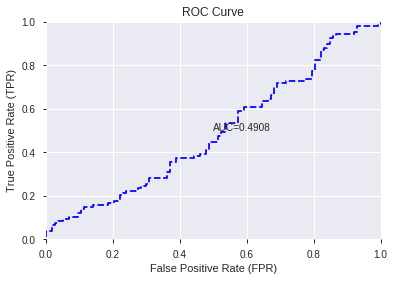

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


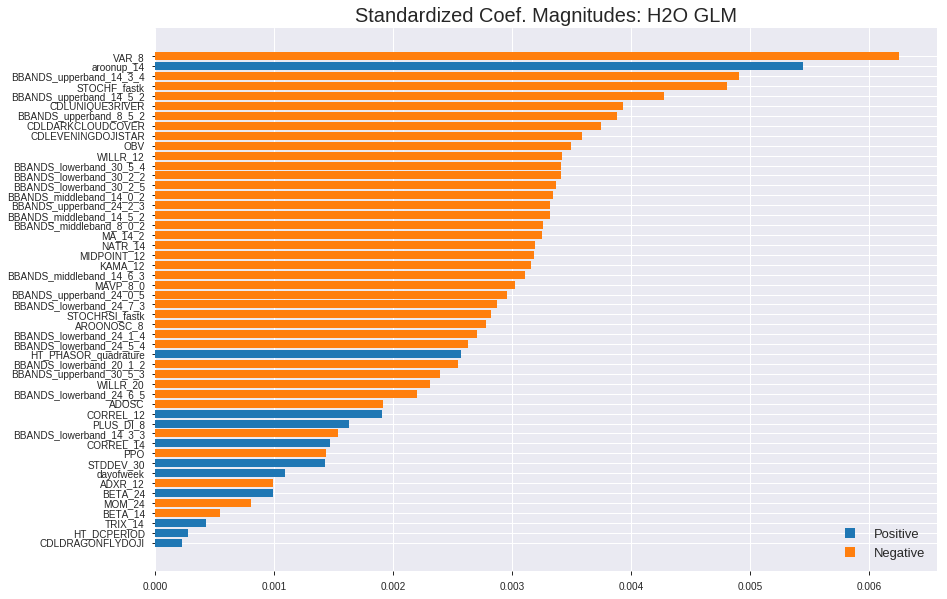

'log_likelihood'
--2019-08-28 15:48:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_154758_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_154758_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['VAR_8',
 'aroonup_14',
 'BBANDS_upperband_14_3_4',
 'STOCHF_fastk',
 'BBANDS_upperband_14_5_2',
 'CDLUNIQUE3RIVER',
 'BBANDS_upperband_8_5_2',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'OBV',
 'WILLR_12',
 'BBANDS_lowerband_30_5_4',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_middleband_14_0_2',
 'BBANDS_upperband_24_2_3',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_8_0_2',
 'MA_14_2',
 'NATR_14',
 'MIDPOINT_12',
 'KAMA_12',
 'BBANDS_middleband_14_6_3',
 'MAVP_8_0',
 'BBANDS_upperband_24_0_5',
 'BBANDS_lowerband_24_7_3',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_24_5_4',
 'HT_PHASOR_quadrature',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_30_5_3',
 'WILLR_20',
 'BBANDS_lowerband_24_6_5',
 'ADOSC',
 'CORREL_12',
 'PLUS_DI_8',
 'BBANDS_lowerband_14_3_3',
 'CORREL_14',
 'PPO',
 'STDDEV_30',
 'dayofweek',
 'ADXR_12',
 'BETA_24',
 'MOM_24',
 'BETA_14',
 'TRIX_14',
 'HT_DCPERIOD',
 'CDLDRAGONFLYDOJI']

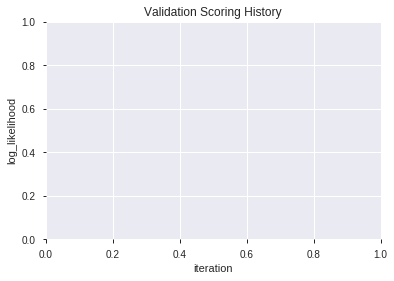

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_154812_model_5  0.565627  0.726428              0.486974  0.514482  0.264692
1  XGBoost_grid_1_AutoML_20190828_154812_model_3  0.480936  0.726850              0.500000  0.515975  0.266230
2  XGBoost_grid_1_AutoML_20190828_154812_model_4  0.476139  0.719288              0.500000  0.512481  0.262637
3  XGBoost_grid_1_AutoML_20190828_154812_model_1  0.474940  0.735829              0.486726  0.519990  0.270389
4               XGBoost_1_AutoML_20190828_154812  0.471425  0.715198              0.500000  0.510580  0.260692
5               XGBoost_3_AutoML_20190828_154812  0.467703  0.726115              0.500000  0.515676  0.265921
6  XGBoost_grid_1_AutoML_20190828_154812_model_6  0.454015  0.746665              0.487222  0.524815  0.275431
7  XGBoost_grid_1_AutoML_20190828_154812_model_2  0.444297  0.712214              0.491150  0.509271  0.259357
8               XGBoost_2_AutoML_20190828_154812  0.440576  0.727975              0.500000  0.516578  0.266853
9  XGBoost_grid_1_AutoML_20190828_154812_model_7  0.424531  0.739257              0.495575  0.521538  0.272002

variable  relative_importance  scaled_importance  percentage
0                  PLUS_DI_8           895.745728           1.000000    0.041680
1                        OBV           774.224365           0.864335    0.036026
2                      VAR_8           764.841492           0.853860    0.035589
3       HT_PHASOR_quadrature           758.565308           0.846853    0.035297
4                    ADXR_12           753.256287           0.840926    0.035050
5               STOCHF_fastk           748.569397           0.835694    0.034832
6                HT_DCPERIOD           745.588928           0.832367    0.034693
7                   WILLR_20           737.470642           0.823304    0.034315
8                    TRIX_14           706.875488           0.789147    0.032892
9                      ADOSC           699.953186           0.781420    0.032570
10                  WILLR_12           653.802734           0.729898    0.030422
11                   BETA_24           643.713501           0.718634    0.029953
12                  MAVP_8_0           641.269714           0.715906    0.029839
13                   BETA_14           630.812073           0.704231    0.029352
14                    MOM_24           627.065308           0.700048    0.029178
15   BBANDS_upperband_14_3_4           603.086609           0.673279    0.028062
16                   NATR_14           574.582397           0.641457    0.026736
17                       PPO           550.192017           0.614228    0.025601
18    BBANDS_upperband_8_5_2           545.301575           0.608768    0.025374
19                 CORREL_14           528.846741           0.590398    0.024608
20                AROONOSC_8           486.393524           0.543004    0.022632
21                 STDDEV_30           484.320007           0.540689    0.022536
22   BBANDS_middleband_8_0_2           476.144928           0.531563    0.022156
23   BBANDS_upperband_24_0_5           464.533539           0.518600    0.021615
24   BBANDS_upperband_14_5_2           437.705811           0.488650    0.020367
25   BBANDS_lowerband_24_5_4           412.682129           0.460713    0.019203
26            STOCHRSI_fastk           373.960938           0.417486    0.017401
27                aroonup_14           370.243439           0.413335    0.017228
28   BBANDS_lowerband_24_1_4           361.993744           0.404126    0.016844
29   BBANDS_lowerband_14_3_3           337.886963           0.377213    0.015722
30                 CORREL_12           323.354065           0.360989    0.015046
31   BBANDS_upperband_30_5_3           307.256744           0.343018    0.014297
32   BBANDS_upperband_24_2_3           297.495789           0.332121    0.013843
33   BBANDS_lowerband_24_6_5           293.332489           0.327473    0.013649
34   BBANDS_lowerband_30_2_5           278.561188           0.310982    0.012962
35   BBANDS_lowerband_30_5_4           267.416870           0.298541    0.012443
36                   KAMA_12           256.082367           0.285887    0.011916
37  BBANDS_middleband_14_0_2           255.201843           0.284904    0.011875
38                 dayofweek           228.030472           0.254571    0.010611
39               MIDPOINT_12           204.286560           0.228063    0.009506
40   BBANDS_lowerband_20_1_2           201.858551           0.225353    0.009393
41                   MA_14_2           178.263641           0.199011    0.008295
42   BBANDS_lowerband_24_7_3           174.872284           0.195225    0.008137
43   BBANDS_lowerband_30_2_2           155.657379           0.173774    0.007243
44  BBANDS_middleband_14_5_2           134.557083           0.150218    0.006261
45  BBANDS_middleband_14_6_3           121.115623           0.135212    0.005636
46          CDLDRAGONFLYDOJI            13.716861           0.015313    0.000638
47         CDLDARKCLOUDCOVER            10.298822           0.011497    0.000479

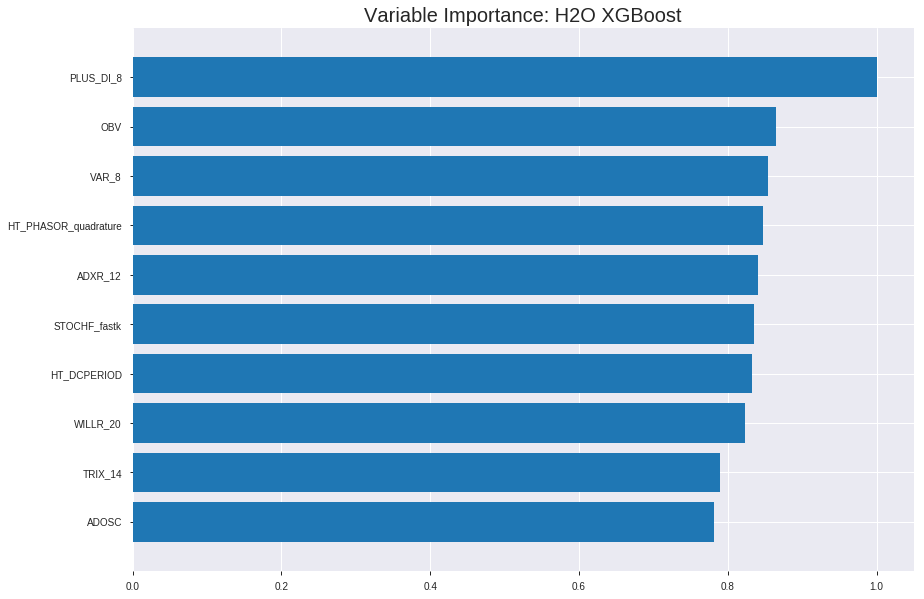

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_154812_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04787787259748134
RMSE: 0.21881012910165137
LogLoss: 0.23577061504843103
Mean Per-Class Error: 0.0006631299734747298
AUC: 0.9999915309071076
pr_auc: 0.9987146896855358
Gini: 0.9999830618142151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5341848134994507: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      753  1    0.0013   (1.0/754.0)
1      0    783  0        (0.0/783.0)
Total  753  784  0.0007   (1.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.534185     0.999362  197
max f2                       0.534185     0.999745  197
max f0point5                 0.534185     0.998979  197
max accuracy                 0.534185     0.999349  197
max precision                0.91691      1         0
max recall                   0.534185     1         197
max specificity              0.91691      1         0
max absolute_mcc             0.534185     0.998699  197
max min_per_class_accuracy   0.555904     0.998674  196
max mean_per_class_accuracy  0.534185     0.999337  197

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.904645           1.96296   1.96296            1                0.909878  1                           0.909878            0.0204342       0.0204342                  96.2963   96.2963
    2        0.0201692                   0.896754           1.96296   1.96296            1                0.899961  1                           0.905079            0.0191571       0.0395913                  96.2963   96.2963
    3        0.0305791                   0.887948           1.96296   1.96296            1                0.892885  1                           0.900928            0.0204342       0.0600255                  96.2963   96.2963
    4        0.0403383                   0.880871           1.96296   1.96296            1                0.883867  1                           0.8968              0.0191571       0.0791826                  96.2963   96.2963
    5        0.0500976                   0.877306           1.96296   1.96296            1                0.878784  1                           0.893291            0.0191571       0.0983397                  96.2963   96.2963
    6        0.100195                    0.858148           1.96296   1.96296            1                0.867574  1                           0.880432            0.0983397       0.196679                   96.2963   96.2963
    7        0.150293                    0.842591           1.96296   1.96296            1                0.84973   1                           0.870198            0.0983397       0.295019                   96.2963   96.2963
    8        0.20039                     0.825648           1.96296   1.96296            1                0.834051  1                           0.861162            0.0983397       0.393359                   96.2963   96.2963
    9        0.299935                    0.794477           1.96296   1.96296            1                0.811032  1                           0.844524            0.195402        0.588761                   96.2963   96.2963
    10       0.40013                     0.746322           1.96296   1.96296            1                0.772396  1                           0.826463            0.196679        0.785441                   96.2963   96.2963
    11       0.500325                    0.613408           1.96296   1.96296            1                0.703242  1                           0.801787            0.196679        0.98212                    96.2963   96.2963
    12       0.59987                     0.27368            0.179618  1.66703            0.0915033        0.358124  0.849241                    0.728164            0.0178799       1                          -82.0382  66.7028
    13       0.700065                    0.216699           0         1.42844            0                0.241547  0.727695                    0.658518            0               1                          -100      42.8439
    14       0.79961                     0.182351           0         1.25061            0                0.199548  0.637103                    0.60138             0               1                          -100      25.061
    15       0.899805                    0.149382           0         1.11135            0                0.166965  0.566161                    0.553007            0               1                          -100      11.1352
    16       1                           0.0744252          0         1                  0                0.124094  0.509434                    0.510032          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2671370637568759
RMSE: 0.5168530388387746
LogLoss: 0.7308413758649219
Mean Per-Class Error: 0.4646511627906976
AUC: 0.5397002583979329
pr_auc: 0.5353411828787715
Gini: 0.0794005167958658
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43155741691589355: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   210  0.9333   (210.0/225.0)
1      5    210  0.0233   (5.0/215.0)
Total  20   420  0.4886   (215.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431557     0.661417  379
max f2                       0.335795     0.82756   398
max f0point5                 0.431557     0.55409   379
max accuracy                 0.730072     0.543182  52
max precision                0.788413     0.75      11
max recall                   0.335795     1         398
max specificity              0.843717     0.995556  0
max absolute_mcc             0.762579     0.117681  27
max min_per_class_accuracy   0.617044     0.52093   196
max mean_per_class_accuracy  0.716782     0.535349  63

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 61.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.811967           1.22791   1.22791            0.6              0.828215  0.6                         0.828215            0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.795737           1.53488   1.36434            0.75             0.804436  0.666667                    0.817646            0.0139535       0.027907                   53.4884   36.4341
    3        0.0318182                   0.78539            1.63721   1.46179            0.8              0.790131  0.714286                    0.807819            0.0186047       0.0465116                  63.7209   46.1794
    4        0.0409091                   0.776952           1.53488   1.47804            0.75             0.779946  0.722222                    0.801625            0.0139535       0.0604651                  53.4884   47.8036
    5        0.05                        0.765424           1.02326   1.39535            0.5              0.772138  0.681818                    0.796264            0.00930233      0.0697674                  2.32558   39.5349
    6        0.1                         0.740432           1.2093    1.30233            0.590909         0.752861  0.636364                    0.774562            0.0604651       0.130233                   20.9302   30.2326
    7        0.15                        0.717635           1.02326   1.2093             0.5              0.729846  0.590909                    0.759657            0.0511628       0.181395                   2.32558   20.9302
    8        0.2                         0.702218           0.930233  1.13953            0.454545         0.711034  0.556818                    0.747501            0.0465116       0.227907                   -6.97674  13.9535
    9        0.3                         0.666381           0.976744  1.08527            0.477273         0.685555  0.530303                    0.726852            0.0976744       0.325581                   -2.32558  8.52713
    10       0.4                         0.641627           0.930233  1.04651            0.454545         0.654373  0.511364                    0.708732            0.0930233       0.418605                   -6.97674  4.65116
    11       0.5                         0.616044           1.02326   1.04186            0.5              0.628859  0.509091                    0.692758            0.102326        0.52093                    2.32558   4.18605
    12       0.6                         0.59266            1.02326   1.03876            0.5              0.603885  0.507576                    0.677946            0.102326        0.623256                   2.32558   3.87597
    13       0.7                         0.563216           0.930233  1.02326            0.454545         0.577378  0.5                         0.663579            0.0930233       0.716279                   -6.97674  2.32558
    14       0.8                         0.532244           0.976744  1.01744            0.477273         0.547482  0.497159                    0.649067            0.0976744       0.813953                   -2.32558  1.74419
    15       0.9                         0.484297           0.930233  1.00775            0.454545         0.510983  0.492424                    0.633724            0.0930233       0.906977                   -6.97674  0.775194
    16       1                           0.248063           0.930233  1                  0.454545         0.42863   0.488636                    0.613215        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:48:20  3.240 sec   0                  0.5              0.693147            0.5             0                  1                0.490566                         0.5                0.693147              0.5               0                    1                  0.511364
    2019-08-28 15:48:20  3.569 sec   5                  0.451126         0.599456            0.956189        0.955648           1.96296          0.0949902                        0.500322           0.693772              0.528537          0.514088             2.04651            0.504545
    2019-08-28 15:48:20  3.837 sec   10                 0.411827         0.529286            0.988186        0.987794           1.96296          0.0429408                        0.503915           0.701139              0.51816           0.514034             1.63721            0.509091
    2019-08-28 15:48:21  4.130 sec   15                 0.375359         0.467654            0.995966        0.992282           1.96296          0.0292778                        0.510757           0.715831              0.520124          0.500717             0.818605           0.506818
    2019-08-28 15:48:21  4.451 sec   20                 0.34191          0.413902            0.998446        0.997253           1.96296          0.0182173                        0.509307           0.712838              0.531597          0.515461             0.818605           0.509091
    2019-08-28 15:48:21  4.826 sec   25                 0.314245         0.371246            0.999234        0.997997           1.96296          0.0130124                        0.507462           0.708612              0.516176          0.509449             0.682171           0.495455
    2019-08-28 15:48:22  5.124 sec   30                 0.332651         0.398062            0.999107        0.996594           1.96296          0.0117111                        0.502482           0.698187              0.549313          0.537989             1.63721            0.463636
    2019-08-28 15:48:22  5.469 sec   35                 0.280599         0.320902            0.999781        0.998512           1.96296          0.00845804                       0.510339           0.715411              0.536579          0.53453              1.63721            0.493182
    2019-08-28 15:48:22  5.797 sec   40                 0.253297         0.282455            0.999939        0.997387           1.96296          0.00260247                       0.51491            0.725805              0.533571          0.531021             1.22791            0.509091
    2019-08-28 15:48:23  6.148 sec   45                 0.237597         0.261181            0.999992        0.997438           1.96296          0.000650618                      0.517827           0.732967              0.531855          0.524411             1.63721            0.504545
    2019-08-28 15:48:23  6.500 sec   50                 0.21881          0.235771            0.999992        0.998715           1.96296          0.000650618                      0.516853           0.730841              0.5397            0.535341             1.22791            0.488636

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
PLUS_DI_8                 895.7457275390625      1.0                   0.04168006437474381
OBV                       774.224365234375       0.8643349797061822    0.03602553759549656
VAR_8                     764.8414916992188      0.8538600499948964    0.03558894185080925
HT_PHASOR_quadrature      758.5653076171875      0.8468533918674005    0.035296903889003396
ADXR_12                   753.2562866210938      0.8409264632392511    0.03504986912223762
---                       ---                    ---                   ---
BBANDS_lowerband_30_2_2   155.65737915039062     0.17377406820352662   0.007242914349384111
BBANDS_middleband_14_5_2  134.5570831298828      0.15021794577749178   0.0062610936502476315
BBANDS_middleband_14_6_3  121.1156234741211      0.1352120582331657    0.005635647291399954
CDLDRAGONFLYDOJI          13.7168607711792       0.015313342112012499  0.0006382610850211562
CDLDARKCLOUDCOVER         10.298822402954102     0.011497484259566263  0.0004792158840863255


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6583850931677019)

('auc', 0.5656273261103301)

('logloss', 0.7264281590467437)

('mean_per_class_error', 0.41750062029608803)

('rmse', 0.5144818505002121)

('mse', 0.2646915744941226)

xgboost prediction progress: |████████████████████████████████████████████| 100%


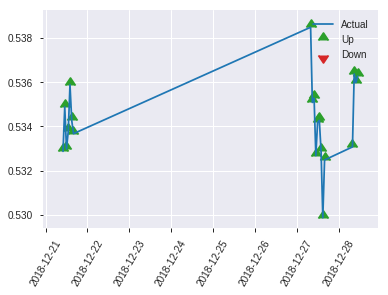


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2646915744941226
RMSE: 0.5144818505002121
LogLoss: 0.7264281590467437
Mean Per-Class Error: 0.41750062029608803
AUC: 0.5656273261103301
pr_auc: 0.5140627766898421
Gini: 0.13125465222066013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44942352175712585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    109  0.9646   (109.0/113.0)
1      1    106  0.0093   (1.0/107.0)
Total  5    215  0.5      (110.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449424     0.658385  214
max f2                       0.415498     0.825617  219
max f0point5                 0.570516     0.579915  149
max accuracy                 0.611743     0.581818  110
max precision                0.705936     0.612903  30
max recall                   0.415498     1         219
max specificity              0.807076     0.99115   0
max absolute_mcc             0.570516     0.176615  149
max min_per_class_accuracy   0.615882     0.575221  109
max mean_per_class_accuracy  0.609963     0.582499  114

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 61.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.791853           0.685358  0.685358           0.333333         0.800051  0.333333                    0.800051            0.00934579      0.00934579                 -31.4642  -31.4642
    2        0.0227273                   0.77957            1.02804   0.82243            0.5              0.78644   0.4                         0.794607            0.00934579      0.0186916                  2.80374   -17.757
    3        0.0318182                   0.764345           1.02804   0.881175           0.5              0.771452  0.428571                    0.787991            0.00934579      0.0280374                  2.80374   -11.8825
    4        0.0409091                   0.761253           0         0.685358           0                0.761619  0.333333                    0.782131            0               0.0280374                  -100      -31.4642
    5        0.05                        0.754313           1.02804   0.747664           0.5              0.758027  0.363636                    0.777748            0.00934579      0.0373832                  2.80374   -25.2336
    6        0.1                         0.716002           1.30841   1.02804            0.636364         0.737111  0.5                         0.75743             0.0654206       0.102804                   30.8411   2.80374
    7        0.15                        0.702276           1.49533   1.1838             0.727273         0.71018   0.575758                    0.74168             0.0747664       0.17757                    49.5327   18.3801
    8        0.2                         0.68914            0.934579  1.1215             0.454545         0.695663  0.545455                    0.730175            0.046729        0.224299                   -6.54206  12.1495
    9        0.3                         0.66184            1.02804   1.09034            0.5              0.674507  0.530303                    0.711619            0.102804        0.327103                   2.80374   9.03427
    10       0.4                         0.639825           0.934579  1.0514             0.454545         0.653728  0.511364                    0.697146            0.0934579       0.420561                   -6.54206  5.14019
    11       0.5                         0.613813           1.58879   1.15888            0.772727         0.629226  0.563636                    0.683562            0.158879        0.579439                   58.8785   15.8879
    12       0.6                         0.592539           0.934579  1.1215             0.454545         0.603355  0.545455                    0.670194            0.0934579       0.672897                   -6.54206  12.1495
    13       0.7                         0.566167           1.02804   1.10814            0.5              0.577551  0.538961                    0.65696             0.102804        0.775701                   2.80374   10.8144
    14       0.8                         0.528704           0.654206  1.0514             0.318182         0.553031  0.511364                    0.643969            0.0654206       0.841121                   -34.5794  5.14019
    15       0.9                         0.49738            0.654206  1.00727            0.318182         0.516756  0.489899                    0.629834            0.0654206       0.906542                   -34.5794  0.726895
    16       1                           0.415498           0.934579  1                  0.454545         0.465279  0.486364                    0.613378    

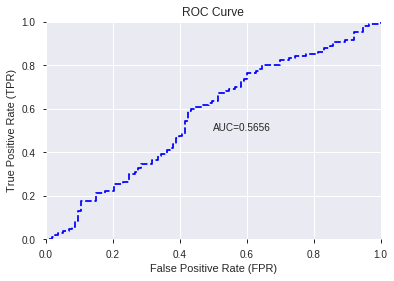

This function is available for GLM models only


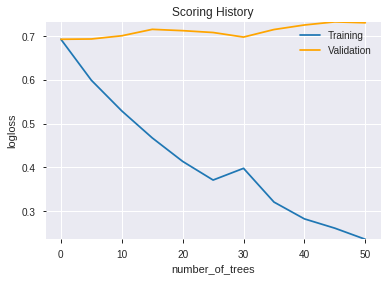

--2019-08-28 15:48:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_154812_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_154812_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['PLUS_DI_8',
 'OBV',
 'VAR_8',
 'HT_PHASOR_quadrature',
 'ADXR_12',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'WILLR_20',
 'TRIX_14',
 'ADOSC',
 'WILLR_12',
 'BETA_24',
 'MAVP_8_0',
 'BETA_14',
 'MOM_24',
 'BBANDS_upperband_14_3_4',
 'NATR_14',
 'PPO',
 'BBANDS_upperband_8_5_2',
 'CORREL_14',
 'AROONOSC_8',
 'STDDEV_30',
 'BBANDS_middleband_8_0_2',
 'BBANDS_upperband_24_0_5',
 'BBANDS_upperband_14_5_2',
 'BBANDS_lowerband_24_5_4',
 'STOCHRSI_fastk',
 'aroonup_14',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_lowerband_14_3_3',
 'CORREL_12',
 'BBANDS_upperband_30_5_3',
 'BBANDS_upperband_24_2_3',
 'BBANDS_lowerband_24_6_5',
 'BBANDS_lowerband_30_2_5',
 'BBANDS_lowerband_30_5_4',
 'KAMA_12',
 'BBANDS_middleband_14_0_2',
 'dayofweek',
 'MIDPOINT_12',
 'BBANDS_lowerband_20_1_2',
 'MA_14_2',
 'BBANDS_lowerband_24_7_3',
 'BBANDS_lowerband_30_2_2',
 'BBANDS_middleband_14_5_2',
 'BBANDS_middleband_14_6_3',
 'CDLDRAGONFLYDOJI',
 'CDLDARKCLOUDCOVER']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 894 924] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_154841  0.523943  0.740685              0.500000  0.519040  0.269403
1  DeepLearning_grid_1_AutoML_20190828_154841_model_1  0.506038  3.854807              0.500000  0.692639  0.479749
2  DeepLearning_grid_1_AutoML_20190828_154841_model_9  0.500000  0.692812              0.500000  0.499832  0.249832
3  DeepLearning_grid_1_AutoML_20190828_154841_model_5  0.500000  0.693606              0.500000  0.500230  0.250230
4  DeepLearning_grid_1_AutoML_20190828_154841_model_7  0.500000  0.695953              0.500000  0.501390  0.251392
5  DeepLearning_grid_1_AutoML_20190828_154841_model_8  0.500000  0.692848              0.500000  0.499850  0.249851
6  DeepLearning_grid_1_AutoML_20190828_154841_model_6  0.500000  0.692841              0.500000  0.499847  0.249847
7  DeepLearning_grid_1_AutoML_20190828_154841_model_2  0.478869  0.963529              0.495575  0.589888  0.347968
8  DeepLearning_grid_1_AutoML_20190828_154841_model_3  0.470019  0.909599              0.500000  0.573911  0.329374
9  DeepLearning_grid_1_AutoML_20190828_154841_model_4  0.462741  1.215695              0.495575  0.622790  0.387868

variable  relative_importance  scaled_importance  percentage
0                           AD             1.000000           1.000000    0.001767
1         HT_PHASOR_quadrature             0.945529           0.945529    0.001671
2                 STOCHF_fastk             0.911154           0.911154    0.001610
3                   aroonup_14             0.908972           0.908972    0.001606
4                  HT_DCPERIOD             0.901708           0.901708    0.001594
...                        ...                  ...                ...         ...
1031                  WCLPRICE             0.291828           0.291828    0.000516
1032                  TRIMA_12             0.287351           0.287351    0.000508
1033  BBANDS_middleband_12_3_3             0.260402           0.260402    0.000460
1034                   ROCP_30             0.249730           0.249730    0.000441
1035    BBANDS_lowerband_8_1_3             0.248712           0.248712    0.000440

[1036 rows x 4 columns]

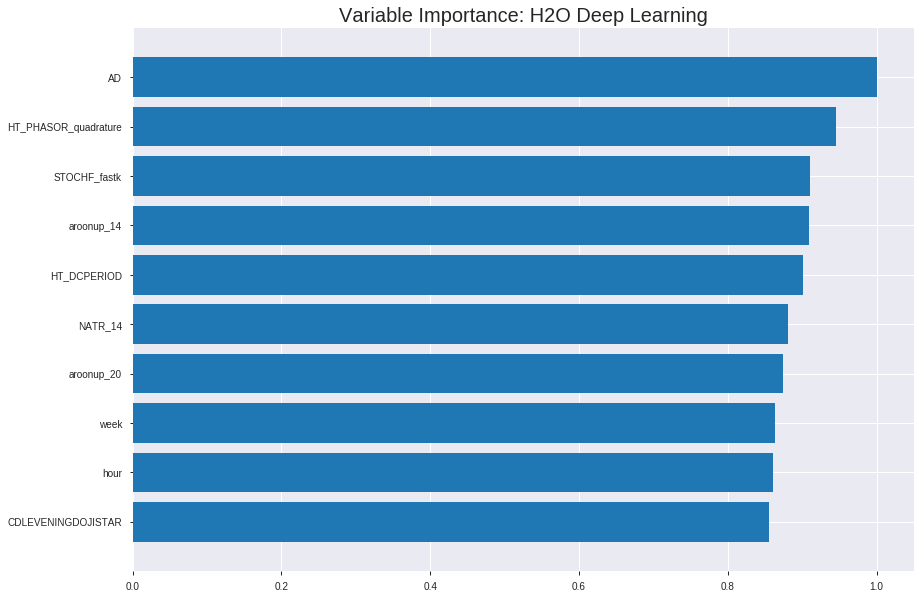

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_154841


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2409469105806313
RMSE: 0.4908634337375634
LogLoss: 0.6714754608783051
Mean Per-Class Error: 0.4111897042931526
AUC: 0.6142226558397783
pr_auc: 0.6294738914100502
Gini: 0.22844531167955662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23025498610655115: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      55   699   0.9271   (699.0/754.0)
1      7    776   0.0089   (7.0/783.0)
Total  62   1475  0.4593   (706.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.230255     0.687334  357
max f2                       0.19522      0.842321  371
max f0point5                 0.376383     0.605279  257
max accuracy                 0.384057     0.592062  251
max precision                0.999919     1         0
max recall                   0.122388     1         384
max specificity              0.999919     1         0
max absolute_mcc             0.376383     0.191635  257
max min_per_class_accuracy   0.491414     0.571618  180
max mean_per_class_accuracy  0.384057     0.58881   251

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104099                   0.9182             1.96296   1.96296            1                0.957421  1                           0.957421            0.0204342       0.0204342                  96.2963    96.2963
    2        0.0201692                   0.852538           1.8321    1.89964            0.933333         0.892164  0.967742                    0.925845            0.0178799       0.0383142                  83.2099    89.9642
    3        0.0305791                   0.797941           1.84028   1.87943            0.9375           0.827568  0.957447                    0.892389            0.0191571       0.0574713                  84.0278    87.9433
    4        0.0403383                   0.736251           1.57037   1.80466            0.8              0.76614   0.919355                    0.861845            0.0153257       0.0727969                  57.037     80.4659
    5        0.0500976                   0.692135           1.70123   1.78451            0.866667         0.713958  0.909091                    0.833036            0.0166028       0.0893997                  70.1235    78.4512
    6        0.100195                    0.631949           1.0962    1.44036            0.558442         0.646303  0.733766                    0.73967             0.054917        0.144317                   9.62001    44.0356
    7        0.150293                    0.625942           1.04521   1.30864            0.532468         0.628537  0.666667                    0.702625            0.0523627       0.196679                   4.5214     30.8642
    8        0.20039                     0.620873           0.994228  1.23004            0.506494         0.623248  0.626623                    0.682781            0.0498084       0.246488                   -0.577201  23.0038
    9        0.299935                    0.612821           1.06488   1.17522            0.542484         0.616663  0.598698                    0.660837            0.106003        0.35249                    6.48753    17.5223
    10       0.40013                     0.600572           1.12169   1.16182            0.571429         0.608218  0.59187                     0.647661            0.112388        0.464879                   12.1693    16.1819
    11       0.500325                    0.492015           1.05796   1.14102            0.538961         0.565028  0.581274                    0.631113            0.106003        0.570881                   5.79606    14.102
    12       0.59987                     0.423242           1.09053   1.13264            0.555556         0.454578  0.577007                    0.601818            0.108557        0.679438                   9.0535     13.2642
    13       0.700065                    0.373044           1.05796   1.12195            0.538961         0.395009  0.571561                    0.572219            0.106003        0.785441                   5.79606    12.1954
    14       0.79961                     0.323586           0.7313    1.07332            0.372549         0.350492  0.546786                    0.544616            0.0727969       0.858238                   -26.87     7.33207
    15       0.899805                    0.267956           0.777537  1.04038            0.396104         0.295497  0.530007                    0.516876            0.0779055       0.936143                   -22.2463   4.03846
    16       1                           0.02365            0.637326  1                  0.324675         0.216179  0.509434                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25919053792872665
RMSE: 0.5091075897378928
LogLoss: 0.7117105920857881
Mean Per-Class Error: 0.4763307493540052
AUC: 0.48070284237726096
pr_auc: 0.49872530463533127
Gini: -0.03859431524547807
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3637962686260351: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    221  0.9822   (221.0/225.0)
1      1    214  0.0047   (1.0/215.0)
Total  5    435  0.5045   (222.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363796     0.658462  394
max f2                       0.350327     0.82756   398
max f0point5                 0.363796     0.547315  394
max accuracy                 0.611657     0.534091  13
max precision                0.619738     1         0
max recall                   0.350327     1         398
max specificity              0.619738     1         0
max absolute_mcc             0.611657     0.125858  13
max min_per_class_accuracy   0.530889     0.47907   187
max mean_per_class_accuracy  0.610722     0.523669  15

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 51.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.615102           1.63721   1.63721            0.8              0.617237  0.8                         0.617237            0.0186047       0.0186047                  63.7209   63.7209
    2        0.0204545                   0.612448           2.04651   1.81912            1                0.613904  0.888889                    0.615756            0.0186047       0.0372093                  104.651   81.9121
    3        0.0318182                   0.611826           1.22791   1.60797            0.6              0.612084  0.785714                    0.614444            0.0139535       0.0511628                  22.7907   60.7973
    4        0.0409091                   0.610525           1.53488   1.59173            0.75             0.611358  0.777778                    0.613758            0.0139535       0.0651163                  53.4884   59.1731
    5        0.05                        0.609775           0.511628  1.39535            0.25             0.610029  0.681818                    0.61308             0.00465116      0.0697674                  -48.8372  39.5349
    6        0.1                         0.606163           0.651163  1.02326            0.318182         0.607604  0.5                         0.610342            0.0325581       0.102326                   -34.8837  2.32558
    7        0.15                        0.601886           0.837209  0.96124            0.409091         0.604367  0.469697                    0.60835             0.0418605       0.144186                   -16.2791  -3.87597
    8        0.2                         0.594894           1.02326   0.976744           0.5              0.597831  0.477273                    0.605721            0.0511628       0.195349                   2.32558   -2.32558
    9        0.3                         0.570017           1.06977   1.00775            0.522727         0.585499  0.492424                    0.59898             0.106977        0.302326                   6.97674   0.775194
    10       0.4                         0.558857           0.837209  0.965116           0.409091         0.561787  0.471591                    0.589682            0.0837209       0.386047                   -16.2791  -3.48837
    11       0.5                         0.529114           0.930233  0.95814            0.454545         0.545454  0.468182                    0.580836            0.0930233       0.47907                    -6.97674  -4.18605
    12       0.6                         0.488619           0.790698  0.930233           0.386364         0.51163   0.454545                    0.569302            0.0790698       0.55814                    -20.9302  -6.97674
    13       0.7                         0.457096           1.34884   0.990033           0.659091         0.472807  0.483766                    0.555517            0.134884        0.693023                   34.8837   -0.996678
    14       0.8                         0.433607           1.02326   0.994186           0.5              0.443948  0.485795                    0.541571            0.102326        0.795349                   2.32558   -0.581395
    15       0.9                         0.410605           1.02326   0.997416           0.5              0.424032  0.487374                    0.528511            0.102326        0.897674                   2.32558   -0.258398
    16       1                           0.23379            1.02326   1                  0.5              0.386924  0.488636                    0.514


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:48:42  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:48:42  0.596 sec   8491 obs/sec      1         1             1537       0.654751         2.03456             -0.715404      0.538712        0.538269           1.34954          0.490566                         0.688095           3.23794               -0.894879        0.459979          0.459015             0.818605           0.5
    2019-08-28 15:48:43  2.335 sec   8463 obs/sec      10        10            15370      0.490863         0.671475            0.0358691      0.614223        0.629474           1.96296          0.459336                         0.509108           0.711711              -0.0372979       0.480703          0.498725             1.63721            0.504545

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
AD                        1.0                    1.0                  0.0017673696618655493
HT_PHASOR_quadrature      0.9455286860466003     0.9455286860466003   0.0016710987141423572
STOCHF_fastk              0.9111542105674744     0.9111542105674744   0.0016103463090380086
aroonup_14                0.9089719653129578     0.9089719653129578   0.0016064894749804259
HT_DCPERIOD               0.9017081260681152     0.9017081260681152   0.0015936515858704229
---                       ---                    ---                  ---
WCLPRICE                  0.2918282747268677     0.2918282747268677   0.0005157684392268308
TRIMA_12                  0.28735148906707764    0.28735148906707764  0.000507856304069043
BBANDS_middleband_12_3_3  0.26040172576904297    0.26040172576904297  0.000460226110021639
ROCP_30                   0.2497299611568451     0.2497299611568451   0.00044136515700747005
BBANDS_lowerband_8_1_3    0.24871225655078888    0.24871225655078888  0.0004395664967619855


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5454545454545454)

('F1', 0.654434250764526)

('auc', 0.5239434289967745)

('logloss', 0.7406852870912563)

('mean_per_class_error', 0.4536432056901828)

('rmse', 0.5190404399197802)

('mse', 0.26940297827211895)

deeplearning prediction progress: |███████████████████████████████████████| 100%


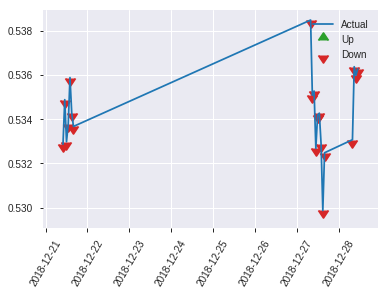


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26940297827211895
RMSE: 0.5190404399197802
LogLoss: 0.7406852870912563
Mean Per-Class Error: 0.4536432056901828
AUC: 0.5239434289967745
pr_auc: 0.4917044408609315
Gini: 0.04788685799354897
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16022488456685666: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    107  0        (0.0/107.0)
Total  0    220  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.160225     0.654434  219
max f2                       0.160225     0.825617  219
max f0point5                 0.245733     0.550688  172
max accuracy                 0.402263     0.545455  116
max precision                0.496788     0.552632  37
max recall                   0.160225     1         219
max specificity              0.558391     0.99115   0
max absolute_mcc             0.554905     0.093205  1
max min_per_class_accuracy   0.410759     0.530973  109
max mean_per_class_accuracy  0.402263     0.546357  116

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 38.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.553625           0.685358  0.685358           0.333333         0.555683  0.333333                    0.555683            0.00934579      0.00934579                 -31.4642  -31.4642
    2        0.0227273                   0.551319           1.02804   0.82243            0.5              0.552259  0.4                         0.554314            0.00934579      0.0186916                  2.80374   -17.757
    3        0.0318182                   0.54594            1.02804   0.881175           0.5              0.548703  0.428571                    0.552711            0.00934579      0.0280374                  2.80374   -11.8825
    4        0.0409091                   0.538891           0         0.685358           0                0.544731  0.333333                    0.550937            0               0.0280374                  -100      -31.4642
    5        0.05                        0.530308           1.02804   0.747664           0.5              0.537131  0.363636                    0.548427            0.00934579      0.0373832                  2.80374   -25.2336
    6        0.1                         0.512484           1.1215    0.934579           0.545455         0.522691  0.454545                    0.535559            0.0560748       0.0934579                  12.1495   -6.54206
    7        0.15                        0.499338           1.30841   1.05919            0.636364         0.50706   0.515152                    0.52606             0.0654206       0.158879                   30.8411   5.919
    8        0.2                         0.492666           1.30841   1.1215             0.636364         0.496366  0.545455                    0.518636            0.0654206       0.224299                   30.8411   12.1495
    9        0.3                         0.473507           0.934579  1.05919            0.454545         0.484651  0.515152                    0.507308            0.0934579       0.317757                   -6.54206  5.919
    10       0.4                         0.437716           0.654206  0.957944           0.318182         0.45773   0.465909                    0.494913            0.0654206       0.383178                   -34.5794  -4.20561
    11       0.5                         0.410552           1.49533   1.06542            0.727273         0.422925  0.518182                    0.480516            0.149533        0.53271                    49.5327   6.54206
    12       0.6                         0.384191           0.747664  1.01246            0.363636         0.398671  0.492424                    0.466875            0.0747664       0.607477                   -25.2336  1.24611
    13       0.7                         0.325917           1.30841   1.05474            0.636364         0.356656  0.512987                    0.451129            0.130841        0.738318                   30.8411   5.47397
    14       0.8                         0.243331           0.934579  1.03972            0.454545         0.283225  0.505682                    0.430141            0.0934579       0.831776                   -6.54206  3.97196
    15       0.9                         0.189414           0.747664  1.00727            0.363636         0.204421  0.489899                    0.405061            0.0747664       0.906542                   -25.2336  0.726895
    16       1                           0.160225           0.934579  1                  0.454545         0.180207  0.486364                    0.382576      

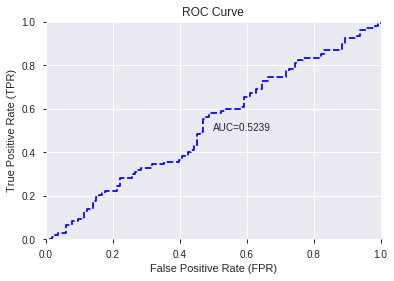

This function is available for GLM models only


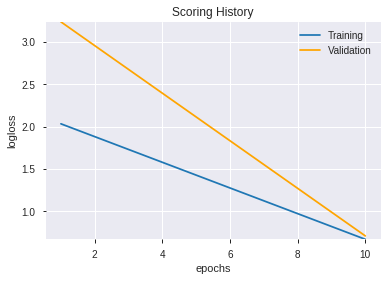

--2019-08-28 16:12:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_154841',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_154841',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_a92b'

['AD',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'aroonup_14',
 'HT_DCPERIOD',
 'NATR_14',
 'aroonup_20',
 'week',
 'hour',
 'CDLEVENINGDOJISTAR',
 'ADXR_12',
 'OBV',
 'quarter',
 'BBANDS_upperband_14_3_4',
 'BBANDS_lowerband_24_6_5',
 'BBANDS_lowerband_24_7_3',
 'BBANDS_middleband_8_0_2',
 'DX_12',
 'BBANDS_upperband_8_5_2',
 'day',
 'BBANDS_lowerband_30_5_5',
 'BBANDS_upperband_30_1_4',
 'CDLDARKCLOUDCOVER',
 'MA_14_2',
 'CDLHOMINGPIGEON',
 'aroondown_12',
 'CORREL_12',
 'BETA_24',
 'BBANDS_upperband_20_3_5',
 'BBANDS_upperband_24_2_3',
 'STOCHRSI_fastk',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_30_5_5',
 'CDLUNIQUE3RIVER',
 'ADX_20',
 'aroonup_12',
 'SAREXT',
 'BBANDS_middleband_8_2_5',
 'MINUS_DI_24',
 'month',
 'BBANDS_lowerband_30_5_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_upperband_30_5_4',
 'BBANDS_middleband_8_1_5',
 'BBANDS_lowerband_20_1_2',
 'MIDPOINT_12',
 'MINUS_DI_14',
 'BBANDS_lowerband_24_5_4',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_24_0_2',
 'BBANDS_up

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_161346_model_1  0.493259  0.753084              0.478124  0.527564  0.278324

variable  relative_importance  scaled_importance    percentage
0                       TRANGE         6.435242e-03           1.000000  7.920561e-03
1          CDLXSIDEGAP3METHODS         6.403807e-03           0.995115  7.881871e-03
2               CDLMORNINGSTAR         5.875969e-03           0.913092  7.232202e-03
3                          DIV         5.837704e-03           0.907146  7.185105e-03
4                          SUB         5.629827e-03           0.874843  6.929248e-03
...                        ...                  ...                ...           ...
1031  BBANDS_middleband_14_4_3         1.833535e-06           0.000285  2.256733e-06
1032                     MIN_8         8.009712e-07           0.000124  9.858435e-07
1033              MINMAX_min_8         7.660284e-07           0.000119  9.428355e-07
1034  BBANDS_middleband_14_2_5         5.701918e-07           0.000089  7.017978e-07
1035  BBANDS_middleband_14_4_4         3.499878e-07           0.000054  4.307685e-07

[1036 rows x 4 columns]

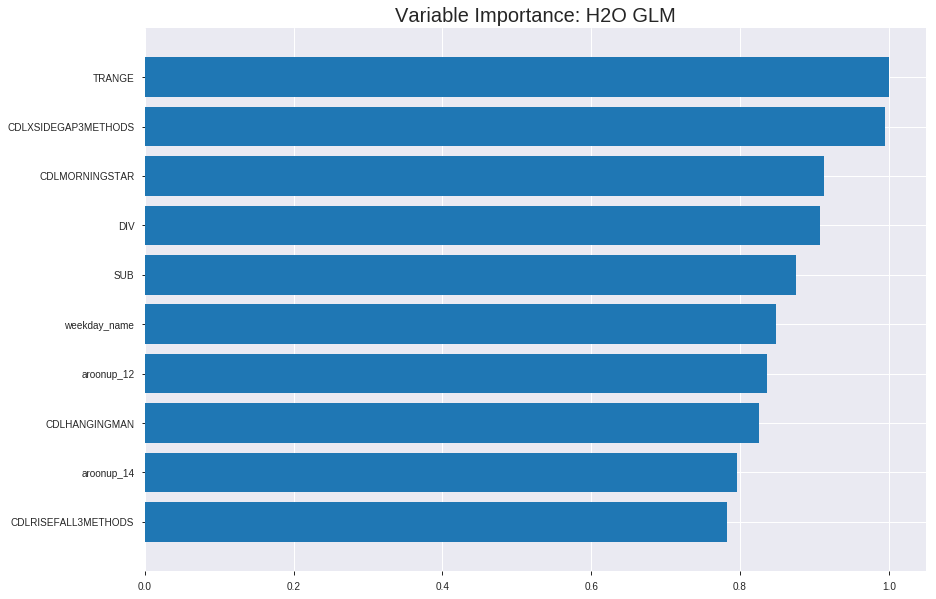

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_161346_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24617059162683635
RMSE: 0.4961558138597555
LogLoss: 0.6854603130612522
Null degrees of freedom: 1536
Residual degrees of freedom: 500
Null deviance: 2130.187230760045
Residual deviance: 2107.1050023502894
AIC: 4181.105002350289
AUC: 0.584532556886897
pr_auc: 0.5788993647182676
Gini: 0.16906511377379396
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4484157820133131: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   730   0.9682   (730.0/754.0)
1      4    779   0.0051   (4.0/783.0)
Total  28   1509  0.4776   (734.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448416     0.679756  377
max f2                       0.448416     0.839259  377
max f0point5                 0.489724     0.58673   264
max accuracy                 0.498524     0.56864   233
max precision                0.614319     1         0
max recall                   0.3953       1         399
max specificity              0.614319     1         0
max absolute_mcc             0.489724     0.138624  264
max min_per_class_accuracy   0.507861     0.543767  202
max mean_per_class_accuracy  0.498524     0.56678   233

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.585766           1.34954   1.34954            0.6875           0.594301  0.6875                      0.594301            0.0140485       0.0140485                  34.9537   34.9537
    2        0.0201692                   0.575091           1.17778   1.26643            0.6              0.579845  0.645161                    0.587306            0.0114943       0.0255428                  17.7778   26.6428
    3        0.0305791                   0.571245           1.47222   1.33649            0.75             0.57332   0.680851                    0.582545            0.0153257       0.0408685                  47.2222   33.6485
    4        0.0403383                   0.565247           0.785185  1.20311            0.4              0.568204  0.612903                    0.579075            0.00766284      0.0485313                  -21.4815  20.3106
    5        0.0500976                   0.562051           1.17778   1.19817            0.6              0.563755  0.61039                     0.576091            0.0114943       0.0600255                  17.7778   19.8172
    6        0.100195                    0.551967           1.27465   1.23641            0.649351         0.556241  0.62987                     0.566166            0.063857        0.123883                   27.4651   23.6412
    7        0.150293                    0.544352           1.27465   1.24916            0.649351         0.548073  0.636364                    0.560135            0.063857        0.187739                   27.4651   24.9158
    8        0.20039                     0.538552           1.0962    1.21092            0.558442         0.541254  0.616883                    0.555415            0.054917        0.242656                   9.62001   21.0919
    9        0.299935                    0.527147           1.10336   1.17522            0.562092         0.533159  0.598698                    0.548028            0.109834        0.35249                    10.3365   17.5223
    10       0.40013                     0.518465           0.981481  1.12671            0.5              0.522965  0.573984                    0.541752            0.0983397       0.45083                    -1.85185  12.6709
    11       0.500325                    0.507864           0.917749  1.08486            0.467532         0.512806  0.552666                    0.535955            0.091954        0.542784                   -8.22511  8.48625
    12       0.59987                     0.498279           1.23166   1.10922            0.627451         0.502883  0.565076                    0.530467            0.122605        0.66539                    23.1663   10.9223
    13       0.700065                    0.48943            0.968735  1.08912            0.493506         0.493552  0.554833                    0.525184            0.0970626       0.762452                   -3.1265   8.91161
    14       0.79961                     0.481558           0.872428  1.06214            0.444444         0.485159  0.54109                     0.520201            0.0868455       0.849298                   -12.7572  6.21403
    15       0.899805                    0.469798           0.752044  1.02761            0.383117         0.476457  0.5235                      0.51533             0.0753512       0.924649                   -24.7956  2.76104
    16       1                           0.3953             0.752044  1                  0.383117         0.456484  0.509434                    0.509434         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2623371901742229
RMSE: 0.5121886275330827
LogLoss: 0.7185215359282108
Null degrees of freedom: 439
Residual degrees of freedom: -597
Null deviance: 610.5035894343387
Residual deviance: 632.2989516168254
AIC: 2706.2989516168254
AUC: 0.5137674418604651
pr_auc: 0.49526339448979784
Gini: 0.02753488372093016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5351233780987066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    220  0.9778   (220.0/225.0)
1      1    214  0.0047   (1.0/215.0)
Total  6    434  0.5023   (221.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535123     0.659476  393
max f2                       0.526209     0.826923  399
max f0point5                 0.578668     0.557315  307
max accuracy                 0.578668     0.536364  307
max precision                0.65689      0.666667  5
max recall                   0.526209     1         399
max specificity              0.696353     0.995556  0
max absolute_mcc             0.578668     0.102075  307
max min_per_class_accuracy   0.600805     0.511111  203
max mean_per_class_accuracy  0.578668     0.542636  307

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 59.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.658034           1.22791   1.22791            0.6              0.669806  0.6                         0.669806            0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.65308            1.02326   1.13695            0.5              0.656379  0.555556                    0.663839            0.00930233      0.0232558                  2.32558   13.6951
    3        0.0318182                   0.650977           0.818605  1.02326            0.4              0.651619  0.5                         0.659475            0.00930233      0.0325581                  -18.1395  2.32558
    4        0.0409091                   0.647979           1.02326   1.02326            0.5              0.649214  0.5                         0.657194            0.00930233      0.0418605                  2.32558   2.32558
    5        0.05                        0.645681           1.53488   1.11628            0.75             0.646814  0.545455                    0.655307            0.0139535       0.055814                   53.4884   11.6279
    6        0.1                         0.637383           1.11628   1.11628            0.545455         0.641312  0.545455                    0.64831             0.055814        0.111628                   11.6279   11.6279
    7        0.15                        0.633296           0.837209  1.02326            0.409091         0.635693  0.5                         0.644104            0.0418605       0.153488                   -16.2791  2.32558
    8        0.2                         0.626289           0.837209  0.976744           0.409091         0.630006  0.477273                    0.640579            0.0418605       0.195349                   -16.2791  -2.32558
    9        0.3                         0.617211           0.883721  0.945736           0.431818         0.621563  0.462121                    0.634241            0.0883721       0.283721                   -11.6279  -5.42636
    10       0.4                         0.609079           1.11628   0.988372           0.545455         0.613159  0.482955                    0.62897             0.111628        0.395349                   11.6279   -1.16279
    11       0.5                         0.600639           1.16279   1.02326            0.568182         0.604415  0.5                         0.624059            0.116279        0.511628                   16.2791   2.32558
    12       0.6                         0.592689           0.837209  0.992248           0.409091         0.597263  0.484848                    0.619593            0.0837209       0.595349                   -16.2791  -0.775194
    13       0.7                         0.585696           1.34884   1.04319            0.659091         0.58929   0.50974                     0.615264            0.134884        0.730233                   34.8837   4.31894
    14       0.8                         0.575326           1.02326   1.0407             0.5              0.580871  0.508523                    0.610965            0.102326        0.832558                   2.32558   4.06977
    15       0.9                         0.557802           0.744186  1.00775            0.363636         0.56575   0.492424                    0.605941            0.0744186       0.906977                   -25.5814  0.775194
    16       1                           0.526209           0.930233  1                  0.454545         0.545742  0.488636                    0.599921   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:13:48  0.000 sec   2            3.4       1037          1.37092           1.43704
    2019-08-28 16:13:50  2.023 sec   4            2.4       1037          1.36769           1.43964
    2019-08-28 16:13:52  4.028 sec   6            1.8       1037          1.36385           1.44295
    2019-08-28 16:13:54  6.004 sec   8            1.3       1037          1.35934           1.44732
    2019-08-28 16:13:56  8.008 sec   10           0.94      1037          1.35419           1.45262

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5363636363636364)

('F1', 0.6625000000000001)

('auc', 0.49325944917707387)

('logloss', 0.7530843848453065)

('mean_per_class_error', 0.4552973285915144)

('rmse', 0.5275638373600648)

('mse', 0.278323602490077)

glm prediction progress: |████████████████████████████████████████████████| 100%


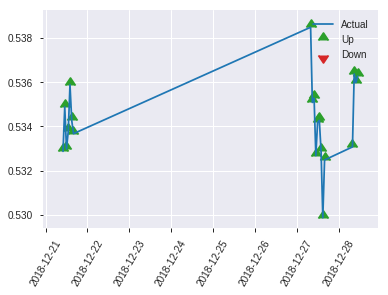


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.278323602490077
RMSE: 0.5275638373600648
LogLoss: 0.7530843848453065
Null degrees of freedom: 219
Residual degrees of freedom: -817
Null deviance: 305.28953504515266
Residual deviance: 331.35712933193486
AIC: 2405.3571293319346
AUC: 0.49325944917707387
pr_auc: 0.476472724096309
Gini: -0.013481101645852256
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6143109458496434: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    107  0.9469   (107.0/113.0)
1      1    106  0.0093   (1.0/107.0)
Total  7    213  0.4909   (108.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.614311     0.6625    212
max f2                       0.601486     0.828173  217
max f0point5                 0.625429     0.558282  176
max accuracy                 0.625429     0.536364  176
max precision                0.72374      1         0
max recall                   0.601486     1         217
max specificity              0.72374      1         0
max absolute_mcc             0.614311     0.124591  212
max min_per_class_accuracy   0.645915     0.485981  108
max mean_per_class_accuracy  0.625429     0.544703  176

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 65.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.71429            1.37072   1.37072            0.666667         0.717842  0.666667                    0.717842            0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.713445           2.05607   1.64486            1                0.713915  0.8                         0.716271            0.0186916       0.0373832                  105.607   64.486
    3        0.0318182                   0.711843           0         1.1749             0                0.712774  0.571429                    0.715272            0               0.0373832                  -100      17.49
    4        0.0409091                   0.70867            1.02804   1.14226            0.5              0.711296  0.555556                    0.714388            0.00934579      0.046729                   2.80374   14.2264
    5        0.05                        0.707355           0         0.934579           0                0.707719  0.454545                    0.713176            0               0.046729                   -100      -6.54206
    6        0.1                         0.697388           1.30841   1.1215             0.636364         0.704324  0.545455                    0.70875             0.0654206       0.11215                    30.8411   12.1495
    7        0.15                        0.687266           0.934579  1.05919            0.454545         0.69337   0.515152                    0.703623            0.046729        0.158879                   -6.54206  5.919
    8        0.2                         0.676473           0.373832  0.88785            0.181818         0.681698  0.431818                    0.698142            0.0186916       0.17757                    -62.6168  -11.215
    9        0.3                         0.663388           0.934579  0.903427           0.454545         0.670962  0.439394                    0.689082            0.0934579       0.271028                   -6.54206  -9.65732
    10       0.4                         0.653807           1.02804   0.934579           0.5              0.658468  0.454545                    0.681428            0.102804        0.373832                   2.80374   -6.54206
    11       0.5                         0.645479           1.1215    0.971963           0.545455         0.648948  0.472727                    0.674932            0.11215         0.485981                   12.1495   -2.80374
    12       0.6                         0.640201           0.934579  0.965732           0.454545         0.642585  0.469697                    0.669541            0.0934579       0.579439                   -6.54206  -3.42679
    13       0.7                         0.633437           1.21495   1.00134            0.590909         0.637259  0.487013                    0.664929            0.121495        0.700935                   21.4953   0.133511
    14       0.8                         0.625604           1.40187   1.0514             0.681818         0.629446  0.511364                    0.660494            0.140187        0.841121                   40.1869   5.14019
    15       0.9                         0.619695           0.747664  1.01765            0.363636         0.622757  0.494949                    0.656301            0.0747664       0.915888                   -25.2336  1.76532
    16       1                           0.593605           0.841121  1                  0.409091         0.613176  0.486364                    0.651988        

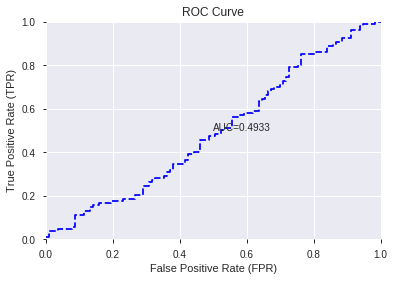

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


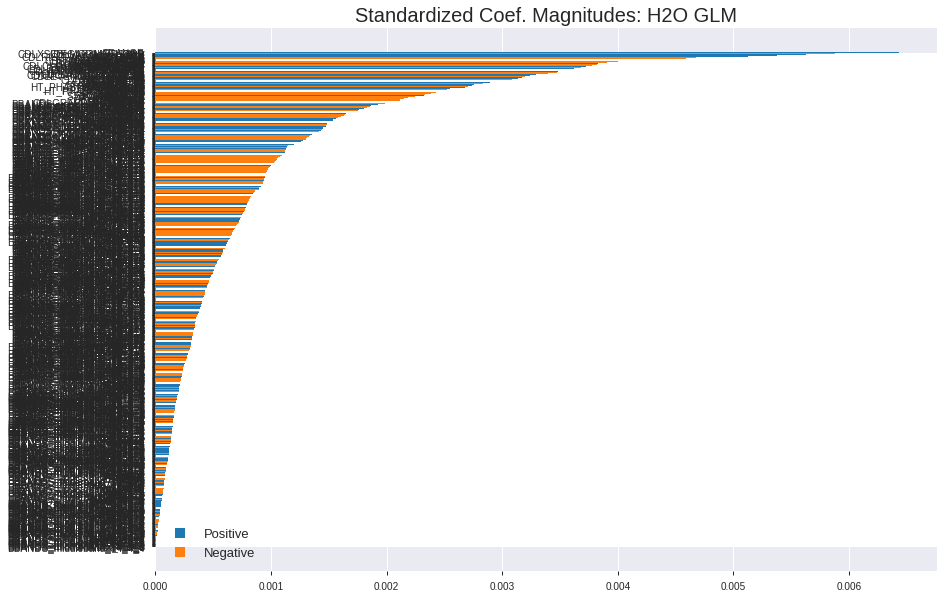

'log_likelihood'
--2019-08-28 16:14:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_161346_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_161346_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['TRANGE',
 'CDLXSIDEGAP3METHODS',
 'CDLMORNINGSTAR',
 'DIV',
 'SUB',
 'weekday_name',
 'aroonup_12',
 'CDLHANGINGMAN',
 'aroonup_14',
 'CDLRISEFALL3METHODS',
 'WILLR_8',
 'day',
 'DX_8',
 'AROONOSC_12',
 'MINUS_DI_8',
 'VAR_12',
 'CDLSHOOTINGSTAR',
 'CORREL_20',
 'MINUS_DI_12',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'STOCH_slowk',
 'STOCHF_fastd',
 'MINUS_DI_14',
 'CDLHIKKAKEMOD',
 'CCI_8',
 'CDLENGULFING',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDL3OUTSIDE',
 'CDLUNIQUE3RIVER',
 'CDLTASUKIGAP',
 'AROONOSC_14',
 'Volume',
 'CDLDARKCLOUDCOVER',
 'CDLHARAMICROSS',
 'VAR_8',
 'MFI_12',
 'CDLIDENTICAL3CROWS',
 'AROONOSC_24',
 'CORREL_12',
 'MFI_14',
 'DX_12',
 'ATR_30',
 'CDLLADDERBOTTOM',
 'CDLMORNINGDOJISTAR',
 'MINUS_DI_20',
 'ATR_24',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'is_month_end',
 'AD',
 'PLUS_DI_24',
 'aroondown_24',
 'PLUS_DI_20',
 'VAR_14',
 'CDL3LINESTRIKE',
 'PLUS_DI_30',
 'NATR_30',
 'MINUS_DI_24',
 'ATR_20',
 'CDLBELTHOLD',
 'NATR_24',
 'PLUS_DI_14',
 'aroonup_24',
 '

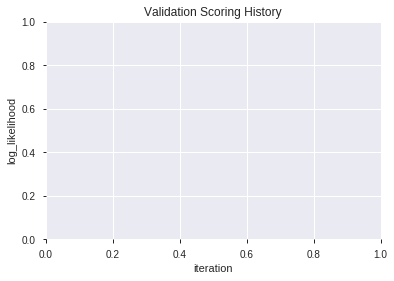

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_161524_model_1  0.547225  0.705045              0.495575  0.505748  0.255781
1               XGBoost_3_AutoML_20190828_161524  0.540650  0.701513              0.491150  0.503959  0.253975
2  XGBoost_grid_1_AutoML_20190828_161524_model_5  0.538003  0.746018              0.500000  0.523153  0.273689
3  XGBoost_grid_1_AutoML_20190828_161524_model_2  0.520263  0.710796              0.500000  0.508514  0.258587
4               XGBoost_2_AutoML_20190828_161524  0.505086  0.711219              0.477876  0.508734  0.258810
5  XGBoost_grid_1_AutoML_20190828_161524_model_3  0.501778  0.719270              0.477876  0.512385  0.262539
6  XGBoost_grid_1_AutoML_20190828_161524_model_6  0.493177  0.729986              0.500000  0.517137  0.267431
7  XGBoost_grid_1_AutoML_20190828_161524_model_4  0.470184  0.719438              0.491150  0.512525  0.262682
8  XGBoost_grid_1_AutoML_20190828_161524_model_7  0.464974  0.752954              0.486974  0.526767  0.277484
9               XGBoost_1_AutoML_20190828_161524  0.449425  0.738474              0.486726  0.520588  0.271012

variable  relative_importance  scaled_importance  percentage
0                  CORREL_20           119.549561           1.000000    0.023589
1                     Volume           119.535927           0.999886    0.023586
2                    WILLR_8            99.125092           0.829155    0.019559
3                      CCI_8            82.014015           0.686025    0.016183
4                HT_DCPERIOD            69.607468           0.582248    0.013735
..                       ...                  ...                ...         ...
265  BBANDS_lowerband_20_6_5             2.978200           0.024912    0.000588
266                  BETA_24             2.314699           0.019362    0.000457
267   BBANDS_upperband_8_3_3             2.213428           0.018515    0.000437
268                  NATR_24             2.141666           0.017914    0.000423
269               PLUS_DI_30             1.964338           0.016431    0.000388

[270 rows x 4 columns]

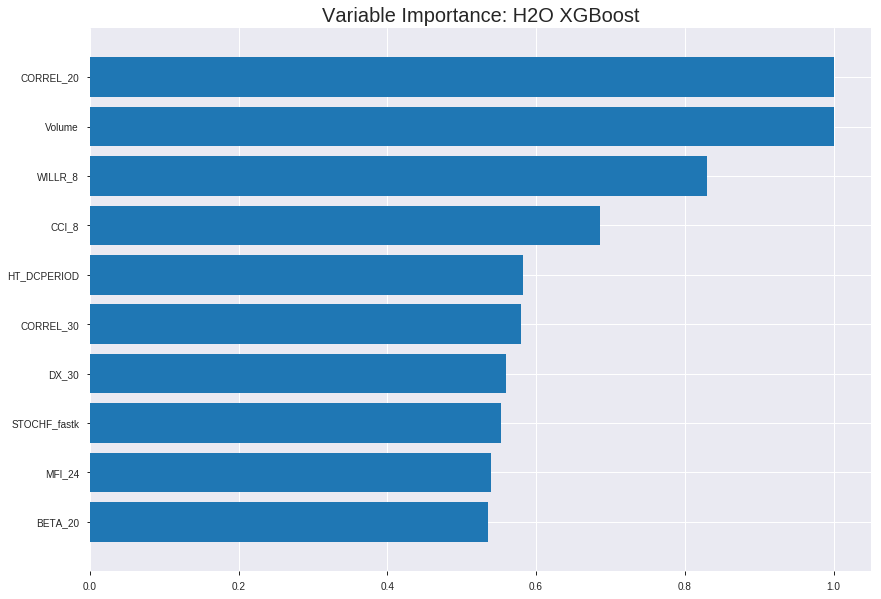

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_161524_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17206347556994273
RMSE: 0.41480534660240664
LogLoss: 0.5324740509117941
Mean Per-Class Error: 0.11550741723155511
AUC: 0.9570312103011271
pr_auc: 0.9581983227914207
Gini: 0.9140624206022543
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5109289407730102: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      653  101  0.134    (101.0/754.0)
1      76   707  0.0971   (76.0/783.0)
Total  729  808  0.1152   (177.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510929     0.888749  190
max f2                       0.448849     0.925216  247
max f0point5                 0.551091     0.907436  153
max accuracy                 0.510929     0.884841  190
max precision                0.769757     1         0
max recall                   0.398554     1         291
max specificity              0.769757     1         0
max absolute_mcc             0.510929     0.769866  190
max min_per_class_accuracy   0.516278     0.88378   185
max mean_per_class_accuracy  0.510929     0.884493  190

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.727076           1.96296    1.96296            1                0.742677  1                           0.742677            0.0204342       0.0204342                  96.2963   96.2963
    2        0.0201692                   0.710963           1.96296    1.96296            1                0.71819   1                           0.730829            0.0191571       0.0395913                  96.2963   96.2963
    3        0.0305791                   0.698131           1.96296    1.96296            1                0.702346  1                           0.721132            0.0204342       0.0600255                  96.2963   96.2963
    4        0.0403383                   0.689129           1.96296    1.96296            1                0.693292  1                           0.714397            0.0191571       0.0791826                  96.2963   96.2963
    5        0.0500976                   0.680595           1.96296    1.96296            1                0.684953  1                           0.708661            0.0191571       0.0983397                  96.2963   96.2963
    6        0.100195                    0.658765           1.96296    1.96296            1                0.670049  1                           0.689355            0.0983397       0.196679                   96.2963   96.2963
    7        0.150293                    0.63827            1.93747    1.95447            0.987013         0.647332  0.995671                    0.675347            0.0970626       0.293742                   93.747    95.4465
    8        0.20039                     0.621739           1.96296    1.95659            1                0.629178  0.996753                    0.663805            0.0983397       0.392082                   96.2963   95.659
    9        0.299935                    0.589445           1.84749    1.92038            0.941176         0.605722  0.978308                    0.644528            0.183908        0.57599                    84.7495   92.0382
    10       0.40013                     0.552669           1.74627    1.87678            0.88961          0.57226   0.956098                    0.626432            0.174968        0.750958                   74.6272   87.6784
    11       0.500325                    0.518557           1.23641    1.74854            0.62987          0.536702  0.890767                    0.608462            0.123883        0.87484                    23.6412   74.8543
    12       0.59987                     0.478722           0.75696    1.584              0.385621         0.499874  0.806941                    0.590443            0.0753512       0.950192                   -24.304   58.3996
    13       0.700065                    0.438095           0.407888   1.41567            0.207792         0.460677  0.72119                     0.57187             0.0408685       0.99106                    -59.2112  41.5668
    14       0.79961                     0.393862           0.0898088  1.25061            0.0457516        0.414969  0.637103                    0.552337            0.00893997      1                          -91.0191  25.061
    15       0.899805                    0.345986           0          1.11135            0                0.369866  0.566161                    0.532019            0               1                          -100      11.1352
    16       1                           0.209306           0          1                  0                0.299748  0.509434                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2588196272556538
RMSE: 0.5087431839893816
LogLoss: 0.7110682534648742
Mean Per-Class Error: 0.42248062015503873
AUC: 0.5226149870801033
pr_auc: 0.5455771022719276
Gini: 0.04522997416020669
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38806813955307007: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    223  0.9911   (223.0/225.0)
1      0    215  0        (0.0/215.0)
Total  2    438  0.5068   (223.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388068     0.658499  397
max f2                       0.388068     0.828197  397
max f0point5                 0.418072     0.546995  392
max accuracy                 0.6302       0.584091  87
max precision                0.746896     1         0
max recall                   0.388068     1         397
max specificity              0.746896     1         0
max absolute_mcc             0.6302       0.190576  87
max min_per_class_accuracy   0.574654     0.506667  196
max mean_per_class_accuracy  0.6302       0.577519  87

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 56.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.727138           2.04651   2.04651            1                0.737741  1                           0.737741            0.0232558       0.0232558                  104.651   104.651
    2        0.0204545                   0.705616           0.511628  1.36434            0.25             0.720669  0.666667                    0.730153            0.00465116      0.027907                   -48.8372  36.4341
    3        0.0318182                   0.700713           1.22791   1.31561            0.6              0.702138  0.642857                    0.720148            0.0139535       0.0418605                  22.7907   31.5615
    4        0.0409091                   0.688194           1.02326   1.25065            0.5              0.695686  0.611111                    0.714712            0.00930233      0.0511628                  2.32558   25.0646
    5        0.05                        0.685615           1.53488   1.30233            0.75             0.687361  0.636364                    0.709739            0.0139535       0.0651163                  53.4884   30.2326
    6        0.1                         0.657549           1.39535   1.34884            0.681818         0.666878  0.659091                    0.688309            0.0697674       0.134884                   39.5349   34.8837
    7        0.15                        0.643336           1.39535   1.36434            0.681818         0.650585  0.666667                    0.675734            0.0697674       0.204651                   39.5349   36.4341
    8        0.2                         0.631262           1.39535   1.37209            0.681818         0.636672  0.670455                    0.665969            0.0697674       0.274419                   39.5349   37.2093
    9        0.3                         0.611704           0.790698  1.17829            0.386364         0.621991  0.575758                    0.651309            0.0790698       0.353488                   -20.9302  17.8295
    10       0.4                         0.592501           0.651163  1.04651            0.318182         0.603702  0.511364                    0.639407            0.0651163       0.418605                   -34.8837  4.65116
    11       0.5                         0.573905           0.883721  1.01395            0.431818         0.583264  0.495455                    0.628179            0.0883721       0.506977                   -11.6279  1.39535
    12       0.6                         0.544337           0.837209  0.984496           0.409091         0.558587  0.481061                    0.61658             0.0837209       0.590698                   -16.2791  -1.55039
    13       0.7                         0.524008           0.837209  0.963455           0.409091         0.534779  0.470779                    0.604894            0.0837209       0.674419                   -16.2791  -3.65449
    14       0.8                         0.497244           0.976744  0.965116           0.477273         0.511679  0.471591                    0.593242            0.0976744       0.772093                   -2.32558  -3.48837
    15       0.9                         0.468019           1.06977   0.976744           0.522727         0.481945  0.477273                    0.580876            0.106977        0.87907                    6.97674   -2.32558
    16       1                           0.363694           1.2093    1                  0.590909         0.435478  0.488636                    0.566336     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:15:40  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.490566                         0.5                0.693147              0.5               0                    1                  0.511364
    2019-08-28 16:15:41  1.260 sec   5                  0.484364         0.662285            0.82099         0.817105           1.96296          0.268055                         0.501327           0.695812              0.50676           0.486853             0.767442           0.511364
    2019-08-28 16:15:42  1.474 sec   10                 0.47241          0.639167            0.86796         0.87096            1.96296          0.24203                          0.50126            0.695661              0.51416           0.54014              2.04651            0.509091
    2019-08-28 16:15:42  1.690 sec   15                 0.46235          0.620002            0.897178        0.899191           1.96296          0.193884                         0.500807           0.694727              0.529881          0.547949             2.04651            0.509091
    2019-08-28 16:15:42  1.914 sec   20                 0.453534         0.603356            0.911843        0.913935           1.96296          0.176318                         0.50357            0.700309              0.522625          0.548195             2.04651            0.509091
    2019-08-28 16:15:42  2.125 sec   25                 0.444933         0.587304            0.922662        0.924433           1.96296          0.163956                         0.505199           0.70364               0.516424          0.543556             2.04651            0.509091
    2019-08-28 16:15:42  2.326 sec   30                 0.438234         0.574883            0.930206        0.932208           1.96296          0.164606                         0.505979           0.705296              0.523152          0.537987             1.63721            0.511364
    2019-08-28 16:15:43  2.629 sec   35                 0.431709         0.56297             0.939317        0.941163           1.96296          0.144437                         0.506373           0.706059              0.517695          0.542575             1.63721            0.509091
    2019-08-28 16:15:43  2.896 sec   40                 0.424396         0.549703            0.948058        0.949652           1.96296          0.124919                         0.508105           0.709678              0.521819          0.548064             1.63721            0.509091
    2019-08-28 16:15:43  3.092 sec   45                 0.419634         0.541096            0.951408        0.952879           1.96296          0.122316                         0.507792           0.709006              0.52555           0.552247             1.63721            0.509091
    2019-08-28 16:15:43  3.291 sec   50                 0.414805         0.532474            0.957031        0.958198           1.96296          0.115159                         0.508743           0.711068              0.522615          0.545577             2.04651            0.506818

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
CORREL_20                119.549560546875       1.0                   0.023588844876847877
Volume                   119.53592681884766     0.9998859575228468    0.02358615474654494
WILLR_8                  99.12509155273438      0.8291547965487313    0.01955880387468238
CCI_8                    82.0140151977539       0.6860252335732884    0.01618254281636363
HT_DCPERIOD              69.60746765136719      0.5822477919027926    0.01373455284308218
---                      ---                    ---                   ---
BBANDS_lowerband_20_6_5  2.9781999588012695     0.024911843633532445  0.0005876416150676872
BETA_24                  2.314699172973633      0.0193618375708378    0.00045672338298921795
BBANDS_upperband_8_3_3   2.213428497314453      0.01851473553887783   0.0004367412245624515
NATR_24                  2.1416664123535156     0.017914464951243173  0.0004225815347866033
PLUS_DI_30               1.9643383026123047     0.016431162888650635  0.0003875921525265995


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5681818181818182)

('F1', 0.656441717791411)

('auc', 0.5472252088330163)

('logloss', 0.7050452404524773)

('mean_per_class_error', 0.4342486146720701)

('rmse', 0.5057484311583872)

('mse', 0.25578147561916986)

xgboost prediction progress: |████████████████████████████████████████████| 100%


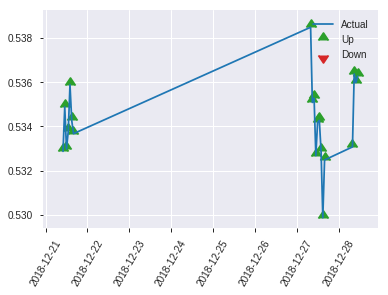


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25578147561916986
RMSE: 0.5057484311583872
LogLoss: 0.7050452404524773
Mean Per-Class Error: 0.4342486146720701
AUC: 0.5472252088330163
pr_auc: 0.5339204772417254
Gini: 0.09445041766603257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.364484578371048: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    112  0.9912   (112.0/113.0)
1      0    107  0        (0.0/107.0)
Total  1    219  0.5091   (112.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364485     0.656442  217
max f2                       0.364485     0.826893  217
max f0point5                 0.557975     0.557461  117
max accuracy                 0.581927     0.568182  88
max precision                0.73602      1         0
max recall                   0.364485     1         217
max specificity              0.73602      1         0
max absolute_mcc             0.621406     0.137837  43
max min_per_class_accuracy   0.569503     0.560748  107
max mean_per_class_accuracy  0.581927     0.565751  88

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 55.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.709626           1.37072   1.37072            0.666667         0.727     0.666667                    0.727               0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.690275           1.02804   1.23364            0.5              0.702169  0.6                         0.717068            0.00934579      0.0280374                  2.80374   23.3645
    3        0.0318182                   0.677508           1.02804   1.1749             0.5              0.68202   0.571429                    0.707054            0.00934579      0.0373832                  2.80374   17.49
    4        0.0409091                   0.670532           2.05607   1.37072            1                0.673976  0.666667                    0.699704            0.0186916       0.0560748                  105.607   37.0717
    5        0.05                        0.66304            1.02804   1.30841            0.5              0.667766  0.636364                    0.693897            0.00934579      0.0654206                  2.80374   30.8411
    6        0.1                         0.640624           1.30841   1.30841            0.636364         0.65149   0.636364                    0.672693            0.0654206       0.130841                   30.8411   30.8411
    7        0.15                        0.628326           0.934579  1.1838             0.454545         0.634567  0.575758                    0.659985            0.046729        0.17757                    -6.54206  18.3801
    8        0.2                         0.621474           1.49533   1.26168            0.727273         0.625333  0.613636                    0.651322            0.0747664       0.252336                   49.5327   26.1682
    9        0.3                         0.597128           0.841121  1.1215             0.409091         0.608988  0.545455                    0.63721             0.0841121       0.336449                   -15.8879  12.1495
    10       0.4                         0.584357           1.21495   1.14486            0.590909         0.590243  0.556818                    0.625468            0.121495        0.457944                   21.4953   14.486
    11       0.5                         0.567748           1.02804   1.1215             0.5              0.576272  0.545455                    0.615629            0.102804        0.560748                   2.80374   12.1495
    12       0.6                         0.548442           0.841121  1.07477            0.409091         0.556552  0.522727                    0.605783            0.0841121       0.64486                    -15.8879  7.47664
    13       0.7                         0.527339           0.560748  1.00134            0.272727         0.538872  0.487013                    0.596224            0.0560748       0.700935                   -43.9252  0.133511
    14       0.8                         0.496242           0.747664  0.969626           0.363636         0.512861  0.471591                    0.585804            0.0747664       0.775701                   -25.2336  -3.03738
    15       0.9                         0.463923           1.1215    0.986501           0.545455         0.480091  0.479798                    0.574058            0.11215         0.88785                    12.1495   -1.34995
    16       1                           0.362703           1.1215    1                  0.545455         0.431232  0.486364                    0.559775         

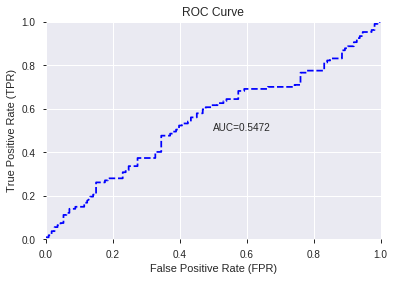

This function is available for GLM models only


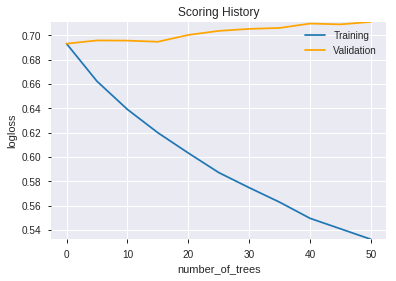

--2019-08-28 16:16:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_161524_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_161524_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CORREL_20',
 'Volume',
 'WILLR_8',
 'CCI_8',
 'HT_DCPERIOD',
 'CORREL_30',
 'DX_30',
 'STOCHF_fastk',
 'MFI_24',
 'BETA_20',
 'BBANDS_lowerband_20_7_5',
 'STDDEV_12',
 'DIV',
 'BOP',
 'MINUS_DI_8',
 'BBANDS_upperband_30_0_5',
 'NATR_12',
 'STOCH_slowd',
 'MACDFIX_hist_8',
 'AROONOSC_14',
 'OBV',
 'BBANDS_upperband_20_5_5',
 'PLUS_DI_8',
 'ADX_20',
 'AROONOSC_30',
 'MOM_8',
 'MACDEXT_hist',
 'WILLR_12',
 'STDDEV_8',
 'day',
 'ADXR_12',
 'weekday_name',
 'DX_24',
 'PLUS_DI_20',
 'CCI_14',
 'BETA_14',
 'BETA_8',
 'ULTOSC',
 'BBANDS_upperband_12_5_2',
 'STOCHRSI_fastd',
 'BBANDS_upperband_14_2_2',
 'CORREL_14',
 'MFI_8',
 'HT_PHASOR_inphase',
 'mama',
 'STOCH_slowk',
 'PLUS_DM_12',
 'TRANGE',
 'MINUS_DI_12',
 'CORREL_12',
 'DX_8',
 'ROC_30',
 'CCI_12',
 'ADX_24',
 'BBANDS_lowerband_20_1_5',
 'PLUS_DI_14',
 'MACDEXT_signal',
 'MINUS_DM_8',
 'ADX_8',
 'MFI_20',
 'BBANDS_upperband_20_7_5',
 'MFI_12',
 'ROC_12',
 'MACD_hist',
 'AD',
 'NATR_30',
 'ADXR_8',
 'PLUS_DM_20',
 'STDDEV_24',
 'BBAND

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

419

['BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperband_12_7_2',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_12_7_2',
 'BBANDS_upperband_12_7_3',
 'BBANDS_middleband_12_7_3',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_7_4',
 'BBANDS_middleband_12_7_4',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'EMA_14',
 'KAMA_14',
 'MIDPOINT_14',
 'MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'TEMA_14',
 'TRIMA_14',
 'WMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MA_14_1',
 'MAVP_14_1',
 '

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_161821_model_3  0.504756  0.784677              0.500000  0.532863  0.283943
1  DeepLearning_grid_1_AutoML_20190828_161821_model_6  0.502357  0.694308              0.500000  0.500581  0.250582
2               DeepLearning_1_AutoML_20190828_161821  0.501902  0.694075              0.500000  0.500454  0.250454
3  DeepLearning_grid_1_AutoML_20190828_161821_model_5  0.500000  0.692979              0.500000  0.499916  0.249916
4  DeepLearning_grid_1_AutoML_20190828_161821_model_8  0.500000  0.693439              0.500000  0.500146  0.250146
5  DeepLearning_grid_1_AutoML_20190828_161821_model_7  0.500000  0.708031              0.500000  0.507315  0.257369
6  DeepLearning_grid_1_AutoML_20190828_161821_model_4  0.493508  1.833667              0.500000  0.685145  0.469423
7  DeepLearning_grid_1_AutoML_20190828_161821_model_1  0.487635  1.595655              0.500000  0.638766  0.408022
8  DeepLearning_grid_1_AutoML_20190828_161821_model_9  0.483252  0.693076              0.465842  0.499965  0.249965
9  DeepLearning_grid_1_AutoML_20190828_161821_model_2  0.411546  0.983328              0.500000  0.585844  0.343213

variable  relative_importance  scaled_importance  percentage
0          CDLMORNINGDOJISTAR             1.000000           1.000000    0.006215
1              CDLEVENINGSTAR             0.961603           0.961603    0.005977
2             CDLHOMINGPIGEON             0.959252           0.959252    0.005962
3           CDLDARKCLOUDCOVER             0.947252           0.947252    0.005887
4                CDLTHRUSTING             0.942350           0.942350    0.005857
..                        ...                  ...                ...         ...
414                 MAVP_14_5             0.321249           0.321249    0.001997
415  BBANDS_middleband_14_1_2             0.320678           0.320678    0.001993
416                 MAVP_20_5             0.313454           0.313454    0.001948
417                  AVGPRICE             0.312333           0.312333    0.001941
418  BBANDS_middleband_24_1_2             0.310166           0.310166    0.001928

[419 rows x 4 columns]

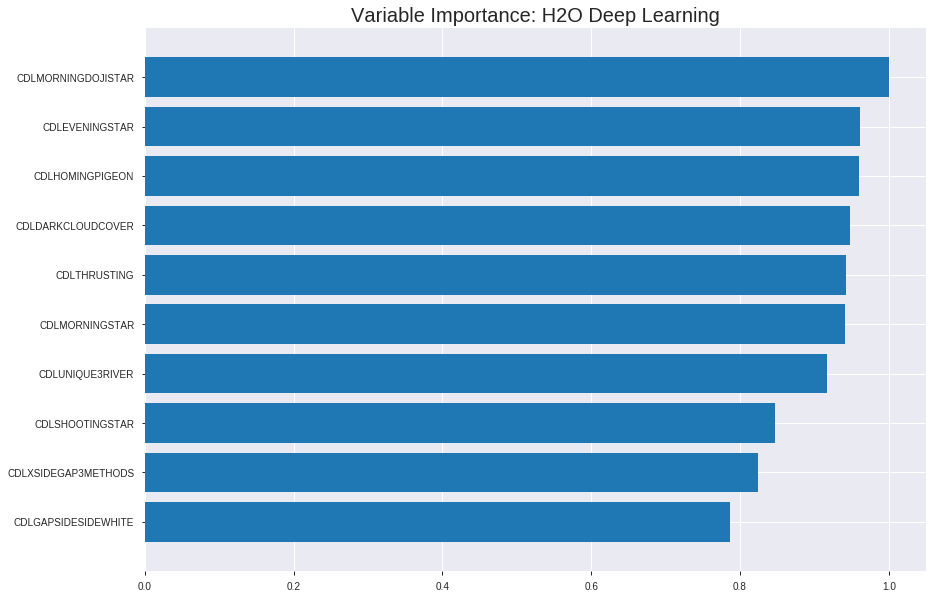

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_161821_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26145842097313793
RMSE: 0.511330050919304
LogLoss: 0.7533076094179706
Mean Per-Class Error: 0.4176245210727969
AUC: 0.5994847403884265
pr_auc: 0.5854678974487887
Gini: 0.19896948077685295
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20161474915126676: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   736   0.9761   (736.0/754.0)
1      6    777   0.0077   (6.0/783.0)
Total  24   1513  0.4828   (742.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.201615     0.676829  381
max f2                       0.11129      0.839408  394
max f0point5                 0.507776     0.591478  264
max accuracy                 0.614592     0.581653  189
max precision                0.985323     0.727273  6
max recall                   0.11129      1         394
max specificity              0.998974     0.998674  0
max absolute_mcc             0.677285     0.167261  147
max min_per_class_accuracy   0.60089      0.576923  200
max mean_per_class_accuracy  0.614592     0.582375  189

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 60.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.987591           1.34954   1.34954            0.6875           0.995147  0.6875                      0.995147            0.0140485       0.0140485                  34.9537   34.9537
    2        0.0201692                   0.977593           1.30864   1.32975            0.666667         0.982733  0.677419                    0.98914             0.0127714       0.0268199                  30.8642   32.9749
    3        0.0305791                   0.9635             0.981481  1.21119            0.5              0.969246  0.617021                    0.982368            0.0102171       0.037037                   -1.85185  21.119
    4        0.0403383                   0.944319           1.04691   1.17145            0.533333         0.954087  0.596774                    0.975526            0.0102171       0.0472542                  4.69136   17.1446
    5        0.0500976                   0.926127           1.17778   1.17268            0.6              0.933803  0.597403                    0.967398            0.0114943       0.0587484                  17.7778   17.2679
    6        0.100195                    0.847244           1.24916   1.21092            0.636364         0.889993  0.616883                    0.928696            0.0625798       0.121328                   24.9158   21.0919
    7        0.150293                    0.787604           1.22367   1.21517            0.623377         0.814952  0.619048                    0.890781            0.0613027       0.182631                   22.3665   21.5168
    8        0.20039                     0.745314           1.27465   1.23004            0.649351         0.764446  0.626623                    0.859197            0.063857        0.246488                   27.4651   23.0038
    9        0.299935                    0.680086           1.27015   1.24335            0.647059         0.709079  0.633406                    0.809375            0.126437        0.372925                   27.0153   24.3352
    10       0.40013                     0.63613            0.981481  1.17778            0.5              0.658086  0.6                         0.771491            0.0983397       0.471264                   -1.85185  17.7778
    11       0.500325                    0.601013           1.05796   1.15378            0.538961         0.618753  0.587776                    0.740904            0.106003        0.577267                   5.79606   15.3783
    12       0.59987                     0.566803           0.898088  1.11135            0.457516         0.583317  0.566161                    0.714753            0.0893997       0.666667                   -10.1912  11.1352
    13       0.700065                    0.527899           0.892256  1.07999            0.454545         0.548191  0.550186                    0.690914            0.0893997       0.756066                   -10.7744  7.99945
    14       0.79961                     0.47314            0.923747  1.06054            0.470588         0.502506  0.540277                    0.667459            0.091954        0.84802                    -7.62527  6.0543
    15       0.899805                    0.379445           0.701058  1.02051            0.357143         0.431742  0.519884                    0.641212            0.0702427       0.918263                   -29.8942  2.05136
    16       1                           0.017589           0.815777  1                  0.415584         0.28507   0.509434                    0.605528           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29462822289722146
RMSE: 0.5427966680970153
LogLoss: 0.8056705704102646
Mean Per-Class Error: 0.4702325581395349
AUC: 0.486108527131783
pr_auc: 0.49267096033793184
Gini: -0.027782945736434028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0869590429761243: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    215  0        (0.0/215.0)
Total  1    439  0.5091   (224.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.086959     0.657492   398
max f2                       0.086959     0.82756    398
max f0point5                 0.133873     0.545548   391
max accuracy                 0.812742     0.538636   46
max precision                0.928149     0.714286   6
max recall                   0.086959     1          398
max specificity              0.957955     0.995556   0
max absolute_mcc             0.830368     0.0969938  36
max min_per_class_accuracy   0.508981     0.497674   198
max mean_per_class_accuracy  0.812742     0.529767   46

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 52.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.937939           1.22791   1.22791            0.6              0.947571  0.6                         0.947571            0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.902947           1.02326   1.13695            0.5              0.919677  0.555556                    0.935174            0.00930233      0.0232558                  2.32558   13.6951
    3        0.0318182                   0.890409           1.22791   1.16944            0.6              0.897125  0.571429                    0.921585            0.0139535       0.0372093                  22.7907   16.9435
    4        0.0409091                   0.864419           1.02326   1.13695            0.5              0.878591  0.555556                    0.912031            0.00930233      0.0465116                  2.32558   13.6951
    5        0.05                        0.853045           1.02326   1.11628            0.5              0.856789  0.545455                    0.901987            0.00930233      0.055814                   2.32558   11.6279
    6        0.1                         0.815279           1.39535   1.25581            0.681818         0.835881  0.613636                    0.868934            0.0697674       0.125581                   39.5349   25.5814
    7        0.15                        0.765834           0.55814   1.02326            0.272727         0.795244  0.5                         0.84437             0.027907        0.153488                   -44.186   2.32558
    8        0.2                         0.709889           0.651163  0.930233           0.318182         0.74064   0.454545                    0.818438            0.0325581       0.186047                   -34.8837  -6.97674
    9        0.3                         0.627093           1.02326   0.96124            0.5              0.673213  0.469697                    0.77003             0.102326        0.288372                   2.32558   -3.87597
    10       0.4                         0.555971           1.06977   0.988372           0.522727         0.591581  0.482955                    0.725417            0.106977        0.395349                   6.97674   -1.16279
    11       0.5                         0.507637           1.02326   0.995349           0.5              0.532565  0.486364                    0.686847            0.102326        0.497674                   2.32558   -0.465116
    12       0.6                         0.461325           0.883721  0.976744           0.431818         0.484768  0.477273                    0.653167            0.0883721       0.586047                   -11.6279  -2.32558
    13       0.7                         0.406256           0.837209  0.956811           0.409091         0.435596  0.467532                    0.622086            0.0837209       0.669767                   -16.2791  -4.31894
    14       0.8                         0.34506            1.2093    0.988372           0.590909         0.377248  0.482955                    0.591481            0.12093         0.790698                   20.9302   -1.16279
    15       0.9                         0.271203           1.02326   0.992248           0.5              0.310103  0.484848                    0.560217            0.102326        0.893023                   2.32558   -0.775194
    16       1                           0.0789661          1.06977   1                  0.522727         0.197906  0.488636                    0.52398


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:19:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:20:02  1 min 39.833 sec  1131 obs/sec      2.28172   1             3507       0.587666         1.56311             -0.381898      0.584435        0.528409           1.34954          0.46324                          0.705349           5.36834               -0.991096        0.502439          0.456535             0.818605           0.509091
    2019-08-28 16:20:08  1 min 45.926 sec  1192 obs/sec      6.83539   3             10506      0.567735         1.18069             -0.28975       0.604426        0.571353           1.59491          0.463891                         0.695786           3.7215                -0.937474        0.506036          0.483354             1.22791            0.504545
    2019-08-28 16:20:14  1 min 51.828 sec  1221 obs/sec      11.4008   5             17523      0.528347         0.888058            -0.116998      0.611921        0.57805            1.34954          0.450228                         0.669942           2.14325               -0.796215        0.481891          0.459134             0                  0.509091
    2019-08-28 16:20:20  1 min 57.617 sec  1245 obs/sec      16.0176   7             24619      0.501236         0.715975            -0.00530969    0.643942        0.633401           1.59491          0.437215                         0.641526           1.39341               -0.647073        0.501922          0.482002             1.22791            0.506818
    2019-08-28 16:20:26  2 min  3.135 sec  1266 obs/sec      20.5361   9             31564      0.497704         0.699036            0.0088103      0.640746        0.62411            1.71759          0.415745                         0.552176           0.847146              -0.220222        0.500465          0.483598             0.818605           0.506818
    2019-08-28 16:20:31  2 min  8.641 sec  1284 obs/sec      25.1113   11            38596      0.51133          0.753308            -0.0462061     0.599485        0.585468           1.34954          0.482759                         0.542797           0.805671              -0.179122        0.486109          0.492671             1.22791            0.509091
    2019-08-28 16:20:36  2 min 13.961 sec  1303 obs/sec      29.6825   13            45622      0.498427         0.700738            0.00592784     0.619133        0.625182           1.22685          0.479506                         0.592898           1.04452               -0.406841        0.487576          0.494423             1.22791            0.511364
    2019-08-28 16:20:42  2 min 19.235 sec  1317 obs/sec      34.2023   15            52569      0.501387         0.707438            -0.00591334    0.620209        0.608462           1.47222          0.426805                         0.632058           1.24101               -0.598816        0.490253          0.48295              1.22791            0.511364
    2019-08-28 16:20:47

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLMORNINGDOJISTAR        1.0                    1.0                  0.006215211875372207
CDLEVENINGSTAR            0.9616027474403381     0.9616027474403381   0.005976564815281731
CDLHOMINGPIGEON           0.9592516422271729     0.9592516422271729   0.005961952198240617
CDLDARKCLOUDCOVER         0.9472517967224121     0.9472517967224121   0.005887370615956796
CDLTHRUSTING              0.9423500895500183     0.9423500895500183   0.005856905467329337
---                       ---                    ---                  ---
MAVP_14_5                 0.3212493360042572     0.3212493360042572   0.0019966326880890956
BBANDS_middleband_14_1_2  0.32067790627479553    0.32067790627479553  0.0019930811312486047
MAVP_20_5                 0.31345438957214355    0.31345438957214355  0.001948185444456333
AVGPRICE                  0.3123333156108856     0.3123333156108856   0.001941217732259152
BBANDS_middleband_24_1_2  0.31016573309898376    0.31016573309898376  0.0019277457476903305


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5545454545454546)

('F1', 0.654434250764526)

('auc', 0.5047556033413283)

('logloss', 0.784676616692893)

('mean_per_class_error', 0.4505003721776528)

('rmse', 0.5328627874867274)

('mse', 0.28394275028812527)

deeplearning prediction progress: |███████████████████████████████████████| 100%


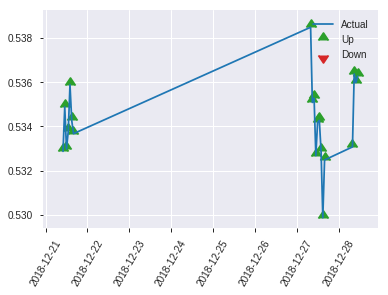


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28394275028812527
RMSE: 0.5328627874867274
LogLoss: 0.784676616692893
Mean Per-Class Error: 0.4505003721776528
AUC: 0.5047556033413283
pr_auc: 0.4915373629184647
Gini: 0.009511206682656592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08997450376166005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    113  1        (113.0/113.0)
1      0    107  0        (0.0/107.0)
Total  0    220  0.5136   (113.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0899745    0.654434  219
max f2                       0.0899745    0.825617  219
max f0point5                 0.16893      0.545171  213
max accuracy                 0.612572     0.554545  54
max precision                0.612572     0.581818  54
max recall                   0.0899745    1         219
max specificity              0.950982     0.99115   0
max absolute_mcc             0.336175     0.12451   171
max min_per_class_accuracy   0.477333     0.504673  103
max mean_per_class_accuracy  0.547537     0.5495    68

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 47.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.903242           0.685358  0.685358           0.333333         0.92046   0.333333                    0.92046             0.00934579      0.00934579                 -31.4642  -31.4642
    2        0.0227273                   0.869496           1.02804   0.82243            0.5              0.884971  0.4                         0.906264            0.00934579      0.0186916                  2.80374   -17.757
    3        0.0318182                   0.850726           1.02804   0.881175           0.5              0.86181   0.428571                    0.893563            0.00934579      0.0280374                  2.80374   -11.8825
    4        0.0409091                   0.815154           1.02804   0.913811           0.5              0.837606  0.444444                    0.881128            0.00934579      0.0373832                  2.80374   -8.6189
    5        0.05                        0.797842           1.02804   0.934579           0.5              0.806211  0.454545                    0.867507            0.00934579      0.046729                   2.80374   -6.54206
    6        0.1                         0.740986           0.934579  0.934579           0.454545         0.776941  0.454545                    0.822224            0.046729        0.0934579                  -6.54206  -6.54206
    7        0.15                        0.681062           1.30841   1.05919            0.636364         0.707799  0.515152                    0.784082            0.0654206       0.158879                   30.8411   5.919
    8        0.2                         0.634333           1.1215    1.07477            0.545455         0.655486  0.522727                    0.751933            0.0560748       0.214953                   12.1495   7.47664
    9        0.3                         0.55504            1.30841   1.15265            0.636364         0.603727  0.560606                    0.702531            0.130841        0.345794                   30.8411   15.2648
    10       0.4                         0.50246            0.747664  1.0514             0.363636         0.530272  0.511364                    0.659466            0.0747664       0.420561                   -25.2336  5.14019
    11       0.5                         0.458022           0.841121  1.00935            0.409091         0.483158  0.490909                    0.624204            0.0841121       0.504673                   -15.8879  0.934579
    12       0.6                         0.41923            0.934579  0.996885           0.454545         0.435598  0.484848                    0.59277             0.0934579       0.598131                   -6.54206  -0.311526
    13       0.7                         0.383966           0.934579  0.987984           0.454545         0.39903   0.480519                    0.565093            0.0934579       0.691589                   -6.54206  -1.2016
    14       0.8                         0.322406           0.654206  0.946262           0.318182         0.356644  0.460227                    0.539037            0.0654206       0.757009                   -34.5794  -5.37383
    15       0.9                         0.22935            1.1215    0.965732           0.545455         0.281309  0.469697                    0.5104              0.11215         0.869159                   12.1495   -3.42679
    16       1                           0.0899745          1.30841   1                  0.636364         0.18503   0.486364                    0.477863  

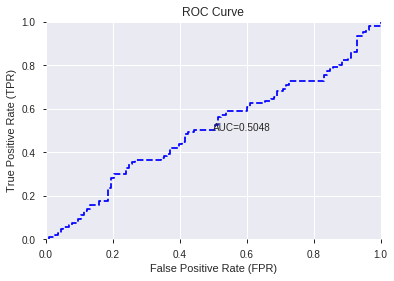

This function is available for GLM models only


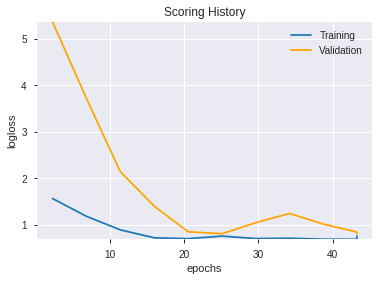

--2019-08-28 16:31:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_161821_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_161821_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMORNINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'CDLMORNINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLSHOOTINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'CORREL_20',
 'CDLSEPARATINGLINES',
 'CORREL_12',
 'aroonup_20',
 'AD',
 'TRANGE',
 'aroonup_12',
 'HT_DCPERIOD',
 'CORREL_14',
 'HT_PHASOR_quadrature',
 'aroondown_20',
 'aroonup_24',
 'AROONOSC_12',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'aroonup_14',
 'STOCHRSI_fastk',
 'aroondown_12',
 'ADXR_8',
 'aroondown_14',
 'aroondown_24',
 'VAR_8',
 'aroondown_30',
 'CORREL_8',
 'CDLDOJI',
 'ADX_24',
 'BOP',
 'aroonup_8',
 'WILLR_8',
 'CDLLONGLEGGEDDOJI',
 'DX_20',
 'AROONOSC_8',
 'AROONOSC_20',
 'DX_30',
 'DX_24',
 'HT_PHASOR_inphase',
 'OBV',
 'STDDEV_8',
 'VAR_12',
 'VAR_14',
 'VAR_20',
 'AROONOSC_24',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'ADX_20',
 'CDLENGULFING',
 'ATR_30',
 'DX_8',
 'ATR_20',
 'AROONOSC_30',
 'CDLBELTHOLD',


In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_163212_model_1  0.485154  0.743447              0.478124  0.523482  0.274033

variable  relative_importance  scaled_importance  percentage
0                     TRANGE             0.006911           1.000000    0.013725
1        CDLXSIDEGAP3METHODS             0.006413           0.927984    0.012737
2             CDLMORNINGSTAR             0.005923           0.857088    0.011764
3                 aroonup_12             0.005343           0.773195    0.010612
4                 aroonup_14             0.005020           0.726432    0.009971
..                       ...                  ...                ...         ...
414  BBANDS_upperband_24_0_5             0.000031           0.004442    0.000061
415      CDLGAPSIDESIDEWHITE             0.000029           0.004186    0.000057
416              MINUS_DM_24             0.000008           0.001124    0.000015
417             MACDEXT_hist             0.000004           0.000567    0.000008
418  BBANDS_lowerband_12_7_2             0.000001           0.000165    0.000002

[419 rows x 4 columns]

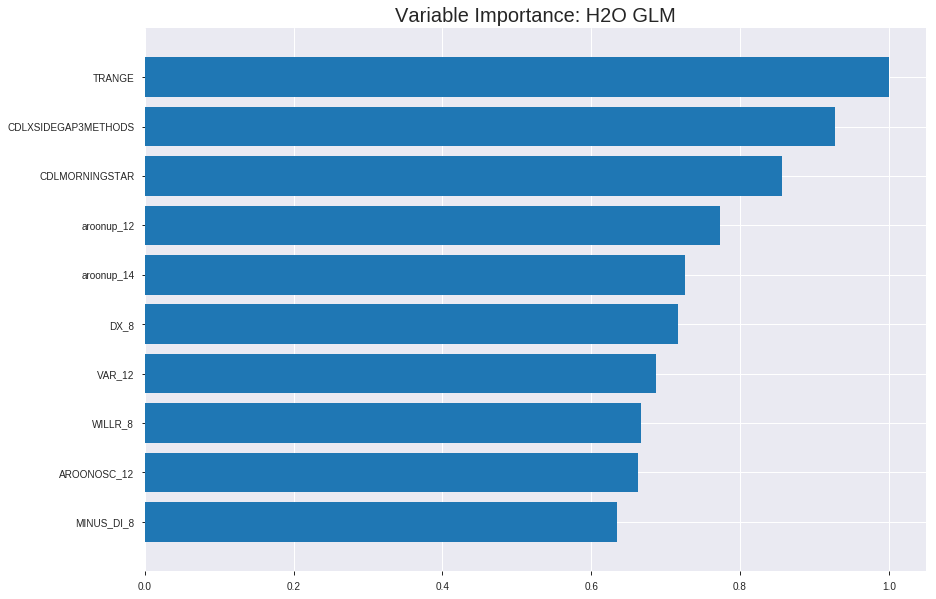

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_163212_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24715680883764493
RMSE: 0.4971486788050884
LogLoss: 0.6874443996020374
Null degrees of freedom: 1536
Residual degrees of freedom: 1117
Null deviance: 2130.187230760045
Residual deviance: 2113.204084376663
AIC: 2953.204084376663
AUC: 0.5705543190679933
pr_auc: 0.5679727620730282
Gini: 0.1411086381359865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46318392401608693: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      43   711   0.943    (711.0/754.0)
1      11   772   0.014    (11.0/783.0)
Total  54   1483  0.4697   (722.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463184     0.681377  371
max f2                       0.446848     0.839056  391
max f0point5                 0.490548     0.583317  275
max accuracy                 0.490548     0.562134  275
max precision                0.589255     1         0
max recall                   0.420959     1         399
max specificity              0.589255     1         0
max absolute_mcc             0.490548     0.128148  275
max min_per_class_accuracy   0.507842     0.542784  206
max mean_per_class_accuracy  0.490548     0.558208  275

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.574044           1.34954   1.34954            0.6875           0.578463  0.6875                      0.578463            0.0140485       0.0140485                  34.9537   34.9537
    2        0.0201692                   0.568464           1.17778   1.26643            0.6              0.571086  0.645161                    0.574894            0.0114943       0.0255428                  17.7778   26.6428
    3        0.0305791                   0.563292           1.22685   1.25296            0.625            0.565386  0.638298                    0.571657            0.0127714       0.0383142                  22.6852   25.2955
    4        0.0403383                   0.55785            1.30864   1.26643            0.666667         0.560696  0.645161                    0.569005            0.0127714       0.0510856                  30.8642   26.6428
    5        0.0500976                   0.555295           1.17778   1.24916            0.6              0.556527  0.636364                    0.566574            0.0114943       0.0625798                  17.7778   24.9158
    6        0.100195                    0.547481           1.17268   1.21092            0.597403         0.550924  0.616883                    0.558749            0.0587484       0.121328                   17.2679   21.0919
    7        0.150293                    0.541521           1.12169   1.18118            0.571429         0.544791  0.601732                    0.554097            0.0561941       0.177522                   12.1693   18.1177
    8        0.20039                     0.536279           1.17268   1.17905            0.597403         0.538708  0.600649                    0.550249            0.0587484       0.236271                   17.2679   17.9052
    9        0.299935                    0.526081           1.03922   1.13264            0.529412         0.531202  0.577007                    0.543928            0.103448        0.339719                   3.92157   13.2642
    10       0.40013                     0.517657           1.01972   1.10437            0.519481         0.52177   0.562602                    0.538379            0.102171        0.44189                    1.9721    10.4366
    11       0.500325                    0.50759            1.01972   1.08742            0.519481         0.51245   0.553966                    0.533187            0.102171        0.544061                   1.9721    8.74151
    12       0.59987                     0.498849           0.975067  1.06877            0.496732         0.503395  0.544469                    0.528243            0.0970626       0.641124                   -2.49334  6.87716
    13       0.700065                    0.491212           1.14719   1.07999            0.584416         0.494919  0.550186                    0.523473            0.114943        0.756066                   14.7186   7.99945
    14       0.79961                     0.483695           0.833939  1.04936            0.424837         0.487255  0.534581                    0.518965            0.083014        0.83908                    -16.6061  4.93626
    15       0.899805                    0.474892           0.84127   1.02619            0.428571         0.479495  0.522777                    0.51457             0.0842912       0.923372                   -15.873   2.61911
    16       1                           0.420959           0.764791  1                  0.38961          0.463314  0.509434                    0.509434         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.26030030686081146
RMSE: 0.5101963414812101
LogLoss: 0.7142012916318614
Null degrees of freedom: 439
Residual degrees of freedom: 20
Null deviance: 610.5035894343387
Residual deviance: 628.4971366360379
AIC: 1468.4971366360378
AUC: 0.5154935400516796
pr_auc: 0.5006475653631054
Gini: 0.030987080103359155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5311523445573934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    224  0.9956   (224.0/225.0)
1      0    215  0        (0.0/215.0)
Total  1    439  0.5091   (224.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.531152     0.657492   398
max f2                       0.531152     0.82756    398
max f0point5                 0.568191     0.553827   312
max accuracy                 0.575462     0.534091   277
max precision                0.63546      0.666667   16
max recall                   0.531152     1          398
max specificity              0.660002     0.995556   0
max absolute_mcc             0.568191     0.0889353  312
max min_per_class_accuracy   0.591531     0.497674   195
max mean_per_class_accuracy  0.575151     0.538863   279

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 59.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.642906           1.22791   1.22791            0.6              0.650833  0.6                         0.650833            0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.640785           0.511628  0.909561           0.25             0.641801  0.444444                    0.646819            0.00465116      0.0186047                  -48.8372  -9.04393
    3        0.0318182                   0.637341           1.63721   1.16944            0.8              0.639261  0.571429                    0.644119            0.0186047       0.0372093                  63.7209   16.9435
    4        0.0409091                   0.634392           2.04651   1.36434            1                0.63667   0.666667                    0.642464            0.0186047       0.055814                   104.651   36.4341
    5        0.05                        0.631785           0.511628  1.2093             0.25             0.63323   0.590909                    0.640785            0.00465116      0.0604651                  -48.8372  20.9302
    6        0.1                         0.625758           1.02326   1.11628            0.5              0.629057  0.545455                    0.634921            0.0511628       0.111628                   2.32558   11.6279
    7        0.15                        0.620651           0.744186  0.992248           0.363636         0.623324  0.484848                    0.631055            0.0372093       0.148837                   -25.5814  -0.775194
    8        0.2                         0.617517           1.11628   1.02326            0.545455         0.619243  0.5                         0.628102            0.055814        0.204651                   11.6279   2.32558
    9        0.3                         0.60805            0.883721  0.976744           0.431818         0.611913  0.477273                    0.622706            0.0883721       0.293023                   -11.6279  -2.32558
    10       0.4                         0.599814           0.976744  0.976744           0.477273         0.604142  0.477273                    0.618065            0.0976744       0.390698                   -2.32558  -2.32558
    11       0.5                         0.591366           1.06977   0.995349           0.522727         0.595423  0.486364                    0.613536            0.106977        0.497674                   6.97674   -0.465116
    12       0.6                         0.584917           1.16279   1.02326            0.568182         0.587864  0.5                         0.609258            0.116279        0.613953                   16.2791   2.32558
    13       0.7                         0.575501           1.2093    1.04983            0.590909         0.580691  0.512987                    0.605177            0.12093         0.734884                   20.9302   4.98339
    14       0.8                         0.567138           0.930233  1.03488            0.454545         0.572035  0.505682                    0.601034            0.0930233       0.827907                   -6.97674  3.48837
    15       0.9                         0.553683           0.837209  1.01292            0.409091         0.56152   0.494949                    0.596643            0.0837209       0.911628                   -16.2791  1.29199
    16       1                           0.528041           0.883721  1                  0.431818         0.543542  0.488636                    0.591333  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:32:13  0.000 sec   2            3.4       420           1.37489           1.4284
    2019-08-28 16:32:13  0.259 sec   4            2.4       420           1.37262           1.43067
    2019-08-28 16:32:13  0.475 sec   6            1.8       420           1.36984           1.43607
    2019-08-28 16:32:13  0.745 sec   8            1.3       420           1.36658           1.44122
    2019-08-28 16:32:14  0.998 sec   10           0.94      420           1.36283           1.44654

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5318181818181819)

('F1', 0.6625000000000001)

('auc', 0.48515424696054915)

('logloss', 0.7434471401429881)

('mean_per_class_error', 0.4665867173931023)

('rmse', 0.5234818305946086)

('mse', 0.27403322696268256)

glm prediction progress: |████████████████████████████████████████████████| 100%


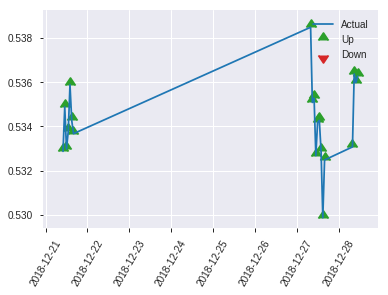


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.27403322696268256
RMSE: 0.5234818305946086
LogLoss: 0.7434471401429881
Null degrees of freedom: 219
Residual degrees of freedom: -200
Null deviance: 305.28953504515266
Residual deviance: 327.11674166291476
AIC: 1167.1167416629148
AUC: 0.48515424696054915
pr_auc: 0.4865563469408641
Gini: -0.029691506078901697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6047013496955733: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    107  0.9469   (107.0/113.0)
1      1    106  0.0093   (1.0/107.0)
Total  7    213  0.4909   (108.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.604701     0.6625    212
max f2                       0.595041     0.828173  217
max f0point5                 0.608361     0.55615   206
max accuracy                 0.687002     0.531818  11
max precision                0.70126      1         0
max recall                   0.595041     1         217
max specificity              0.70126      1         0
max absolute_mcc             0.608361     0.128153  206
max min_per_class_accuracy   0.630163     0.46729   109
max mean_per_class_accuracy  0.611277     0.533413  195

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 63.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.695597           2.05607   2.05607            1                0.698665  1                           0.698665            0.0280374       0.0280374                  105.607   105.607
    2        0.0227273                   0.693048           0         1.23364            0                0.693538  0.6                         0.696614            0               0.0280374                  -100      23.3645
    3        0.0318182                   0.690612           1.02804   1.1749             0.5              0.691716  0.571429                    0.695215            0.00934579      0.0373832                  2.80374   17.49
    4        0.0409091                   0.68812            2.05607   1.37072            1                0.689687  0.666667                    0.693986            0.0186916       0.0560748                  105.607   37.0717
    5        0.05                        0.687027           1.02804   1.30841            0.5              0.687665  0.636364                    0.692837            0.00934579      0.0654206                  2.80374   30.8411
    6        0.1                         0.67981            0.934579  1.1215             0.454545         0.683502  0.545455                    0.68817             0.046729        0.11215                    -6.54206  12.1495
    7        0.15                        0.671935           0.934579  1.05919            0.454545         0.676132  0.515152                    0.684157            0.046729        0.158879                   -6.54206  5.919
    8        0.2                         0.66259            0.373832  0.88785            0.181818         0.666851  0.431818                    0.679831            0.0186916       0.17757                    -62.6168  -11.215
    9        0.3                         0.649315           1.02804   0.934579           0.5              0.655755  0.454545                    0.671805            0.102804        0.280374                   2.80374   -6.54206
    10       0.4                         0.637424           1.02804   0.957944           0.5              0.642421  0.465909                    0.664459            0.102804        0.383178                   2.80374   -4.20561
    11       0.5                         0.630121           0.841121  0.934579           0.409091         0.633682  0.454545                    0.658304            0.0841121       0.46729                    -15.8879  -6.54206
    12       0.6                         0.625688           1.21495   0.981308           0.590909         0.628052  0.477273                    0.653262            0.121495        0.588785                   21.4953   -1.86916
    13       0.7                         0.620405           1.02804   0.987984           0.5              0.623364  0.480519                    0.648991            0.102804        0.691589                   2.80374   -1.2016
    14       0.8                         0.615322           1.1215    1.00467            0.545455         0.617956  0.488636                    0.645111            0.11215         0.803738                   12.1495   0.46729
    15       0.9                         0.61025            1.21495   1.02804            0.590909         0.612963  0.5                         0.641539            0.121495        0.925234                   21.4953   2.80374
    16       1                           0.591003           0.747664  1                  0.363636         0.605361  0.486364                    0.637922         

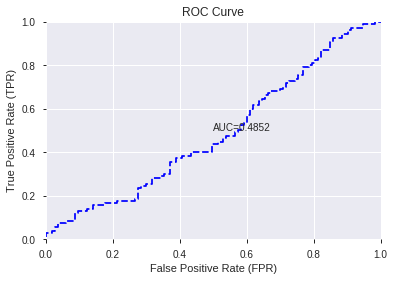

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


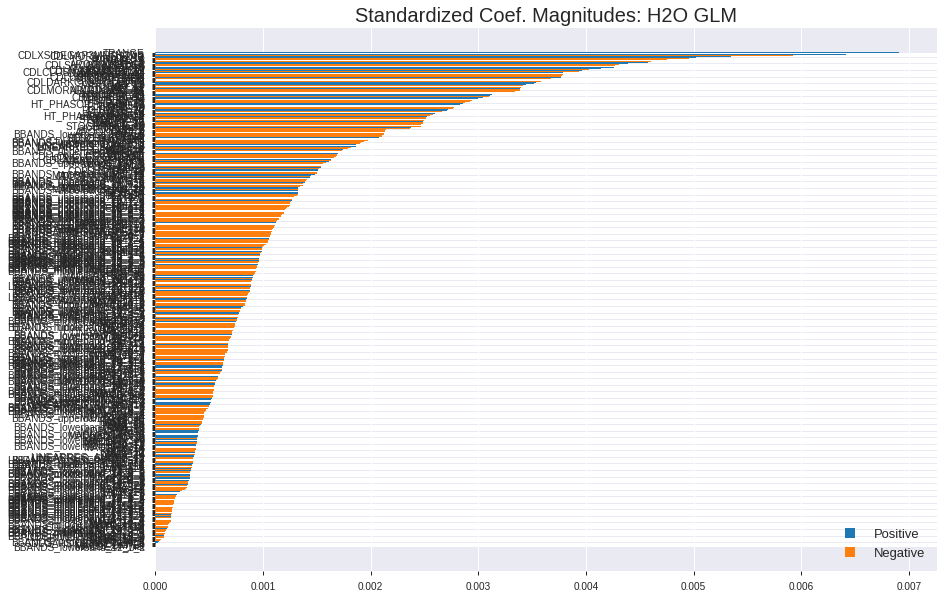

'log_likelihood'
--2019-08-28 16:32:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.104
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.104|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_163212_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_163212_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['TRANGE',
 'CDLXSIDEGAP3METHODS',
 'CDLMORNINGSTAR',
 'aroonup_12',
 'aroonup_14',
 'DX_8',
 'VAR_12',
 'WILLR_8',
 'AROONOSC_12',
 'MINUS_DI_8',
 'CDLSHOOTINGSTAR',
 'VAR_8',
 'CORREL_20',
 'MINUS_DI_12',
 'CDLMATCHINGLOW',
 'MINUS_DI_14',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CDLUNIQUE3RIVER',
 'CDL3OUTSIDE',
 'STOCHF_fastk',
 'CCI_8',
 'CDLDARKCLOUDCOVER',
 'MFI_12',
 'MINUS_DI_20',
 'MFI_14',
 'STDDEV_12',
 'VAR_14',
 'AROONOSC_24',
 'CDLMORNINGDOJISTAR',
 'ATR_30',
 'aroondown_24',
 'MINUS_DI_24',
 'CORREL_12',
 'AD',
 'CDLBELTHOLD',
 'MINUS_DI_30',
 'PLUS_DI_24',
 'STDDEV_8',
 'ATR_20',
 'DX_14',
 'HT_PHASOR_quadrature',
 'PLUS_DI_14',
 'ROC_20',
 'ROCR_20',
 'ROCR100_20',
 'PLUS_DI_12',
 'ADXR_8',
 'NATR_24',
 'aroondown_8',
 'aroondown_12',
 'HT_PHASOR_inphase',
 'aroonup_24',
 'STOCH_slowd',
 'STDDEV_14',
 'WILLR_12',
 'CORREL_14',
 'aroonup_20',
 'NATR_20',
 'STOCHRSI_fastd',
 'aroondown_30',
 'PLUS_DI_8',
 'CCI_12',
 'CMO_8',
 'AROONOSC_

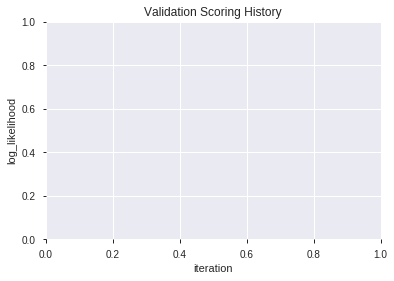

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190828_163328  0.551733  0.705870              0.491150  0.506084  0.256121
1  XGBoost_grid_1_AutoML_20190828_163328_model_1  0.535894  0.713548              0.500000  0.509754  0.259849
2  XGBoost_grid_1_AutoML_20190828_163328_model_4  0.512365  0.710625              0.474196  0.508248  0.258316
3               XGBoost_2_AutoML_20190828_163328  0.505335  0.718284              0.482301  0.511787  0.261926
4  XGBoost_grid_1_AutoML_20190828_163328_model_2  0.499380  0.712077              0.473948  0.509052  0.259134
5               XGBoost_1_AutoML_20190828_163328  0.493756  0.718358              0.491150  0.511777  0.261915
6  XGBoost_grid_1_AutoML_20190828_163328_model_6  0.493590  0.721777              0.473451  0.513483  0.263665
7  XGBoost_grid_1_AutoML_20190828_163328_model_7  0.477297  0.750394              0.491150  0.524744  0.275356
8  XGBoost_grid_1_AutoML_20190828_163328_model_5  0.474568  0.790439              0.491150  0.540502  0.292142
9  XGBoost_grid_1_AutoML_20190828_163328_model_3  0.473575  0.733336              0.486726  0.518492  0.268834

variable  relative_importance  scaled_importance  percentage
0                  CORREL_20           121.501923           1.000000    0.022485
1                  STDDEV_12           117.537643           0.967373    0.021751
2                    WILLR_8            97.653221           0.803717    0.018071
3                  PLUS_DI_8            92.131897           0.758275    0.017050
4                     TRANGE            91.272781           0.751204    0.016891
..                       ...                  ...                ...         ...
244                MAVP_14_1             1.345450           0.011073    0.000249
245  BBANDS_upperband_14_0_4             1.295164           0.010660    0.000240
246  BBANDS_upperband_14_7_4             1.162790           0.009570    0.000215
247  BBANDS_upperband_14_6_4             0.905287           0.007451    0.000168
248  BBANDS_upperband_12_7_3             0.716311           0.005895    0.000133

[249 rows x 4 columns]

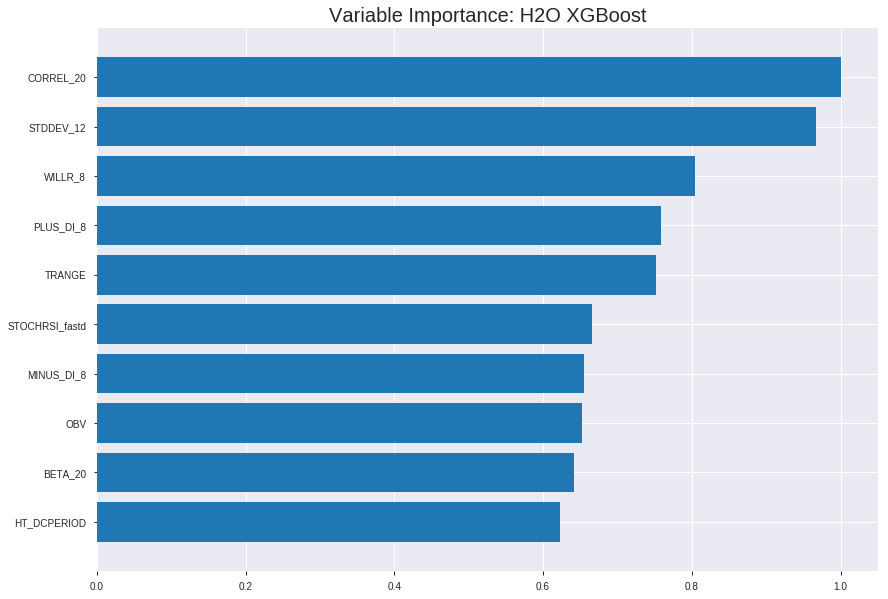

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190828_163328


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1700064374015373
RMSE: 0.4123183689838925
LogLoss: 0.5280911282729289
Mean Per-Class Error: 0.11359170841929467
AUC: 0.9572116019797351
pr_auc: 0.9572879384868858
Gini: 0.9144232039594702
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.498059019446373: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      637  117  0.1552   (117.0/754.0)
1      59   724  0.0754   (59.0/783.0)
Total  696  841  0.1145   (176.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498059     0.891626  208
max f2                       0.453266     0.925836  246
max f0point5                 0.55385      0.909779  157
max accuracy                 0.506692     0.886792  200
max precision                0.788791     1         0
max recall                   0.372296     1         316
max specificity              0.788791     1         0
max absolute_mcc             0.506692     0.773863  200
max min_per_class_accuracy   0.514011     0.881963  193
max mean_per_class_accuracy  0.506692     0.886408  200

Gains/Lift Table: Avg response rate: 50.94 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.737406           1.96296   1.96296            1                0.753385  1                           0.753385            0.0204342       0.0204342                  96.2963   96.2963
    2        0.0201692                   0.717724           1.96296   1.96296            1                0.725909  1                           0.74009             0.0191571       0.0395913                  96.2963   96.2963
    3        0.0305791                   0.708551           1.96296   1.96296            1                0.713876  1                           0.731166            0.0204342       0.0600255                  96.2963   96.2963
    4        0.0403383                   0.697735           1.96296   1.96296            1                0.703513  1                           0.724476            0.0191571       0.0791826                  96.2963   96.2963
    5        0.0500976                   0.690796           1.96296   1.96296            1                0.695011  1                           0.718736            0.0191571       0.0983397                  96.2963   96.2963
    6        0.100195                    0.6617             1.96296   1.96296            1                0.675952  1                           0.697344            0.0983397       0.196679                   96.2963   96.2963
    7        0.150293                    0.640982           1.91198   1.94597            0.974026         0.650018  0.991342                    0.681569            0.0957854       0.292465                   91.1977   94.5968
    8        0.20039                     0.622896           1.88648   1.9311             0.961039         0.630775  0.983766                    0.66887             0.0945083       0.386973                   88.6484   93.1097
    9        0.299935                    0.593487           1.91164   1.92464            0.973856         0.608242  0.980477                    0.648748            0.190294        0.577267                   91.1644   92.464
    10       0.40013                     0.555697           1.73353   1.87678            0.883117         0.5743    0.956098                    0.630106            0.173691        0.750958                   73.3526   87.6784
    11       0.500325                    0.515369           1.2619    1.75365            0.642857         0.536182  0.893368                    0.611297            0.126437        0.877395                   26.1905   75.3648
    12       0.59987                     0.473558           0.782619  1.59251            0.398693         0.49517   0.81128                     0.592026            0.0779055       0.9553                     -21.7381  59.2512
    13       0.700065                    0.43256            0.267677  1.4029             0.136364         0.452407  0.714684                    0.572044            0.0268199       0.98212                    -73.2323  40.2898
    14       0.79961                     0.392053           0.153958  1.24742            0.0784314        0.412517  0.635476                    0.552184            0.0153257       0.997446                   -84.6042  24.7416
    15       0.899805                    0.337284           0.025493  1.11135            0.012987         0.366257  0.566161                    0.531481            0.00255428      1                          -97.4507  11.1352
    16       1                           0.204953           0         1                  0                0.29904   0.509434                    0.508191          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2581319343610935
RMSE: 0.5080668601287566
LogLoss: 0.7101224856806788
Mean Per-Class Error: 0.45751937984496127
AUC: 0.5459018087855297
pr_auc: 0.5357147481469016
Gini: 0.09180361757105948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45610958337783813: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    218  0.9689   (218.0/225.0)
1      3    212  0.014    (3.0/215.0)
Total  10   430  0.5023   (221.0/440.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45611      0.657364  389
max f2                       0.346236     0.826923  399
max f0point5                 0.530719     0.55209   310
max accuracy                 0.629633     0.547727  105
max precision                0.70413      0.777778  8
max recall                   0.346236     1         399
max specificity              0.750389     0.995556  0
max absolute_mcc             0.683184     0.117681  27
max min_per_class_accuracy   0.583416     0.528889  198
max mean_per_class_accuracy  0.629188     0.542481  107

Gains/Lift Table: Avg response rate: 48.86 %, avg score: 58.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113636                   0.718306           1.22791   1.22791            0.6              0.73314   0.6                         0.73314             0.0139535       0.0139535                  22.7907   22.7907
    2        0.0204545                   0.70329            2.04651   1.59173            1                0.709006  0.777778                    0.722414            0.0186047       0.0325581                  104.651   59.1731
    3        0.0318182                   0.698556           0.818605  1.31561            0.4              0.701096  0.642857                    0.7148              0.00930233      0.0418605                  -18.1395  31.5615
    4        0.0409091                   0.69392            1.53488   1.36434            0.75             0.696081  0.666667                    0.71064             0.0139535       0.055814                   53.4884   36.4341
    5        0.05                        0.689294           1.53488   1.39535            0.75             0.691444  0.681818                    0.70715             0.0139535       0.0697674                  53.4884   39.5349
    6        0.1                         0.666051           1.11628   1.25581            0.545455         0.677468  0.613636                    0.692309            0.055814        0.125581                   11.6279   25.5814
    7        0.15                        0.654619           0.837209  1.11628            0.409091         0.660692  0.545455                    0.68177             0.0418605       0.167442                   -16.2791  11.6279
    8        0.2                         0.642359           1.2093    1.13953            0.590909         0.649003  0.556818                    0.673578            0.0604651       0.227907                   20.9302   13.9535
    9        0.3                         0.620698           1.06977   1.11628            0.522727         0.631808  0.545455                    0.659655            0.106977        0.334884                   6.97674   11.6279
    10       0.4                         0.602624           0.883721  1.05814            0.431818         0.611781  0.517045                    0.647686            0.0883721       0.423256                   -11.6279  5.81395
    11       0.5                         0.583318           1.06977   1.06047            0.522727         0.593293  0.518182                    0.636808            0.106977        0.530233                   6.97674   6.04651
    12       0.6                         0.568875           0.976744  1.04651            0.477273         0.576528  0.511364                    0.626761            0.0976744       0.627907                   -2.32558  4.65116
    13       0.7                         0.551202           0.976744  1.03654            0.477273         0.559799  0.506494                    0.617195            0.0976744       0.725581                   -2.32558  3.65449
    14       0.8                         0.526436           1.02326   1.03488            0.5              0.540298  0.505682                    0.607583            0.102326        0.827907                   2.32558   3.48837
    15       0.9                         0.503271           0.744186  1.00258            0.363636         0.515546  0.489899                    0.597357            0.0744186       0.902326                   -25.5814  0.258398
    16       1                           0.346236           0.976744  1                  0.477273         0.467918  0.488636                    0.584413        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:33:34  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.490566                         0.5                0.693147              0.5               0                    1                  0.511364
    2019-08-28 16:33:35  0.499 sec   5                  0.4886           0.670572            0.817201        0.813974           1.84028          0.270657                         0.499872           0.69289               0.518884          0.51312              1.63721            0.5
    2019-08-28 16:33:35  0.607 sec   10                 0.476662         0.647343            0.86367         0.871624           1.96296          0.229668                         0.500411           0.693971              0.519163          0.510123             0.818605           0.506818
    2019-08-28 16:33:35  0.727 sec   15                 0.465774         0.626518            0.894921        0.898203           1.96296          0.188679                         0.501727           0.696654              0.52738           0.501788             1.22791            0.493182
    2019-08-28 16:33:35  0.838 sec   20                 0.455356         0.606889            0.918553        0.9209             1.96296          0.153546                         0.503518           0.700326              0.53816           0.518758             0.818605           0.497727
    2019-08-28 16:33:35  0.940 sec   25                 0.448039         0.593238            0.927405        0.930527           1.96296          0.14704                          0.504276           0.7019                0.538956          0.523048             1.22791            0.5
    2019-08-28 16:33:35  1.050 sec   30                 0.439262         0.576999            0.937579        0.939515           1.96296          0.141184                         0.505326           0.704118              0.532093          0.512273             1.22791            0.502273
    2019-08-28 16:33:35  1.161 sec   35                 0.432234         0.5641              0.944564        0.945915           1.96296          0.120364                         0.505628           0.704826              0.543307          0.522464             0.818605           0.486364
    2019-08-28 16:33:35  1.265 sec   40                 0.426186         0.553073            0.947771        0.948592           1.96296          0.124268                         0.506563           0.706826              0.547287          0.526665             0.818605           0.495455
    2019-08-28 16:33:36  1.373 sec   45                 0.419498         0.540949            0.951692        0.951798           1.96296          0.119063                         0.506515           0.706778              0.546977          0.532417             1.22791            0.488636
    2019-08-28 16:33:36  1.485 sec   50                 0.412318         0.528091            0.957212        0.957288           1.96296          0.114509                         0.508067           0.710122              0.545902          0.535715             1.22791            0.502273

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
CORREL_20                121.50192260742188     1.0                    0.022484617215485152
STDDEV_12                117.53764343261719     0.9673727041537158     0.021751004957605062
WILLR_8                  97.6532211303711       0.8037174970958526     0.018071280271588046
PLUS_DI_8                92.13189697265625      0.7582752189884148     0.017049528042942685
TRANGE                   91.27278137207031      0.7512044205833411     0.016890543847396744
---                      ---                    ---                    ---
MAVP_14_1                1.345449686050415      0.011073484741452387   0.00024898306565307254
BBANDS_upperband_14_0_4  1.2951641082763672     0.010659618222347808   0.00023967743539270075
BBANDS_upperband_14_7_4  1.162790298461914      0.009570139085115068   0.00021518091402776557
BBANDS_upperband_14_6_4  0.9052867889404297     0.0074508021726162445  0.0001675284347995814
BBANDS_upperband_12_7_3  0.7163114547729492     0.005895474239427333   0.00013255748157727708


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6584615384615384)

('auc', 0.5517326937391448)

('logloss', 0.7058700648197891)

('mean_per_class_error', 0.42593664709287904)

('rmse', 0.5060841980854779)

('mse', 0.25612121555182127)

xgboost prediction progress: |████████████████████████████████████████████| 100%


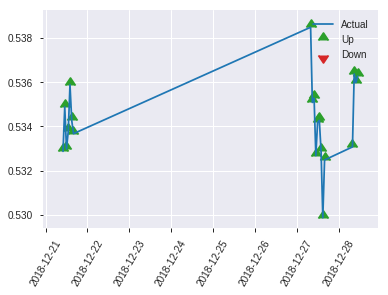


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25612121555182127
RMSE: 0.5060841980854779
LogLoss: 0.7058700648197891
Mean Per-Class Error: 0.42593664709287904
AUC: 0.5517326937391448
pr_auc: 0.5376780835449586
Gini: 0.1034653874782896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4421319365501404: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    111  0.9823   (111.0/113.0)
1      0    107  0        (0.0/107.0)
Total  2    218  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442132     0.658462  217
max f2                       0.442132     0.828173  217
max f0point5                 0.519692     0.566038  171
max accuracy                 0.630893     0.581818  46
max precision                0.73088      1         0
max recall                   0.442132     1         217
max specificity              0.73088      1         0
max absolute_mcc             0.630893     0.180631  46
max min_per_class_accuracy   0.575203     0.522124  109
max mean_per_class_accuracy  0.630893     0.574063  46

Gains/Lift Table: Avg response rate: 48.64 %, avg score: 57.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.727312           1.37072   1.37072            0.666667         0.729281  0.666667                    0.729281            0.0186916       0.0186916                  37.0717   37.0717
    2        0.0227273                   0.713689           0         0.82243            0                0.719037  0.4                         0.725184            0               0.0186916                  -100      -17.757
    3        0.0318182                   0.705093           2.05607   1.1749             1                0.711947  0.571429                    0.721402            0.0186916       0.0373832                  105.607   17.49
    4        0.0409091                   0.689331           1.02804   1.14226            0.5              0.698765  0.555556                    0.716371            0.00934579      0.046729                   2.80374   14.2264
    5        0.05                        0.676605           2.05607   1.30841            1                0.686299  0.636364                    0.710904            0.0186916       0.0654206                  105.607   30.8411
    6        0.1                         0.6611             1.30841   1.30841            0.636364         0.666905  0.636364                    0.688904            0.0654206       0.130841                   30.8411   30.8411
    7        0.15                        0.646925           1.49533   1.37072            0.727273         0.653508  0.666667                    0.677106            0.0747664       0.205607                   49.5327   37.0717
    8        0.2                         0.637275           1.1215    1.30841            0.545455         0.642639  0.636364                    0.668489            0.0560748       0.261682                   12.1495   30.8411
    9        0.3                         0.61809            0.747664  1.1215             0.363636         0.625703  0.545455                    0.654227            0.0747664       0.336449                   -25.2336  12.1495
    10       0.4                         0.598016           0.560748  0.981308           0.272727         0.607274  0.477273                    0.642489            0.0560748       0.392523                   -43.9252  -1.86916
    11       0.5                         0.574856           1.30841   1.04673            0.636364         0.585425  0.509091                    0.631076            0.130841        0.523364                   30.8411   4.6729
    12       0.6                         0.558765           1.1215    1.05919            0.545455         0.566759  0.515152                    0.620356            0.11215         0.635514                   12.1495   5.919
    13       0.7                         0.532347           0.934579  1.04139            0.454545         0.546025  0.506494                    0.609738            0.0934579       0.728972                   -6.54206  4.13885
    14       0.8                         0.514628           1.1215    1.0514             0.545455         0.522825  0.511364                    0.598874            0.11215         0.841121                   12.1495   5.14019
    15       0.9                         0.49209            0.560748  0.996885           0.272727         0.50491   0.484848                    0.588433            0.0560748       0.897196                   -43.9252  -0.311526
    16       1                           0.404254           1.02804   1                  0.5              0.468086  0.486364                    0.576398           

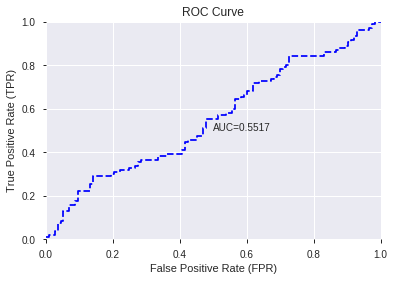

This function is available for GLM models only


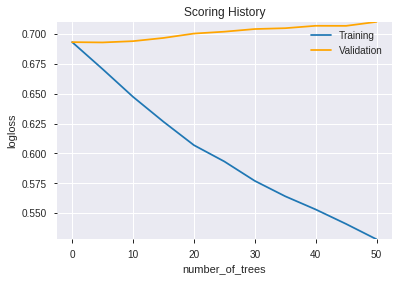

--2019-08-28 16:34:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190828_163328',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190828_163328',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a92b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a92b',
   'ty

['CORREL_20',
 'STDDEV_12',
 'WILLR_8',
 'PLUS_DI_8',
 'TRANGE',
 'STOCHRSI_fastd',
 'MINUS_DI_8',
 'OBV',
 'BETA_20',
 'HT_DCPERIOD',
 'CCI_8',
 'MACDEXT_hist',
 'MFI_14',
 'MFI_24',
 'HT_PHASOR_inphase',
 'BOP',
 'STOCH_slowk',
 'MINUS_DI_12',
 'HT_PHASOR_quadrature',
 'DX_30',
 'STDDEV_8',
 'LINEARREG_INTERCEPT_8',
 'MFI_30',
 'CCI_12',
 'DX_24',
 'CORREL_12',
 'STOCHF_fastk',
 'LINEARREG_ANGLE_8',
 'DX_8',
 'MFI_12',
 'BETA_12',
 'VAR_8',
 'MOM_8',
 'BBANDS_upperband_20_5_5',
 'STDDEV_14',
 'ULTOSC',
 'MINUS_DM_8',
 'CORREL_14',
 'ADX_24',
 'ATR_30',
 'NATR_12',
 'STDDEV_20',
 'BBANDS_lowerband_20_3_4',
 'aroonup_12',
 'AROONOSC_12',
 'MINUS_DI_24',
 'AROONOSC_24',
 'MFI_8',
 'CMO_20',
 'WILLR_20',
 'LINEARREG_SLOPE_12',
 'ROC_20',
 'BBANDS_upperband_24_1_4',
 'MINUS_DM_24',
 'STOCHRSI_fastk',
 'ADX_20',
 'BBANDS_lowerband_24_1_5',
 'WILLR_30',
 'BETA_14',
 'ADX_12',
 'MACD_hist',
 'MOM_14',
 'MACDFIX_8',
 'ADOSC',
 'ROC_8',
 'WILLR_14',
 'WILLR_24',
 'MOM_12',
 'CDLLONGLEGGEDDOJI'

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.600
GLM             0.536
XGBoost         0.582
dtype: float64

DeepLearning    GLM  XGBoost
All          0.541  0.536    0.568
DLF          0.568  0.536    0.582
Fwe          0.545  0.536    0.568
RFE          0.555  0.532    0.582
XGBF         0.600  0.536    0.582





F1


DeepLearning    0.660
GLM             0.663
XGBoost         0.658
dtype: float64

DeepLearning    GLM  XGBoost
All          0.660  0.663    0.656
DLF          0.654  0.662    0.658
Fwe          0.654  0.663    0.656
RFE          0.654  0.663    0.658
XGBF         0.654  0.662    0.658





auc


DeepLearning    0.584
GLM             0.493
XGBoost         0.566
dtype: float64

DeepLearning    GLM  XGBoost
All          0.513  0.493    0.547
DLF          0.543  0.491    0.566
Fwe          0.524  0.493    0.547
RFE          0.505  0.485    0.552
XGBF         0.584  0.491    0.566





logloss


DeepLearning    1.136
GLM             0.753
XGBoost         0.726
dtype: float64

DeepLearning    GLM  XGBoost
All          0.738  0.753    0.705
DLF          0.690  0.719    0.726
Fwe          0.741  0.753    0.705
RFE          0.785  0.743    0.706
XGBF         1.136  0.719    0.726





mean_per_class_error


DeepLearning    0.464
GLM             0.467
XGBoost         0.434
dtype: float64

DeepLearning    GLM  XGBoost
All          0.464  0.455    0.434
DLF          0.439  0.462    0.418
Fwe          0.454  0.455    0.434
RFE          0.451  0.467    0.426
XGBF         0.399  0.462    0.418





rmse


DeepLearning    0.623
GLM             0.528
XGBoost         0.514
dtype: float64

DeepLearning    GLM  XGBoost
All          0.520  0.528    0.506
DLF          0.499  0.512    0.514
Fwe          0.519  0.528    0.506
RFE          0.533  0.523    0.506
XGBF         0.623  0.512    0.514





mse


DeepLearning    0.388
GLM             0.278
XGBoost         0.265
dtype: float64

DeepLearning    GLM  XGBoost
All          0.270  0.278    0.256
DLF          0.249  0.262    0.265
Fwe          0.269  0.278    0.256
RFE          0.284  0.274    0.256
XGBF         0.388  0.262    0.265

{'F1':       DeepLearning    GLM  XGBoost
 All          0.660    NaN      NaN
 DLF          0.654    NaN      NaN
 DLF            NaN  0.662      NaN
 DLF            NaN    NaN    0.658
 All            NaN  0.663      NaN
 All            NaN    NaN    0.656
 XGBF         0.654    NaN      NaN
 XGBF           NaN  0.662      NaN
 XGBF           NaN    NaN    0.658
 Fwe          0.654    NaN      NaN
 Fwe            NaN  0.663      NaN
 Fwe            NaN    NaN    0.656
 RFE          0.654    NaN      NaN
 RFE            NaN  0.663      NaN
 RFE            NaN    NaN    0.658,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.541    NaN      NaN
 DLF          0.568    NaN      NaN
 DLF            NaN  0.536      NaN
 DLF            NaN    NaN    0.582
 All            NaN  0.536      NaN
 All            NaN    NaN    0.568
 XGBF         0.600    NaN      NaN
 XGBF           NaN  0.536      NaN
 XGBF           NaN    NaN    0.582
 Fwe          0.545    NaN      NaN
 Fwe     